# irp-dbk24 - "Optimising Demand Response Strategies for Carbon-Intelligent Electricity Use"

# Maringal Emissions Exploratory Data Analysis

**NOTEBOOK PURPOSE(S):**
* Perform exploratory data analysis on the dataset used to calculate marginal emissions
    * Split data into train, validation and test set

**LIMITATIONS:**

**NOTEBOOK INPUT**
* weather_and_grid_data_half-hourly_20250714_1401.parquet

**NOTEBOOK OUTPUTS:**
* Primary output:
    * marginal_emissions_estimation_20250714_1401_train_data.parquet
    * marginal_emissions_estimation_20250714_1401_validation_data.parquet
    * marginal_emissions_estimation_20250714_1401_test_data.parquet
    

### Importing Libraries

In [23]:
# ────────────────────────────────────────────────────────────────────────────
# Jupyter/Notebook Setup
# ────────────────────────────────────────────────────────────────────────────
%matplotlib inline
from IPython.display import display

# ────────────────────────────────────────────────────────────────────────────
# Core Data Handling
# ────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import polars as pl

# ────────────────────────────────────────────────────────────────────────────
# Machine Learning & Statistics
# ────────────────────────────────────────────────────────────────────────────
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.kernel_approximation import RBFSampler
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import skew, kurtosis, zscore
from sklearn.metrics import root_mean_squared_error
from feature_engine.creation import CyclicalFeatures

# ────────────────────────────────────────────────────────────────────────────
# Visualization
# ────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ────────────────────────────────────────────────────────────────────────────
# Geospatial
# ────────────────────────────────────────────────────────────────────────────
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.wkb import loads
from pyproj import Proj, transform

# ────────────────────────────────────────────────────────────────────────────
# System & Utilities
# ────────────────────────────────────────────────────────────────────────────
import os
import re
import logging
import random
import binascii
import calendar
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Any, Union, Callable, Iterable, Sequence
import json
import hashlib
from pathlib import Path
import math
from itertools import product,combinations
from copy import deepcopy
from multiprocessing import Pool, cpu_count, Manager, Lock
from multiprocessing.pool import ThreadPool
from functools import wraps
from tqdm import tqdm
from functools import partial
import inspect

# ────────────────────────────────────────────────────────────────────────────
# Logging Configuration
# ────────────────────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s"
)

from zoneinfo import ZoneInfo


## Functions

### Data Quality and Diagnostics Functions

In [24]:
def correlation_checker(
        df: pd.DataFrame,
        columns: Optional[List[str]] = None,
        display_plot: bool = True,
        display_table: bool = False
) -> pd.DataFrame:
    """
    Compute the Pearson correlation matrix for a subset of columns, optionally plot a heatmap and or display the correlation table.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    columns : List[str]
        List of column names to include in the correlation analysis.
        If none, all numeric columns will be used.
    display_plot : bool, optional
        Whether to display a heatmap of the correlation matrix (default is True).
    display_table : bool, optional
        Whether to display the correlation matrix as a table (default is False).

    Returns
    -------
    corr_matrix : pd.DataFrame
        The correlation matrix of the specified columns.
        Also displays a heatmap if `display_plot` is True and a table if `display_table` is True.
    """
    # If no columns specified, use all numeric columns
    if columns is None:
        # If no columns specified, use all numeric columns
        cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # If columns are specified, ensure they are in the dataframe and numeric
    else:
        # Keep only existing numeric columns
        cols = [c for c in columns
                if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

    # If no valid numeric columns are found, raise an error
    if not cols:
        raise ValueError("No valid numeric columns provided for correlation analysis.")

    # Subset and compute correlation
    corr_matrix = df[cols].corr()

    if display_plot:
        n = len(cols)
        # Dynamic figure size: at least 6x6, scale by number of cols
        fig_size = (max(6, n * 0.8), max(6, n * 0.8))
        fig, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="vlag", square=True, ax=ax)
        ax.set_title("Correlation Matrix for Selected Numeric Columns")
        plt.tight_layout()
        plt.show()

    if display_table:
        print("-" * 120)
        print("\nCorrelation Matrix for Selected Numeric Columns:\n"+ "-" * 120)
        display(corr_matrix)

    return corr_matrix

In [25]:
def vif_calculator(
        df: pd.DataFrame,
        columns: Optional[List[str]] = None,
        display_table: bool = False
) -> pd.DataFrame:
    """
    Compute Variance Inflation Factors (VIF) for a subset of columns.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    columns : List[str]
        List of column names to include in the VIF calculation.
        If none, all numeric columns will be used.

    Returns
    -------
    vif_df : pd.DataFrame
        DataFrame with columns ['Variable', 'VIF'], excluding the constant term.
    """
    # Step 1: Select numeric columns
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

    if not cols:
        raise ValueError("No valid numeric columns provided for VIF calculation.")

    # Step 2: Extract and clean
    X = df[cols].copy()

    # Step 3: Convert all to float64 safely
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    # Step 4: Drop rows with NaN/Inf
    X = X.replace([np.inf, -np.inf], np.nan).dropna()

    # Step 5: Force float64 dtype
    try:
        X = X.astype(np.float64)
    except Exception as e:
        raise TypeError(f"Failed to convert columns to float64. Error: {e}")

    # # Diagnostic: Show dtypes and values before VIF
    # print("Final column dtypes:")
    # print(X.dtypes)
    # print("\nSample values:")
    # print(X.head())

    # Step 6: Add constant
    X = sm.add_constant(X)

    # Step 7: Final type check
    if X.values.dtype != np.float64:
        raise TypeError(f"X.values is not float64! dtype is {X.values.dtype}")

    # Step 8: Calculate VIF
    vif_data = []
    for i in range(X.shape[1]):
        vif = variance_inflation_factor(X.values, i)
        vif_data.append((X.columns[i], vif))

    # Step 9: Drop constant
    vif_df = pd.DataFrame(vif_data, columns=["Variable", "VIF"])
    vif_df = vif_df[vif_df["Variable"] != "const"].reset_index(drop=True)

    if display_table:
        from IPython.display import display
        print("\n" + "-" * 100)
        print("Variance Inflation Factors (VIF):")
        display(vif_df)

    return vif_df


In [26]:
def compute_eigenvalues_and_condition(
        df: pd.DataFrame,
        columns: Optional[List[str]] = None,
        show: bool = False
) -> Tuple[np.ndarray, float]:
    """
    Compute eigenvalues of X^T X and the condition number of the design matrix.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Numeric columns to include in the calculation. If None, all numeric columns are used.
    show : bool, default=False
        If True, prints a table of eigenvalues and the condition number.

    Returns
    -------
    eigenvalues : np.ndarray
        Eigenvalues of the covariance‐like matrix X^T X.
    condition_number : float
        Condition number (ratio of largest to smallest singular value) of X.
    """
    # Step 1: Select numeric (non-bool) columns
    if columns is None:
        cols = [
            c for c in df.columns
            if pd.api.types.is_numeric_dtype(df[c]) and not pd.api.types.is_bool_dtype(df[c])
        ]
    else:
        cols = [
            c for c in columns
            if c in df.columns and pd.api.types.is_numeric_dtype(df[c]) and not pd.api.types.is_bool_dtype(df[c])
        ]

    if not cols:
        raise ValueError("No valid numeric (non-boolean) columns provided.")

    # Step 2: Clean and coerce to float64
    X = df[cols].apply(pd.to_numeric, errors="coerce").dropna().astype("float64")

    if X.empty:
        raise ValueError("All rows were dropped after coercion and NaN removal.")

    # Step 3: Safe matrix ops
    cov_mat = X.T @ X
    eigenvalues = np.linalg.eigvals(cov_mat)
    condition_number = np.linalg.cond(X.values)

    # Step 4: Optional display
    if show:
        eig_df = pd.DataFrame({
            "Index": np.arange(1, len(eigenvalues) + 1),
            "Eigenvalue": np.round(eigenvalues, 4)
        }).sort_values("Eigenvalue", ascending=False).reset_index(drop=True)
        print("\n" + "-"*120)
        print("Results of Eigenvalue and Condition Number Calculation:\n" + "-"*120)
        print(f"Condition Number: {condition_number:.4g}\n")
        print("Eigenvalues of X.T X:")
        display(eig_df)

    return eigenvalues, condition_number

In [27]:
def skew_kurtosis_checker(
        df: pd.DataFrame,
        columns: Optional[List[str]] = None,
        display_table: bool = False,
        plot_distributions: bool = False,
        bins: int = 30,
        figsize_per : tuple = (5,3)
) -> pd.DataFrame:
    """
    Compute skewness and kurtosis for specified numeric columns, optionally display results and histograms.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Numeric columns to include; if None, all numeric columns are used.
    display_table : bool, default=False
        If True, prints a table of skewness and kurtosis.
    plot_distributions : bool, default=False
        If True, plots histograms with overlaid KDE for each column.
    bins : int, default=30
        Number of bins for histograms.
    figsize_per : tuple, default=(5, 3)
        Size of each subplot (width, height) in inches.

    Returns
    -------
    stats_df : pd.DataFrame
        DataFrame with index=column names and columns ['skewness','kurtosis'].
    """
    # Determine numeric columns
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    if not cols:
        raise ValueError("No valid numeric columns provided for skew/kurtosis calculation.")

    # Compute skewness and kurtosis
    data = df[cols]
    skewness_vals = data.apply(lambda x: skew(x.dropna()), axis=0)
    kurtosis_vals = data.apply(lambda x: kurtosis(x.dropna()), axis=0)

    stats_df = pd.DataFrame({'skewness': skewness_vals, 'kurtosis': kurtosis_vals}, index=cols)

    # Display table if requested
    if display_table:
        print("\n" + "-"*120)
        print("Skewness and Kurtosis:")
        print("-"*120)
        display(stats_df)

    # 4) Plot distributions if requested
    if plot_distributions:
        n = len(cols)
        fig, axes = plt.subplots(
            nrows=n, ncols=2,
            figsize=(figsize_per[0]*2, figsize_per[1]*n),
            squeeze=False
        )

        for i, col in enumerate(cols):
            # Skewness plot
            ax1 = axes[i, 0]
            sns.histplot(df[col].dropna(), bins=bins, stat="density", kde=True, ax=ax1)
            ax1.set_title(f"{col}\nskewness = {skewness_vals[col]:.2f}")
            ax1.set_xlabel(col)
            ax1.set_ylabel("Density")

            # Kurtosis plot
            ax2 = axes[i, 1]
            sns.histplot(df[col].dropna(), bins=bins, stat="density", kde=True, ax=ax2)
            ax2.set_title(f"{col}\nkurtosis = {kurtosis_vals[col]:.2f}")
            ax2.set_xlabel(col)
            ax2.set_ylabel("Density")

        plt.tight_layout()
        plt.show()

    return stats_df

In [28]:
def outlier_zscore_checker(
        df: pd.DataFrame,
        columns: Optional[List[str]] = None,
        threshold: float = 3.0,
        display_table: bool = False
) -> pd.DataFrame:
    """
    Identify outliers using the Z-score method for specified numeric columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Columns to analyze. If None, all numeric columns are used.
    threshold : float, default=3.0
        Absolute Z-score above which an observation is considered an outlier.
    display_table : bool, default=False
        If True, prints a summary table of outlier counts and percentages.

    Returns
    -------
    mask_df : pd.DataFrame
        Boolean DataFrame (same index as df) with True for outliers, one column per variable.
    """
    # Select numeric columns if not provided
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    if not cols:
        raise ValueError("No valid numeric columns provided for Z-score outlier detection.")

    mask_df = pd.DataFrame(index=df.index)
    for col in cols:
        series = df[col]
        # Compute Z-scores ignoring NaNs
        zs = zscore(series.dropna())
        mask = pd.Series(False, index=df.index)
        mask.loc[series.dropna().index] = np.abs(zs) > threshold
        mask_df[col] = mask

    if display_table:
        counts = mask_df.sum()
        percents = counts / len(df) * 100
        summary = pd.DataFrame({'n_outliers': counts, 'pct_outliers': percents.round(2)})
        print("\n" + "-" * 120)
        print("Z-score Outlier Summary:\n" + "-" * 120)
        display(summary)

    return mask_df

In [29]:
def outlier_iqr_checker(
        df: pd.DataFrame,
        columns: Optional[List[str]] = None,
        k: float = 1.5,
        display_table: bool = False
) -> pd.DataFrame:
    """
    Identify outliers using the IQR method for specified numeric columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Columns to analyze. If None, all numeric columns are used.
    k : float, default=1.5
        Multiplier for the IQR to define outlier thresholds.
    display_table : bool, default=False
        If True, prints a summary table of outlier counts and percentages.

    Returns
    -------
    mask_df : pd.DataFrame
        Boolean DataFrame (same index as df) with True for outliers, one column per variable.
    """
    # Select numeric columns if not provided
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    if not cols:
        raise ValueError("No valid numeric columns provided for IQR outlier detection.")

    mask_df = pd.DataFrame(index=df.index)
    for col in cols:
        series = df[col]
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - k * IQR, Q3 + k * IQR
        mask = series.lt(lower) | series.gt(upper)
        mask_df[col] = mask.fillna(False)

    if display_table:
        counts = mask_df.sum()
        percents = counts / len(df) * 100
        summary = pd.DataFrame({'n_outliers': counts, 'pct_outliers': percents.round(2)})
        print("\n" + "-" * 120)
        print("IQR Outlier Summary:\n" + "-" * 120)
        display(summary)

    return mask_df

#### Diagnostics and Data Quality - Visualisations

In [30]:
def plot_numeric_distribution(
        df: pd.DataFrame,
        columns: Optional[List[str]] = None,
        bins: int = 30,
        figsize_per: Tuple[float, float] = (5, 3),
        ncols: int = 3,
        hspace: float = 0.4,
        wspace: float = 0.3
) -> None:
    """
    Plot histograms for numeric columns in a grid of subplots with 3 columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Columns to analyze. If None, all numeric columns are used.
    bins : int, default=30
        Number of bins for histograms.
    figsize_per : tuple, default=(5,3)
        Width, height per subplot.
    ncols : int, default=3
        Number of columns in the subplot grid.
    hspace : float, default=0.4
        Vertical space between rows.
    wspace : float, default=0.3
        Horizontal space between columns.

    Returns
    -------
    None
        Displays histograms for each specified column.

    """
    # Select numeric columns
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    if not cols:
        raise ValueError("No valid numeric columns provided.")

    n = len(cols)
    nrows = math.ceil(n / ncols)

    # Set up the figure and axes grid
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(figsize_per[0] * ncols, figsize_per[1] * nrows),
                             squeeze=False)
    axes_flat = axes.flatten()

    # Plot each distribution
    for i, col in enumerate(cols):
        ax = axes_flat[i]
        sns.histplot(df[col].dropna(), bins=bins, kde=True, ax=ax)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Density")

    # Hide any unused subplots
    for j in range(n, len(axes_flat)):
        axes_flat[j].axis('off')

    # Adjust spacing
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.tight_layout()
    plt.show()


In [31]:
def plot_categorical_distribution(
        df: pd.DataFrame,
        columns: Optional[List[str]] = None,
        figsize_per: Tuple[float, float] = (6, 4),
        ncols: int = 3,
        hspace: float = 0.4,
        wspace: float = 0.3
) -> None:
    """
    Compute value counts and plot distributions for categorical columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str, optional
        Columns to analyze. If None, all object or category dtypes are used.
    figsize_per : tuple, default=(6,4)
        Width, height per subplot.
    ncols : int, default=3
        Number of columns in the subplot grid.
    hspace : float, default=0.4
        Vertical space between rows.
    wspace : float, default=0.3
        Horizontal space between columns.

    Returns
    -------
    None
        Displays count plots for each specified categorical column.
    """
    # Select categorical columns
    if columns is None:
        cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns]

    if not cols:
        raise ValueError("No valid categorical columns provided.")

    # Calculate number of rows needed
    n = len(cols)
    nrows = math.ceil(n / ncols)

    # Set up the figure and axes grid
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(figsize_per[0]*ncols, figsize_per[1]*nrows),
        squeeze=False
    )
    axes_flat = axes.flatten()

    # Plot each categorical distribution
    for i, col in enumerate(cols):
        ax = axes_flat[i]
        order = df[col].value_counts(dropna=False).index
        sns.countplot(y=col, data=df, order=order, ax=ax)
        ax.set_title(f"Counts of {col}")
        ax.set_xlabel("Count")
        ax.set_ylabel(col)

    # Hide any unused subplots
    for j in range(n, len(axes_flat)):
        axes_flat[j].axis('off')

    # Adjust spacing & show
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.tight_layout()
    plt.show()

    return None

In [ ]:
def _ensure_pandas(
        df: pd.DataFrame | pl.DataFrame,
        timestamp_col="timestamp"
) -> pd.DataFrame:
    """
    Accepts pandas or polars. Ensures pandas with tz-naive datetime.

    Parameters
    ----------
    df: pd.DataFrame | pl.DataFrame
        The input DataFrame to ensure is a pandas DataFrame.
    timestamp_col: str
        The name of the timestamp column to convert.

    Returns
    -------
    pd.DataFrame
        The converted pandas DataFrame with tz-naive datetime.
    """
    if hasattr(df, "to_pandas"):  # polars -> pandas
        df = df.to_pandas()
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col]).dt.tz_localize(None)
    return df


In [ ]:
def add_time_parts(
        df: pd.DataFrame,
        timestamp_col="timestamp",
        season_scheme="met"):
    """
    Adds 'hour', 'month', 'season' columns in-place.
    season_scheme: 'met' = DJF/MAM/JJA/SON (meteorological seasons).

    Parameters
    ----------
    df: pd.DataFrame
        The input DataFrame to which time parts will be added.
    timestamp_col: str
        The name of the timestamp column to use for extracting time parts.
    season_scheme: str
        The season scheme to use for categorizing months.

    Returns
    -------
    pd.DataFrame
        The input DataFrame with added 'hour', 'month', and 'season' columns.
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df["hour"] = df[timestamp_col].dt.hour
    df["month"] = df[timestamp_col].dt.month

    if season_scheme == "met":
        # DJF, MAM, JJA, SON
        def _season(m):
            if m in (12, 1, 2):  return "DJF"
            if m in (3, 4, 5):   return "MAM"
            if m in (6, 7, 8):   return "JJA"
            return "SON"
    else:
        # Simple India-leaning option
        def _season(m):
            if m in (12, 1, 2):  return "Winter"
            if m in (3, 4, 5):   return "Pre-monsoon"
            if m in (6, 7, 8, 9):return "Monsoon"
            return "Post-monsoon"

    df["season"] = df["month"].apply(_season).astype("category")
    return df


In [ ]:
def plot_log_hist(
        df: pd.DataFrame,
        col: str,
        *,
        positive_only: bool = True,
        bins: int = 60,
        title: str = None
) -> None:
    """
    Plot histogram of log1p(column). Good for zero-inflated, right-skewed vars.

    Parameters:
    -----------
    df: pd.DataFrame
        The input DataFrame containing the data to plot.
    col: str
        The name of the column to plot.
    positive_only: bool
        Whether to include only positive values (default: True).
    bins: int
        The number of bins to use for the histogram (default: 60).
    title: str
        The title of the plot (default: None).

    Returns:
    --------
    None
        Displays the histogram plot.
    """
    df = _ensure_pandas(df)
    x = pd.to_numeric(df[col], errors="coerce").to_numpy()

    if positive_only:
        x = x[x > 0]
    x = np.log1p(x[np.isfinite(x)])

    plt.figure()
    plt.hist(x, bins=bins, density=True)
    plt.title(title or f"log1p({col})")
    plt.xlabel(f"log1p({col})")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_hourly_by_season(
        df: pd.DataFrame,
        col: str,
        *,
        timestamp_col: str = "timestamp",
        season_scheme: str = "met",
        agg: str = "median",
        mask_positive: bool = False,
        title: str = None
) -> None:
    """
    Plot hour-of-day profile (by season) for a variable.
    mask_positive=True is handy for solar (daytime only).

    Parameters:
    ----------
    df: pd.DataFrame
        The input DataFrame containing the data to plot.
    col: str
        The name of the column to plot.
    timestamp_col: str
        The name of the timestamp column (default: "timestamp").
    season_scheme: str
        The season scheme to use (default: "met").
    agg: str
        The aggregation function to use (default: "median").
    mask_positive: bool
        Whether to mask negative values (default: False).
    title: str
        The title of the plot (default: None).

    Returns:
    --------
    None
        Displays the hour-of-day profile plot.
    """
    df = _ensure_pandas(df, timestamp_col)
    if "hour" not in df.columns or "season" not in df.columns:
        add_time_parts(df, timestamp_col=timestamp_col, season_scheme=season_scheme)

    y = pd.to_numeric(df[col], errors="coerce")
    if mask_positive:
        df = df[y > 0].copy()

    grp = df.groupby(["season", "hour"], observed=False)[col]
    aggfunc = {"median": "median", "mean": "mean"}[agg]
    prof = grp.agg(aggfunc).unstack(0).sort_index()

    plt.figure()
    for season in prof.columns:
        plt.plot(prof.index, prof[season], label=str(season))
    plt.legend(title="Season")
    plt.xlabel("Hour of day")
    plt.ylabel(col)
    plt.title(title or f"{col} — hour-of-day by season ({agg})")
    plt.tight_layout()
    plt.show()


In [69]:
def plot_wind_dir_hourly_by_season(
        df: pd.DataFrame,
        dir_col: str,
        *,
        speed_col: str = None,
        weighted: bool = True,
        timestamp_col: str = "timestamp",
        season_scheme: str = "met",
        title: str = None
):
    """
    Circular (vector) mean wind direction per hour & season.
    If speed_col given and weighted=True, weight vectors by speed.
    Outputs degrees in [0,360).

    Parameters:
    ----------
    df: pd.DataFrame
        The input DataFrame containing the data to plot.
    dir_col: str
        The name of the wind direction column.
    speed_col: str
        The name of the wind speed column (default: None).
    weighted: bool
        Whether to weight the wind direction by speed (default: True).
    timestamp_col: str
        The name of the timestamp column (default: "timestamp").
    season_scheme: str
        The season scheme to use (default: "met").
    title: str
        The title of the plot (default: None).

    Returns:
    --------
    None
        Displays the wind direction plot.
    """
    df = _ensure_pandas(df, timestamp_col)
    if "hour" not in df.columns or "season" not in df.columns:
        add_time_parts(df, timestamp_col=timestamp_col, season_scheme=season_scheme)

    # meteorological 'from' deg -> math radians: theta_math = radians(270 - theta_met)
    th_met = pd.to_numeric(df[dir_col], errors="coerce")
    th_math = np.deg2rad(270.0 - th_met)

    if weighted and (speed_col is not None) and (speed_col in df.columns):
        w = pd.to_numeric(df[speed_col], errors="coerce").fillna(0.0).to_numpy()
    else:
        w = np.ones_like(th_math, dtype=float)

    u = w * np.cos(th_math)
    v = w * np.sin(th_math)

    tmp = df[["season", "hour"]].copy()
    tmp["u"] = u
    tmp["v"] = v

    g = tmp.groupby(["season", "hour"], observed=False).agg({"u": "mean", "v": "mean"}).reset_index()
    # back to met degrees
    theta_math = np.arctan2(g["v"].to_numpy(), g["u"].to_numpy())
    deg = np.rad2deg(theta_math)
    dir_met = (270.0 - deg) % 360.0

    # pivot to hour x season
    g["dir_deg"] = dir_met
    prof = g.pivot(index="hour", columns="season", values="dir_deg").sort_index()

    plt.figure()
    for season in prof.columns:
        plt.plot(prof.index, prof[season], label=str(season))
    plt.legend(title="Season")
    plt.xlabel("Hour of day")
    plt.ylabel(f"{dir_col} (deg, met)")
    plt.title(title or f"{dir_col} — circular mean by season")
    plt.tight_layout()
    plt.show()


### Feature Generation Functions

#### General

In [32]:
class DateTimeFeatureAdder(BaseEstimator, TransformerMixin):
    """
    Add datetime-based features from a timestamp column.

    Parameters
    ----------
    timestamp_col : str, default="timestamp"
        Name of the column containing datetime strings or pd.Timestamp.

    Raises
    ------
    TypeError
        If `timestamp_col` is not found in the DataFrame.

    See Also
    --------
    sklearn.pipeline.Pipeline : for chaining this transformer with others.
    """
    def __init__(
        self,
        timestamp_col: str = "timestamp",
    ):
        """
        Initialize the feature adder.

        Parameters
        ----------
        timestamp_col : str
            Column name to parse as datetime.
        """
        if not isinstance(timestamp_col, str):
            raise TypeError("timestamp_col must be a string representing the column name.")

        self.timestamp_col = timestamp_col

    def fit(self, X, y=None):
        """
        No-op fit. Exists for sklearn compatibility.

        Returns
        -------
        self : DateTimeFeatureAdder
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")
        if self.timestamp_col not in X.columns:
            raise KeyError(f"Column '{self.timestamp_col}' not found in DataFrame.")
        # No fitting logic needed, just return self
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transform X by adding:

        - year (int)
        - month (int)
        - week_of_year (int)
        - day (int)
        - hour (int)
        - half_hour (int, 0-47)
        - day_of_week (int, 1=Mon)
        - is_weekend (0/1)

        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame with a column named `self.timestamp_col`.

        Returns
        -------
        X_out : pd.DataFrame
            Copy of X with the above new columns appended.

        Raises
        ------
        KeyError
            If `self.timestamp_col` is not present in X.
        """
        df = X.copy()
        # Attempt to convert the timestamp column to datetime (if not already)
        try:
            df[self.timestamp_col] = pd.to_datetime(df[self.timestamp_col], errors='raise')
        except Exception as e:
            raise TypeError(f"Column '{self.timestamp_col}' could not be converted to datetime: {e}")

        dt = df[self.timestamp_col]
        df["year"] = dt.dt.year.astype('int32')
        df["month"] = dt.dt.month.astype('int32')
        df["week_of_year"] = dt.dt.isocalendar().week.astype('int32')
        df["day"] = dt.dt.day.astype('int32')
        df["hour"] = dt.dt.hour.astype('int32')
        df["half_hour"] = ((dt.dt.minute // 30) + (dt.dt.hour * 2)).astype('int32')
        df["day_of_week"] = (dt.dt.dayofweek).astype('int32') + 1  # Monday=1
        df["is_weekend"] = (df["day_of_week"] >= 6).astype('int32')

        return df


In [33]:
class GenerationShareAdder(BaseEstimator, TransformerMixin):
    """
    Add percentage‐share features for specified generation columns relative to a total.

    Parameters
    ----------
    generation_cols : List[str]
        Names of the columns whose share of `total_col` should be computed.
    total_col : str, default="total_generation"
        Name of the column containing the denominator for share calculation.
    suffix : str, default="_share"
        Suffix to append to each new share column.

    Raises
    ------
    KeyError
        If any of the specified `generation_cols` or `total_col` is not present in the DataFrame.

    See Also
    --------
    sklearn.pipeline.Pipeline : chaining this transformer with others.
    """

    def __init__(
        self,
        generation_cols: List[str],
        total_col: str = "total_generation",
        suffix: str = "_share"
    ):
        """
        Initialize the share adder.

        Parameters
        ----------
        generation_cols : List[str]
            Columns to convert into percentage shares.
        total_col : str
            Column used as the denominator in share calculation.
        suffix : str
            Suffix for the new share columns.

        Raises
        ------
        TypeError
            If `generation_cols` is not a list of strings, or if `total_col` or `suffix` are not strings.
        """
        if not isinstance(generation_cols, list) or not all(isinstance(col, str) for col in generation_cols):
            raise TypeError("generation_cols must be a list of strings.")
        if not isinstance(total_col, str):  # Ensure total_col is a string
            raise TypeError("total_col must be a string representing the column name.")
        if not isinstance(suffix, str):  # Ensure suffix is a string
            raise TypeError("suffix must be a string representing the suffix for new columns.")

        self.generation_cols = generation_cols
        self.total_col = total_col
        self.suffix = suffix

    def fit(self, X, y=None):
        """
        No‐op fit for compatibility with sklearn’s transformer API.

        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame.
        y : Ignored

        Returns
        -------
        self : GenerationShareAdder

        Raises
        ------
        TypeError
            If `X` is not a pandas DataFrame.
        KeyError
            If any of the specified `generation_cols` or `total_col` is not present in the DataFrame.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        # Check if all generation_cols and total_col are present in X
        missing_cols = [col for col in self.generation_cols if col not in X.columns]
        if missing_cols:
            raise KeyError(f"Generation columns {missing_cols} not found in input DataFrame")
        if self.total_col not in X.columns:
            raise KeyError(f"Total column '{self.total_col}' not found in input DataFrame")

        # No fitting logic needed, just return self
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Compute and append share columns.

        For each `col` in `generation_cols`, creates a new column
        `col + suffix` = 100 * (X[col] / X[total_col]). Zeros in `total_col`
        are treated as NaN to avoid division‐by‐zero.

        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame containing `generation_cols` and `total_col`.

        Returns
        -------
        X_out : pd.DataFrame
            Copy of X with additional `<col><suffix>` columns.

        """
        df = X.copy()

        total = df[self.total_col].replace({0: np.nan})
        for col in self.generation_cols:
            share_col = f"{col}{self.suffix}"
            df[share_col] = df[col] / total * 100

        return df


In [34]:
class ElectricityPeakAdder(BaseEstimator, TransformerMixin):
    """
    Flag morning/evening peak and off‑peak periods per weekday.

    Parameters
    ----------
    timestamp_col : str, default="timestamp"
        Name of the datetime column.
    peak_hours : Dict[int, Dict[str, List[int]]]
        Mapping from day_of_week (0=Mon…6=Sun) to two lists:
          { day: {
              "morning": [h1,h2,…],
              "evening": [h1,h2,…]
            },
            … }
        e.g. {
            0: {"morning":[9,10,11], "evening":[19,20,21]},  # Monday
            1: {"morning":[9,10,11], "evening":[19,20,21]},  # Tuesday
            …,
            6: {"morning":[10,11,12], "evening":[19,20,21]}  # Sunday
        }

    """

    def __init__(
        self,
        timestamp_col: str = "timestamp",
        peak_hours: Dict[int, Dict[str, List[int]]] = None
    ):
        """
        Initialize the peak adder.

        Parameters
        ----------
        timestamp_col : str
            Column name to read timestamps from.
        peak_hours : Dict[int, Dict[str, List[int]]], optional
            Mapping from day_of_week (0=Mon, 6=Sun) to morning/evening hours.
            If None, defaults to a common pattern for Delhi data in Q4
            2021, which can be overridden by the user.

        Raises
        ------
        TypeError
            If `timestamp_col` is not a string or `peak_hours` is not a dictionary (if not None).
        KeyError
            If `peak_hours` is not a dictionary with the correct structure,
            or if any day_of_week is missing from the mapping.
        ValueError
            If `peak_hours` does not contain "morning" and "evening" keys
            for each day_of_week or if lists are not of integers.

        """

        # Validate input of timestamp column
        if not isinstance(timestamp_col, str):
            raise TypeError("timestamp_col must be a string representing the column name.")

        self.timestamp_col = timestamp_col

        # If no peak_hours provided, use defaults
        if peak_hours is None:
            # defaults from quick analysis of Q4 2021 Delhi data
            self.peak_hours = {
                d: {"morning":[9,10,11], "evening":[19,20,21]} for d in range(1, 8)
            }
            self.peak_hours[7] = {"morning":[10,11,12], "evening":[19,20,21]}

        # Validate and set peak_hours if provided
        else:
            if not isinstance(self.peak_hours, dict):
                raise TypeError("peak_hours must be a dict mapping 1–7 to windows")
            if set(self.peak_hours) != set(range(1, 8)):
                raise KeyError("peak_hours must specify all days 1–7 (Mon–Sun)")
            for day, w in self.peak_hours.items():
                if not isinstance(w, dict) or "morning" not in w or "evening" not in w:
                    raise KeyError(f"Day {day}: must map to dict with 'morning' and 'evening'")
                try:
                    m = [int(h) for h in w["morning"]]
                    e = [int(h) for h in w["evening"]]
                except Exception:
                    raise ValueError(f"Day {day}: hours must be int-castable")
                for h in m+e:
                    if not 0 <= h < 24:
                        raise ValueError(f"Day {day}: hour {h} out of acceptable range 0–23 (inclusive)")

            self.peak_hours[day] = {"morning": sorted(set(m)), "evening": sorted(set(e))}


    def fit(self, X, y=None):
        """
        No-op fit for transformer compatibility.
        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame.
        y : Ignored
            Not used, exists for sklearn API compatibility.

        Returns
        -------
        self : ElectricityPeakAdder

        Raises
        ------
        TypeError
            If `X` is not a pandas DataFrame.
        KeyError
            If `timestamp_col` is not present in the DataFrame.

        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        if self.timestamp_col not in X:
            raise KeyError(f"Column '{self.timestamp_col}' not in DataFrame.")

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Add three columns:
          - is_morning_peak   (1 if hour in that day’s morning window)
          - is_evening_peak   (1 if hour in that day’s evening window)
          - is_offpeak        (1 otherwise)

        Parameters
        ----------
        X : pd.DataFrame
            Must contain `self.timestamp_col`.

        Returns
        -------
        X_out : pd.DataFrame
            Copy of X with new boolean flag columns.

        Raises
        ------
        KeyError
            If `self.timestamp_col` is not present in the DataFrame.
        RuntimeError
            If `fit()` was not called before `transform()`, missing attributes.
        TypeError
            If `X` is not a pandas DataFrame or if `timestamp_col` cannot be converted to datetime.

        """
        # Validate input
        # Check input is dataframe
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        # Check fit was called first
        if not hasattr(self, 'peak_hours'):
            raise RuntimeError("You must call fit() before transform(). Object missing attribute 'peak_hours'.")
        if not hasattr(self, 'timestamp_col'):
            raise RuntimeError("You must call fit() before transform(). Object missing attribute 'timestamp_col'.")

        # Check if timestamp_col exists in DataFrame
        if self.timestamp_col not in X.columns:
            raise KeyError(f"Column '{self.timestamp_col}' not found in input DataFrame")

        df = X.copy()
        dt  = pd.to_datetime(df[self.timestamp_col])
        hr  = dt.dt.hour
        dow = dt.dt.dayofweek

        # prepare empty flags
        df["is_morning_peak"] = False
        df["is_evening_peak"] = False

        # map each row
        for day, windows in self.peak_hours.items():
            mask = dow == day
            df.loc[mask, "is_morning_peak"] = hr[mask].isin(windows["morning"])
            df.loc[mask, "is_evening_peak"] = hr[mask].isin(windows["evening"])

        # off-peak = neither morning nor evening
        df["is_offpeak"] = ~(df["is_morning_peak"] | df["is_evening_peak"])

        return df

#### Binning Model Specific

In [35]:
class AnalysisFeatureAdder(BaseEstimator, TransformerMixin):
    """
    Adds the core temporal and quantitative features from the original R analysis.

    New columns:
      • time_id        (HH‑MM string)                        ← R’s `p`
      • demand_met_sqrd  (demand_met^2)                 ← R’s `Q2`
      • log_demand_met (log(demand_met + ε))            ← R’s `q`
      • log_demand_met_sqrd     (log_demand_met^2)                    ← R’s `q2`
      • log_co2        (log(tons_co2 + ε))                   ← R’s `co2`

    """

    def __init__(
        self,
        timestamp_col: str = "timestamp",
        demand_met_col: str = "demand_met",
        co2_col: str = "tons_co2",
        epsilon: float = 1e-6
    ):
        """
        Initializes the AnalysisFeatureAdder with the specified column names and epsilon value.

        Parameters
        ----------
        timestamp_col : str
            Name of the datetime column (must be parseable by pd.to_datetime).
        demand_met_col : str
            Name of the demand_met column (R’s `demand_met` or `Q`).
        co2_col : str
            Name of the emissions column (R’s `tons_co2` or `CO2`).
        epsilon : float, default=1e-6
            Small constant to avoid log(0).

        Returns
        -------
        None
        Initializes the AnalysisFeatureAdder instance with the specified parameters.

        Raises
        -------
        ValueError
            If any of the specified columns are not strings or if epsilon is not a float or int.
        """
        # input validation
        if not isinstance(timestamp_col, str):
            raise ValueError("timestamp_col must be a string")
        if not isinstance(demand_met_col, str):
            raise ValueError("demand_met_col must be a string")
        if not isinstance(co2_col, str):
            raise ValueError("co2_col must be a string")
        if not isinstance(epsilon, (float, int)):
            raise ValueError("epsilon must be a float or int")

        # assign parameters
        self.timestamp_col = timestamp_col
        self.demand_met_col = demand_met_col
        self.co2_col = co2_col
        self.epsilon = epsilon

    def fit(self, X, y: pd.Series = None):
        # self._y = y  # store y for later use in transform
        # No fitting needed
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame:
        """
        Transforms the input DataFrame by adding new features.

        Parameters
        ----------
        X : pd.DataFrame
            Input DataFrame containing the data to be transformed.
        y : None, optional
            Not used, present for compatibility with scikit-learn's TransformerMixin.
        Returns
        -------
        pd.DataFrame
            Transformed DataFrame with new features added.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        df = X.copy()

        # Ensure timestamp and generation columns are present
        for col in [self.timestamp_col, self.demand_met_col]:
            if col not in df.columns:
                raise ValueError(f"Missing required column '{col}' in input DataFrame")

        # Ensure timestamp is datetime
        df[self.timestamp_col] = pd.to_datetime(df[self.timestamp_col])

        # ── Temporal features ─────────────────────────────────

        # HH‑MM string for grouping (R’s `p`)
        df["time_id"] = df[self.timestamp_col].dt.strftime("%H-%M").astype("string")

        # ── Quantitative features ───────────────────────────────
        # generation_sq = total_generation^2 (R’s Q2)
        df[f"{self.demand_met_col}_sqrd"] = df[self.demand_met_col] ** 2

        # log_generation = log(total_generation + ε) (R’s q)
        df[f"log_{self.demand_met_col}"] = np.log(df[self.demand_met_col] + self.epsilon)

        # log_generation_sqrd = (log_generation)^2 (R’s q2)
        df[f"log_{self.demand_met_col}_sqrd"] = df[f"log_{self.demand_met_col}"] ** 2

        if self.co2_col in df.columns:
                    df[f"log_{self.co2_col}"] = np.log(df[self.co2_col] + self.epsilon)

        return df

    # not actually used in the analysis, but generated in the R code
    # df['month_time_id'] = df['timestamp'].dt.strftime("%m-%H-%M")

    # Not in the original analysis, but potentially useful for time series analysis
    # df['day_of_week'] = df['timestamp'].dt.dayofweek
    # df['day_of_month'] = df['timestamp'].dt.day
    # df['week_of_year'] = df['timestamp'].dt.isocalendar().week

## Loading Data

#### Directories

In [36]:
# DIRECTORIES AND PATHS
# This is a redundant code block, but it is included as a reminder of the directory variables.
base_data_directory = "data"  # Base directory where the dataframes will be saved
hitachi_data_directory = os.path.join(base_data_directory, "hitachi_copy")  # Directory where the dataframes will be saved
marginal_emissions_dev_directory = os.path.join(base_data_directory, "marginal_emissions_development")

In [37]:
print("\n" + "-" * 120)
print(f"Contents of '{hitachi_data_directory}' and subdirectories:\n" + "-" * 120)
for root, dirs, files in os.walk(hitachi_data_directory):
    for f in sorted(files):
        rel_dir = os.path.relpath(root, hitachi_data_directory)
        rel_file = os.path.join(rel_dir, f) if rel_dir != "." else f
        print(f"  - {rel_file}")


------------------------------------------------------------------------------------------------------------------------
Contents of 'data/hitachi_copy' and subdirectories:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - customers_20250714_1401.parquet
  - grid_readings_20250714_1401.parquet
  - grid_readings_20250714_1401_processed.parquet
  - grid_readings_20250714_1401_processed_half_hourly.parquet
  - weather_20250714_1401.parquet
  - weather_20250714_1401_processed.parquet
  - weather_and_grid_data_half-hourly_20250714_1401.parquet
  - weather_data_combined_20250714_1401.parquet
  - meter_primary_files/.DS_Store
  - meter_primary_files/meter_readings_2021_20250714_2015.parquet
  - meter_primary_files/meter_readings_2021_20250714_2015_formatted.parquet
  - meter_primary_files/meter_readings_2021_Q4_20250714_2015_formatted.parquet
  - meter_primary_files/meter_readings_2022_20250714_2324.parq

#### File Paths

In [38]:
# cleaned weather data
base_file = "weather_and_grid_data_half-hourly_20250714_1401"
base_filepath = os.path.join(hitachi_data_directory, base_file + ".parquet")

#### Load and Look at Data

In [39]:
base_pldf = pl.read_parquet(base_filepath)

In [40]:
# Sample Rows of the DataFrames
print("\n" + "-" * 120)
print(f"Sample rows of prepared dataset [base_pldf]:\n" + "-" * 120)
display(base_pldf.sample(8))
display(base_pldf.schema)


------------------------------------------------------------------------------------------------------------------------
Sample rows of prepared dataset [base_pldf]:
------------------------------------------------------------------------------------------------------------------------


shape: (8, 34)
┌────────────┬────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ timestamp  ┆ city   ┆ land_latit ┆ land_long ┆ … ┆ tons_co2_ ┆ wind_dir_ ┆ wind_dir_ ┆ wind_dir_ │
│ ---        ┆ ---    ┆ ude        ┆ itude     ┆   ┆ per_mwh   ┆ cardinal_ ┆ cardinal_ ┆ cardinal_ │
│ datetime[μ ┆ cat    ┆ ---        ┆ ---       ┆   ┆ ---       ┆ 8         ┆ 16        ┆ 4         │
│ s, Asia/Ko ┆        ┆ f64        ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---       │
│ lkata]     ┆        ┆            ┆           ┆   ┆           ┆ str       ┆ str       ┆ str       │
╞════════════╪════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2022-03-09 ┆ delhi  ┆ 28.8       ┆ 76.94     ┆ … ┆ 0.699389  ┆ NW        ┆ NW        ┆ N         │
│ 12:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2024-03-01 ┆ mumbai ┆ 18.7       ┆ 72.97     ┆ … ┆ 0.837239  ┆ NE        ┆ NNE       ┆ N         │
│ 23:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2021-11-10 ┆ mumbai ┆ 19.1       ┆ 72.97     ┆ … ┆ 0.765947  ┆ N         ┆ N         ┆ N         │
│ 17:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2022-04-29 ┆ mumbai ┆ 18.8       ┆ 72.97     ┆ … ┆ 0.781634  ┆ NW        ┆ NNW       ┆ N         │
│ 17:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2021-03-04 ┆ delhi  ┆ 28.7       ┆ 76.84     ┆ … ┆ 0.838197  ┆ NE        ┆ NNE       ┆ N         │
│ 07:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2025-05-18 ┆ delhi  ┆ 28.6       ┆ 77.24     ┆ … ┆ 0.742871  ┆ N         ┆ NNW       ┆ N         │
│ 00:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2025-01-24 ┆ delhi  ┆ 28.5       ┆ 76.84     ┆ … ┆ 0.819706  ┆ NW        ┆ WNW       ┆ W         │
│ 06:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2024-07-15 ┆ mumbai ┆ 19.1       ┆ 72.87     ┆ … ┆ 0.720348  ┆ W         ┆ W         ┆ W         │
│ 08:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
└────────────┴────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

Schema([('timestamp', Datetime(time_unit='us', time_zone='Asia/Kolkata')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('temperature_celsius', Float64),
        ('precipitation_mm', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('distance_between_locations_meters', Float32),
        ('processing_operations_log',
         List(Struct({'column': String, '

In [41]:
# quickly drop some of the columns that will not be needed for the analysis:
base_pldf = base_pldf.drop(["processing_operations_log", "world_latitude","world_longitude","distance_between_locations_meters"])

# recheck schema
display(base_pldf.schema)

Schema([('timestamp', Datetime(time_unit='us', time_zone='Asia/Kolkata')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('temperature_celsius', Float64),
        ('precipitation_mm', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('thermal_generation', Float64),
        ('gas_generation', Float64),
        ('hydro_generation', Float64),
        ('nuclear_generation', Float64),
        ('renewable_generation', Float64),
        (

In [42]:
# reminder of time boundaries
print("Time Boundaries:")
print(f"\tStart Time: {base_pldf['timestamp'].min()}")
print(f"\tEnd Time: {base_pldf['timestamp'].max()}")
print(f"\tTotal Duration: {base_pldf['timestamp'].max() - base_pldf['timestamp'].min()}")
print("\n" + "-" * 80)

Time Boundaries:
	Start Time: 2021-01-01 00:00:00+05:30
	End Time: 2025-05-31 23:30:00+05:30
	Total Duration: 1611 days, 23:30:00

--------------------------------------------------------------------------------


## Data Processing

### Train - Validate - Test Splits

In [43]:
tz = ZoneInfo("Asia/Kolkata")

train_start_date = base_pldf['timestamp'].min()
train_end_date = datetime(2023, 12,31, 23, 59, 59, tzinfo=tz)
validation_start_date = datetime(2024, 1 , 1, tzinfo=tz)
validation_end_date = datetime(2024, 5 , 31, 23, 59, 59, tzinfo=tz)
test_start_date = datetime(2024, 6 , 1, tzinfo=tz)
test_end_date = base_pldf['timestamp'].max()

print("-" * 120)
print(f"Boundaries for Train, Validation, and Test Sets:\n" + "-" * 120)
print(f"Train Set :\t\t{train_start_date} to {train_end_date}")
print(f"Validation Set :\t{validation_start_date} to {validation_end_date}")
print(f"Test Set :\t\t{test_start_date} to {test_end_date}")

------------------------------------------------------------------------------------------------------------------------
Boundaries for Train, Validation, and Test Sets:
------------------------------------------------------------------------------------------------------------------------
Train Set :		2021-01-01 00:00:00+05:30 to 2023-12-31 23:59:59+05:30
Validation Set :	2024-01-01 00:00:00+05:30 to 2024-05-31 23:59:59+05:30
Test Set :		2024-06-01 00:00:00+05:30 to 2025-05-31 23:30:00+05:30


In [44]:
# Split the combined DataFrame into training, validation, and test sets based on the revised dates
train_pldf = base_pldf.filter(
    (pl.col("timestamp") >= train_start_date) & (pl.col("timestamp") <= train_end_date)
)
validation_pldf = base_pldf.filter(
    (pl.col("timestamp") >= validation_start_date) & (pl.col("timestamp") <= validation_end_date)
)
test_pldf = base_pldf.filter(
    (pl.col("timestamp") >= test_start_date) & (pl.col("timestamp") <= test_end_date)
)

#### Saving Train , Validation and Test Data

In [45]:
base_filename_match = os.path.basename(base_filepath)
pattern = r"(\d{8})_(\d{4})"  # 8 digits, underscore, 4 digits
match = re.search(pattern, base_filename_match)

In [46]:
marginal_emissions_train_filename = f"marginal_emissions_estimation_{match.group(1)}_{match.group(2)}_train_data.parquet"
marginal_emissions_validation_filename = f"marginal_emissions_estimation_{match.group(1)}_{match.group(2)}_validation_data.parquet"
marginal_emissions_test_filename = f"marginal_emissions_estimation_{match.group(1)}_{match.group(2)}_test_data.parquet"

In [47]:
marginal_emissions_train_filepath = os.path.join(marginal_emissions_dev_directory, marginal_emissions_train_filename)
marginal_emissions_validation_filepath = os.path.join(marginal_emissions_dev_directory, marginal_emissions_validation_filename)
marginal_emissions_test_filepath = os.path.join(marginal_emissions_dev_directory, marginal_emissions_test_filename)

In [48]:
try:
    train_pldf.write_parquet(marginal_emissions_train_filepath,
                             compression = "snappy",
                             statistics = True)
    print(f"Train data saved to {marginal_emissions_train_filepath}")
except Exception as e:
    print(f"Error saving train data: {e}")

Train data saved to data/marginal_emissions_development/marginal_emissions_estimation_20250714_1401_train_data.parquet


In [49]:
try:
    validation_pldf.write_parquet(marginal_emissions_validation_filepath,
                                   compression = "snappy",
                                   statistics = True)
    print(f"Validation data saved to {marginal_emissions_validation_filepath}")
except Exception as e:
    print(f"Error saving validation data: {e}")

Validation data saved to data/marginal_emissions_development/marginal_emissions_estimation_20250714_1401_validation_data.parquet


In [28]:
try:
    test_pldf.write_parquet(marginal_emissions_test_filepath,
                             compression = "snappy",
                             statistics = True)
    print(f"Test data saved to {marginal_emissions_test_filepath}")
except Exception as e:
    print(f"Error saving test data: {e}")

Test data saved to data/marginal_emissions_development/marginal_emissions_estimation_20250714_1401_test_data.parquet


### EDA

In [50]:
# Conversion to Pandas DataFrame for compatibility with existing code
train_df = train_pldf.to_pandas()
validation_df = validation_pldf.to_pandas()
test_df = test_pldf.to_pandas()

print("Columns in Train DataFrame:")
print(train_df.columns.tolist())
print("\nColumns in Validation DataFrame:")
print(validation_df.columns.tolist())
print("\nColumns in Test DataFrame:")
print(test_df.columns.tolist())

Columns in Train DataFrame:
['timestamp', 'city', 'land_latitude', 'land_longitude', 'wind_speed_mps', 'wind_direction_meteorological', 'temperature_celsius', 'precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'surface_solar_radiation_downwards_kWh_per_m2', 'surface_net_solar_radiation_joules_per_m2', 'surface_solar_radiation_downwards_joules_per_m2', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover', 'thermal_generation', 'gas_generation', 'hydro_generation', 'nuclear_generation', 'renewable_generation', 'total_generation', 'demand_met', 'non_renewable_generation', 'tons_co2', 'g_co2_per_kwh', 'tons_co2_per_mwh', 'wind_dir_cardinal_8', 'wind_dir_cardinal_16', 'wind_dir_cardinal_4']

Columns in Validation DataFrame:
['timestamp', 'city', 'land_latitude', 'land_longitude', 'wind_speed_mps', 'wind_direction_meteorological', 'temperature_celsius', 'precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'surface_solar_radiation_downwards_kWh_

In [51]:
print("-" *120)
print("Initial Data Inspection\n" + "-"*120)
print(f"\tDataset shape: {train_df.shape}")
print("\nTime range of data:\n" + "-"*80)
print(f"\tStart: {train_df['timestamp'].min()}")
print(f"\tEnd: {train_df['timestamp'].max()}")
print(f"\tDuration: {train_df['timestamp'].max() - train_df['timestamp'].min()}")
print("\nColumns and Datatypes:\n" + "-"*80)
print(train_df.dtypes)

------------------------------------------------------------------------------------------------------------------------
Initial Data Inspection
------------------------------------------------------------------------------------------------------------------------
	Dataset shape: (2365200, 30)

Time range of data:
--------------------------------------------------------------------------------
	Start: 2021-01-01 00:00:00+05:30
	End: 2023-12-31 23:30:00+05:30
	Duration: 1094 days 23:30:00

Columns and Datatypes:
--------------------------------------------------------------------------------
timestamp                                          datetime64[us, Asia/Kolkata]
city                                                                   category
land_latitude                                                           float64
land_longitude                                                          float64
wind_speed_mps                                                          float32
w

In [52]:
# Missing values
missing = train_df.isna().sum()
missing_pct = 100 * train_df.isna().mean()
missing_info = pd.concat([missing, missing_pct], axis=1)
missing_info.columns = ['Missing Values', 'Missing Percentage']
print("\nMissing values:")
display(missing_info[missing_info['Missing Values'] > 0])



Missing values:


Empty DataFrame
Columns: [Missing Values, Missing Percentage]
Index: []

In [53]:
train_df.describe()

land_latitude  land_longitude  wind_speed_mps  \
count   2.365200e+06    2.365200e+06    2.365200e+06   
mean    2.539333e+01    7.570111e+01    2.623500e+00   
std     4.538596e+00    1.969453e+00    1.384926e+00   
min     1.850000e+01    7.277000e+01    5.185006e-03   
25%     1.920000e+01    7.297000e+01    1.686868e+00   
50%     2.850000e+01    7.694000e+01    2.398738e+00   
75%     2.870000e+01    7.714000e+01    3.289447e+00   
max     2.880000e+01    7.734000e+01    1.900694e+01   

       wind_direction_meteorological  temperature_celsius  precipitation_mm  \
count                   2.365200e+06         2.365200e+06      2.365200e+06   
mean                    2.093677e+02         2.532774e+01      7.479590e-02   
std                     1.081977e+02         6.782098e+00      3.012635e-01   
min                     1.220703e-04         2.149261e+00      0.000000e+00   
25%                     1.075640e+02         2.179045e+01      0.000000e+00   
50%                     2.448415e+02         2.634166e+01      0.000000e+00   
75%                     3.031145e+02         2.949292e+01      4.410489e-03   
max                     3.599987e+02         4.570615e+01      1.196331e+01   

       surface_net_solar_radiation_kWh_per_m2  \
count                            2.365200e+06   
mean                             7.750248e+04   
std                              1.173108e+05   
min                              0.000000e+00   
25%                              0.000000e+00   
50%                              2.219627e-01   
75%                              1.423797e+05   
max                              4.659169e+05   

       surface_solar_radiation_downwards_kWh_per_m2  \
count                                  2.365200e+06   
mean                                   9.320019e+04   
std                                    1.407892e+05   
min                                    0.000000e+00   
25%                                    0.000000e+00   
50%                                    2.777778e-01   
75%                                    1.719495e+05   
max                                    5.305120e+05   

       surface_net_solar_radiation_joules_per_m2  \
count                               2.365200e+06   
mean                                3.224386e+05   
std                                 4.385917e+05   
min                                 0.000000e+00   
25%                                 0.000000e+00   
50%                                 1.283670e+04   
75%                                 6.406403e+05   
max                                 1.677301e+06   

       surface_solar_radiation_downwards_joules_per_m2  ...  gas_generation  \
count                                     2.365200e+06  ...    2.365200e+06   
mean                                      3.862307e+05  ...    3.495228e+03   
std                                       5.238352e+05  ...    1.293828e+03   
min                                       0.000000e+00  ...    1.094831e+02   
25%                                       0.000000e+00  ...    2.500333e+03   
50%                                       1.537208e+04  ...    3.123542e+03   
75%                                       7.700053e+05  ...    4.266083e+03   
max                                       1.909843e+06  ...    1.015700e+04   

       hydro_generation  nuclear_generation  renewable_generation  \
count      2.365200e+06        2.365200e+06          2.365200e+06   
mean       1.831020e+04        4.896594e+03          1.723128e+04   
std        8.769339e+03        6.291056e+02          1.279079e+04   
min        3.093333e+03        2.281083e+03          0.000000e+00   
25%        1.047308e+04        4.391167e+03          6.528083e+03   
50%        1.740350e+04        4.980958e+03          1.313967e+04   
75%        2.523919e+04        5.389500e+03          2.597596e+04   
max        4.316208e+04        6.387083e+03          6.383575e+04   

       total_generation    demand_met  non_renewa

In [54]:
# Lets convert those objects columns to categories to save a little memory
string_columns = ['wind_dir_cardinal_4', 'wind_dir_cardinal_8', 'wind_dir_cardinal_16']

for col in string_columns:
    train_df[col] = train_df[col].astype('category')


In [55]:
# Recheck dtypes
print(train_df.dtypes)

timestamp                                          datetime64[us, Asia/Kolkata]
city                                                                   category
land_latitude                                                           float64
land_longitude                                                          float64
wind_speed_mps                                                          float32
wind_direction_meteorological                                           float32
temperature_celsius                                                     float64
precipitation_mm                                                        float64
surface_net_solar_radiation_kWh_per_m2                                  float64
surface_solar_radiation_downwards_kWh_per_m2                            float64
surface_net_solar_radiation_joules_per_m2                               float64
surface_solar_radiation_downwards_joules_per_m2                         float64
total_cloud_cover                       

In [56]:
all_grid_predictor_vars = [
    "thermal_generation",
    "gas_generation",
    "hydro_generation",
    "nuclear_generation",
    "renewable_generation",
    # "total_generation",
    "demand_met",
    # "non_renewable_generation",
    # "g_co2_per_kwh",
    # "tons_co2_per_mwh",
]

# Note we exclude 'g_co2_per_kwh', 'tons_co2_per_mwh'
# - Because they are used to calulate the target variable 'tons_co2'
# We also exclude non_renewable_generation because it is derived from the other variables

all_weather_predictor_vars = [
    'wind_speed_mps',
    'wind_direction_meteorological',
    'temperature_celsius',
    'precipitation_mm',
    'surface_net_solar_radiation_kWh_per_m2',
    'surface_solar_radiation_downwards_kWh_per_m2',
    'surface_net_solar_radiation_joules_per_m2',
    'surface_solar_radiation_downwards_joules_per_m2',
    'total_cloud_cover',
    'high_cloud_cover',
    'medium_cloud_cover',
    'low_cloud_cover',
]

all_weather_categorical_predictor_vars = [
    'wind_dir_cardinal_4',
    'wind_dir_cardinal_8',
    'wind_dir_cardinal_16',
]

target_var = ["tons_co2"]

#### Data Distribution

------------------------------------------------------------------------------------------------------------------------
Data Distribution
------------------------------------------------------------------------------------------------------------------------
	Distribution of [all_grid_predictor_vars]:


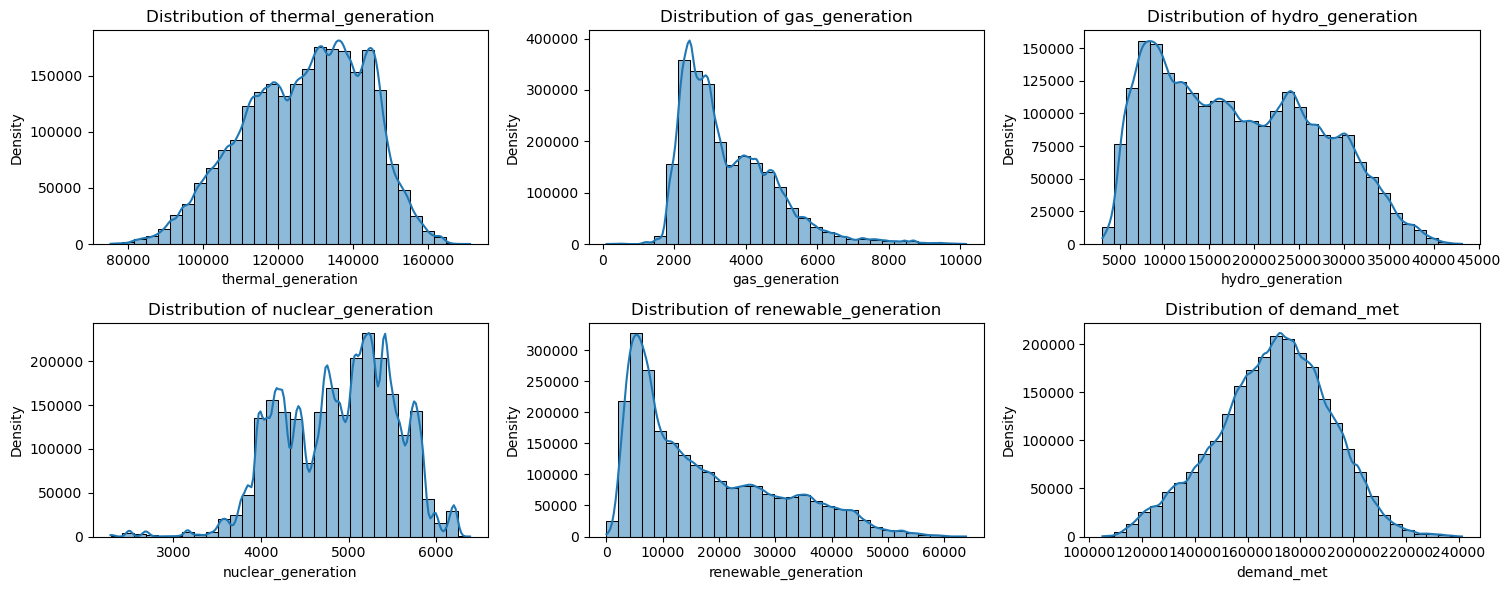

	Distribution of [all_weather_predictor_vars]:


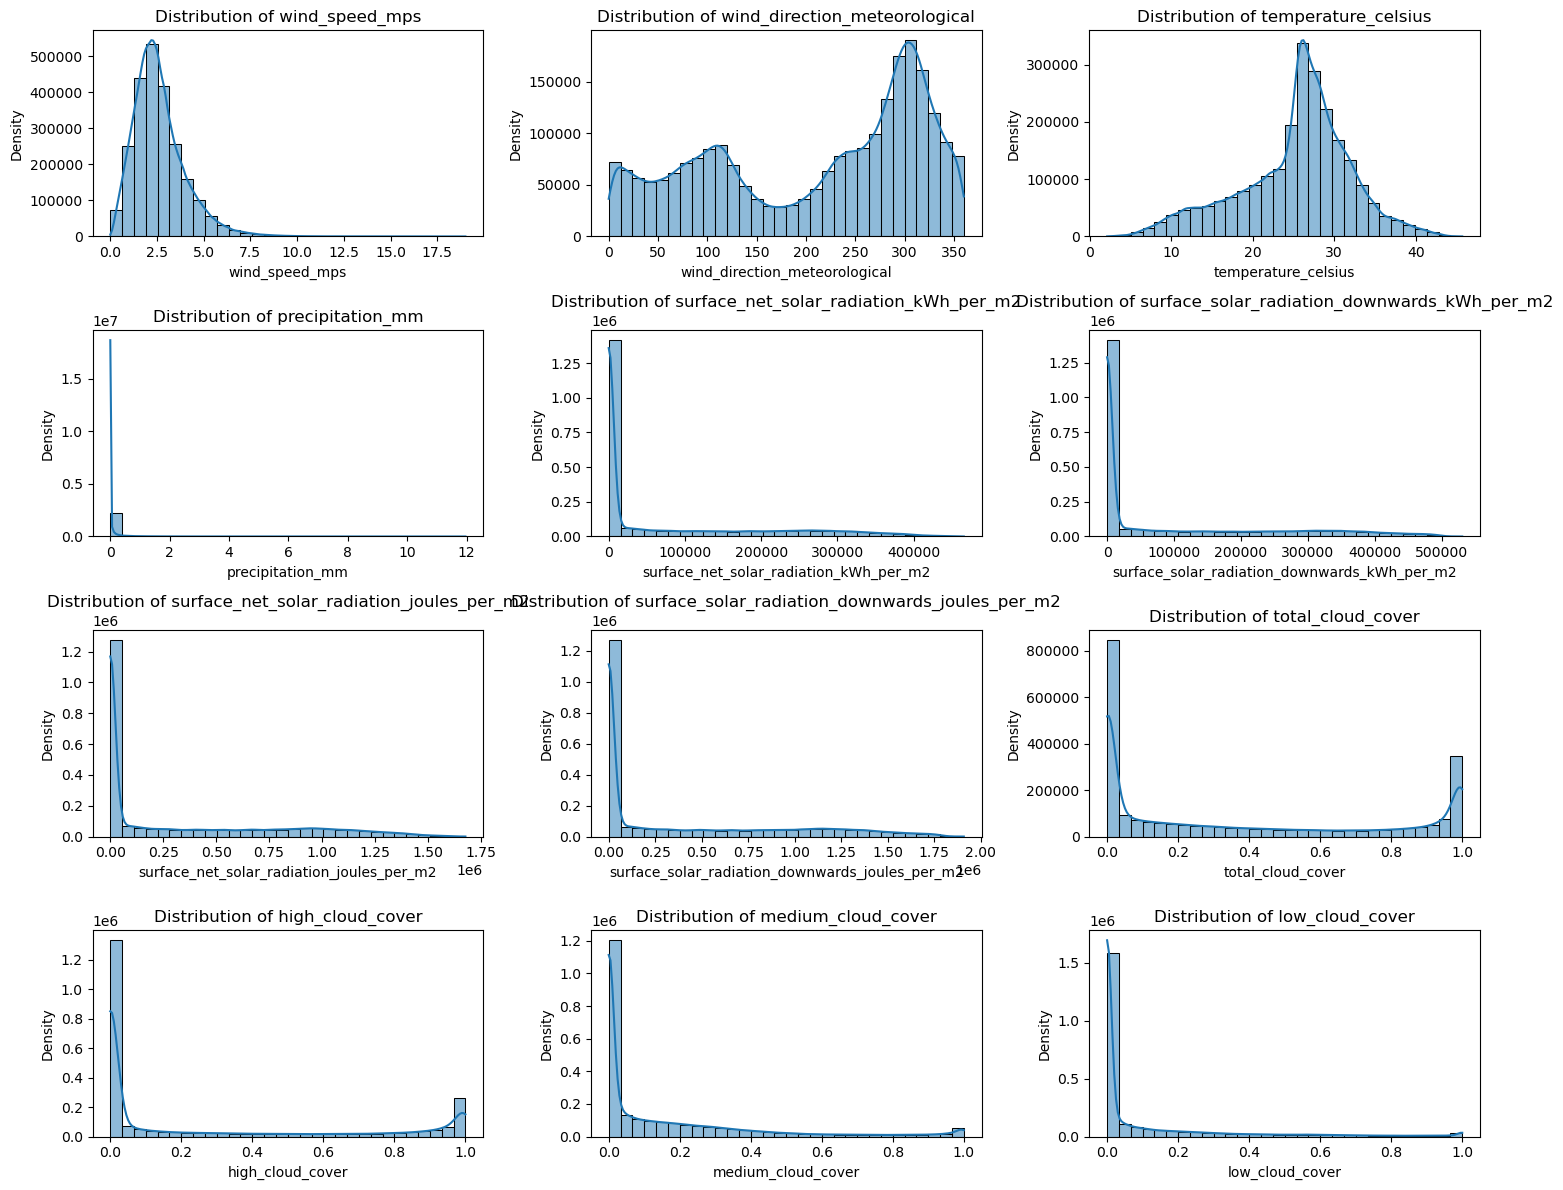

	Distribution of [all_weather_categorical_predictor_vars]:


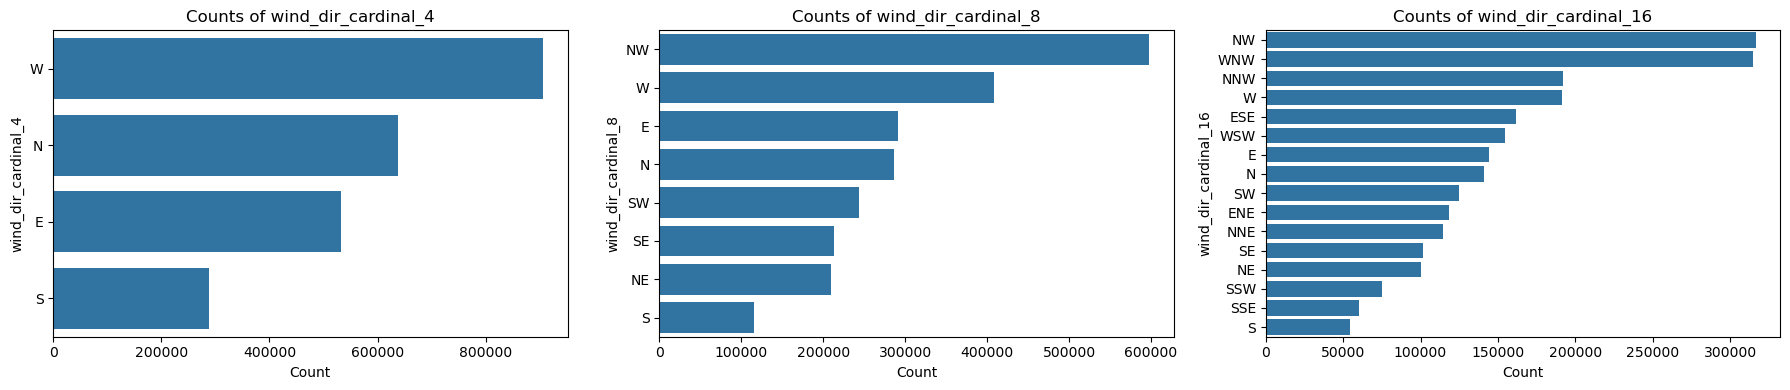

	Distribution of [target_var]:


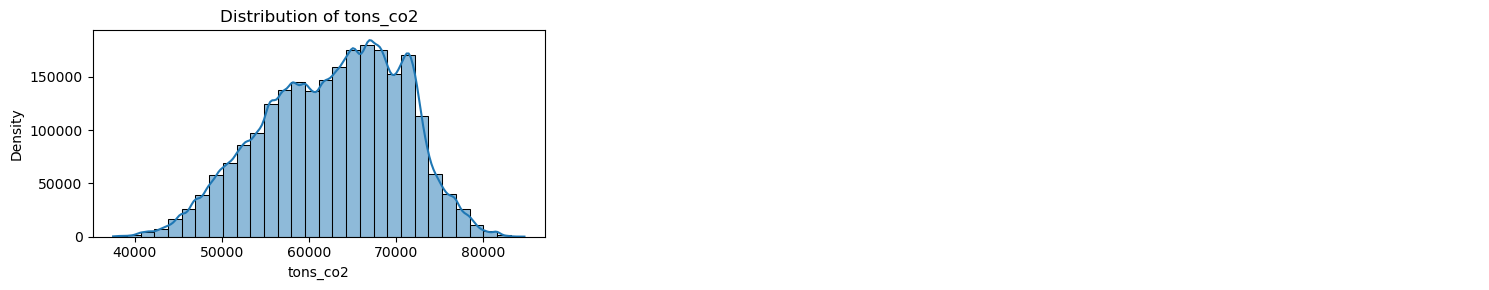

In [57]:
print("-"*120)
print("Data Distribution\n" + "-"*120)

# Numeric distributions
print("\tDistribution of [all_grid_predictor_vars]:")
plot_numeric_distribution(train_df, all_grid_predictor_vars)

print("\tDistribution of [all_weather_predictor_vars]:")
plot_numeric_distribution(train_df, all_weather_predictor_vars)

print("\tDistribution of [all_weather_categorical_predictor_vars]:")
plot_categorical_distribution(train_df, all_weather_categorical_predictor_vars)

print("\tDistribution of [target_var]:")
plot_numeric_distribution(train_df, target_var)

##### Observations:

**Potential Grid Predictor Vars:**
* Thermal generation — roughly unimodal with a mild right-skew, maybe a bimodality around ~125–140k.
* Gas Generation - right-skewed with a long tail and a clear mode near ~2.5–3.5k plus a thinner shoulder to ~5k+. 
    * Looks like a peaking role (rare high outputs).
* Hydro generation — looks bimodal/multimodal: a lower regime (~8–12k) and a higher one (~22–30k) with a long right tail to ~45k. 
* Nuclear generation — highly multimodal with tight peaks (e.g., ~4–5.5k), though an overall normal shape.
* Renewable generation — strongly right-skewed with a heavy mass near 0–10k and a long tail up to ~60k. 
    * Intermittency of solar explain the pile-up at low values.
* Demand met — near-Gaussian around ~170–190k with slight right-skew. 

**Thoughts / Takeways:**
* Gas, Hydro, and Renewables could potentially benefit from log or robust scaling if used in model
* Quantile clipping could help with outliers and heteroskedasticity expected with outliers / events with unusual patterns.
Cross-cutting takeaways

**Potential Weather Predictor Vars:**
* Wind speed (m/s) — strong right-skew with a mode ~2–4 m/s and a long tail to ~15–20. 
* Wind direction (°) — clearly multimodal/circular with preferred sectors (roughly an easterly band and a westerly band). 
* Temperature (°C) — close to unimodal with mild right-skew; looks near-Gaussian around mid-20s
* Precipitation (mm) — zero-inflated with a very heavy right tail (rare intense events).
* Solar radiation (kWh/m², J/m²; downwelling & net) — mass piled at 0 (night) and heavy right-skew during daytime
* Cloud cover (total, high, medium, low; 0–1)
    * Total cloud shows concentration toward 0 and 1 (edge-peaked/bimodal clear vs overcast).
    * Low/Medium/High cloud are highly zero-inflated (many clear-sky hours).
* Wind direction categories: (for 16-bins) NW/ WNW/ NNW are the top three; southern sectors (S, SSE, SSW) are the rarest.

**Thoughts / Takeways:**
* Wind Speed - would expect wind gusts to result in heteroskedasticity - log1p or robust scaling as a potential solution.
* Wind Direction - treat as a circular variable (sine/cosine or vector form)
* Temperature - Could use standard scaler, in combination with season/hour features could be effective predictor
* Precipitation - Use log1p or potentially look into modeling with a separate vars for occurrence and intensity
* Solar Radiation - For advanced processing may want to consider using day/night masks, log1p for daytime values, and interaction variables with hour, month, day of year?
* Cloud Cover - Bounded nature could be problematic in certain models - good for trees, but could use beta-style transforms in linear or neural net.
* Wind Direction - Consider using sine/cosine transformations to capture circular nature - one-hot encoding would be imbalanced. May also want to use season interactions.

**tons_co2**
* Unimodal with slight right skew, near Gaussian.
* Range roughly ~40k–85k, mass concentrated around ~60–70k; no clear multi-modality.
* Likely don't need transformation.

Now let's visualise a few things based on these observations

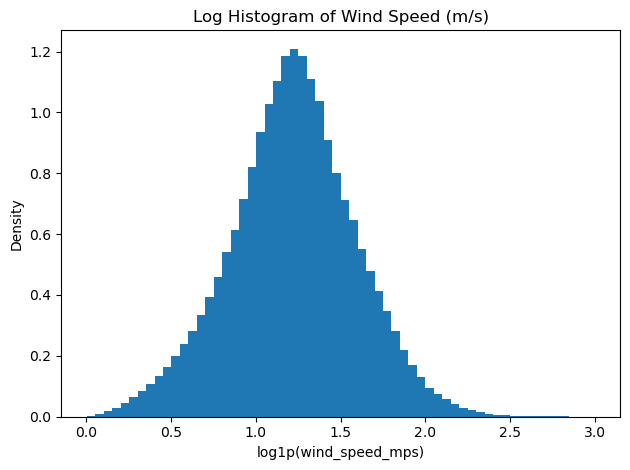

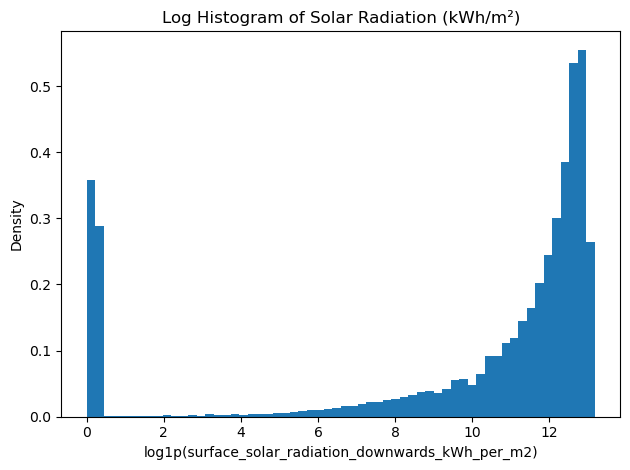

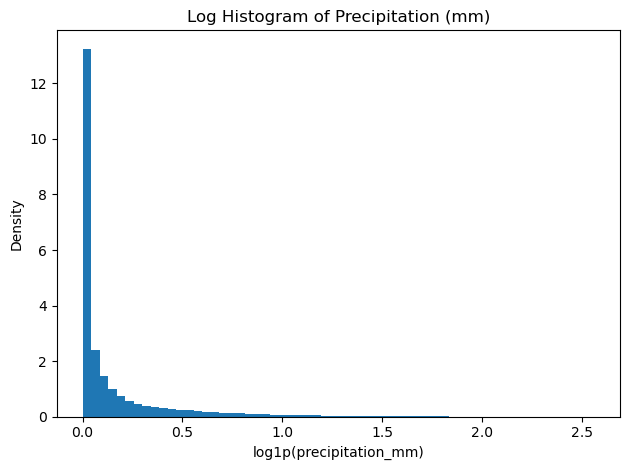

In [66]:
plot_log_hist(train_df, "wind_speed_mps", positive_only=True, bins=60, title="Log Histogram of Wind Speed (m/s)")
plot_log_hist(train_df,"surface_solar_radiation_downwards_kWh_per_m2", positive_only=True,bins=60, title="Log Histogram of Solar Radiation (kWh/m²)",)
plot_log_hist(train_df,"precipitation_mm",positive_only=True,bins=60,title="Log Histogram of Precipitation (mm)",)

We notice that wind speed responded very well to the log transformation.
Precipitation still showing some skew, albeit less than before.
Solar appears to be heavily influenced by it's 0 values - could be worth looking at daytime only values.

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_82546/1500569141.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(["season", "hour"])[col]


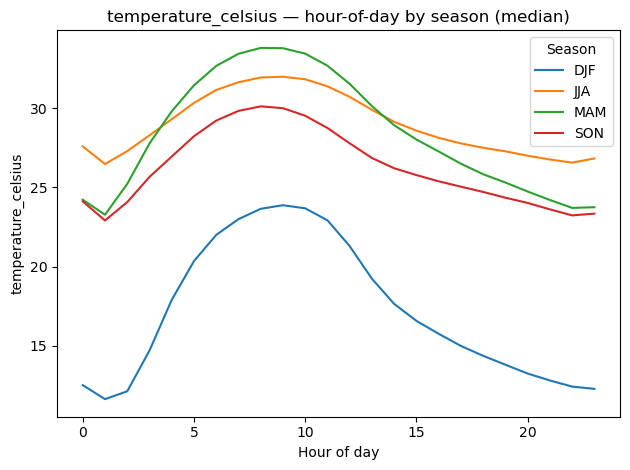

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_82546/1500569141.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(["season", "hour"])[col]


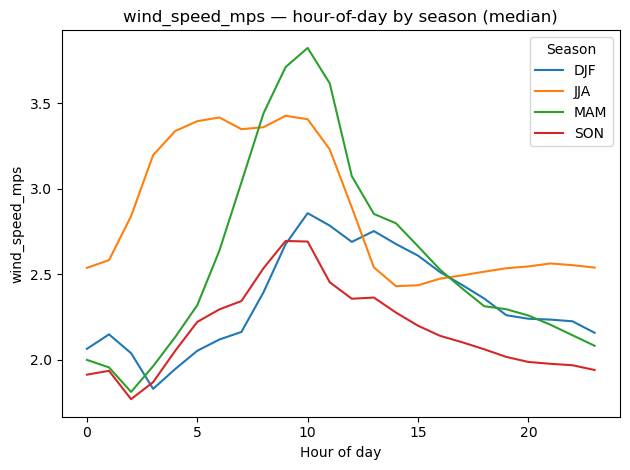

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_82546/1500569141.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(["season", "hour"])[col]


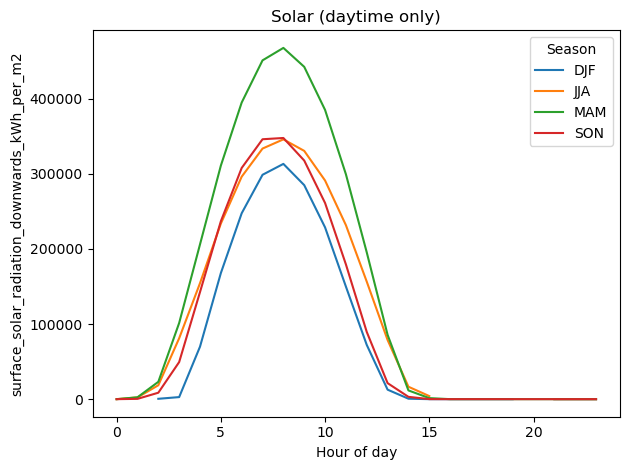

In [ ]:
plot_hourly_by_season(train_df, "temperature_celsius", agg="median")
plot_hourly_by_season(train_df, "wind_speed_mps", agg="median")
plot_hourly_by_season(train_df, "surface_solar_radiation_downwards_kWh_per_m2", agg="median", mask_positive=True, title="Solar (daytime only)")

We notice that temperature is relatively consistent diurnal pattern, and stays at similar levels except for the winter months where it drops significantly.
We notice that wind direction shows a clear diurnal pattern, with distinct differences between seasons.
Solar obviously a strong diurnal pattern, with peaks around noon and very low values at night. Much higher values in MAM than JJA interestingly.


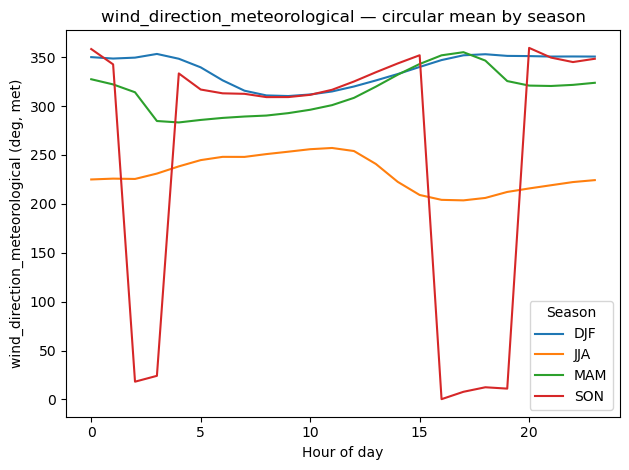

In [71]:
plot_wind_dir_hourly_by_season(train_df, dir_col="wind_direction_meteorological",
                               speed_col="wind_speed_mps", weighted=True)

Wind appears to primarily come from 225 to 20 degrees, so primarily in the range of SW to NNE


#### Skewness and Kurtosis

------------------------------------------------------------------------------------------------------------------------
Skewness and Kurtosis
------------------------------------------------------------------------------------------------------------------------
	Skewness and kurtosis of [all_grid_predictor_vars]:


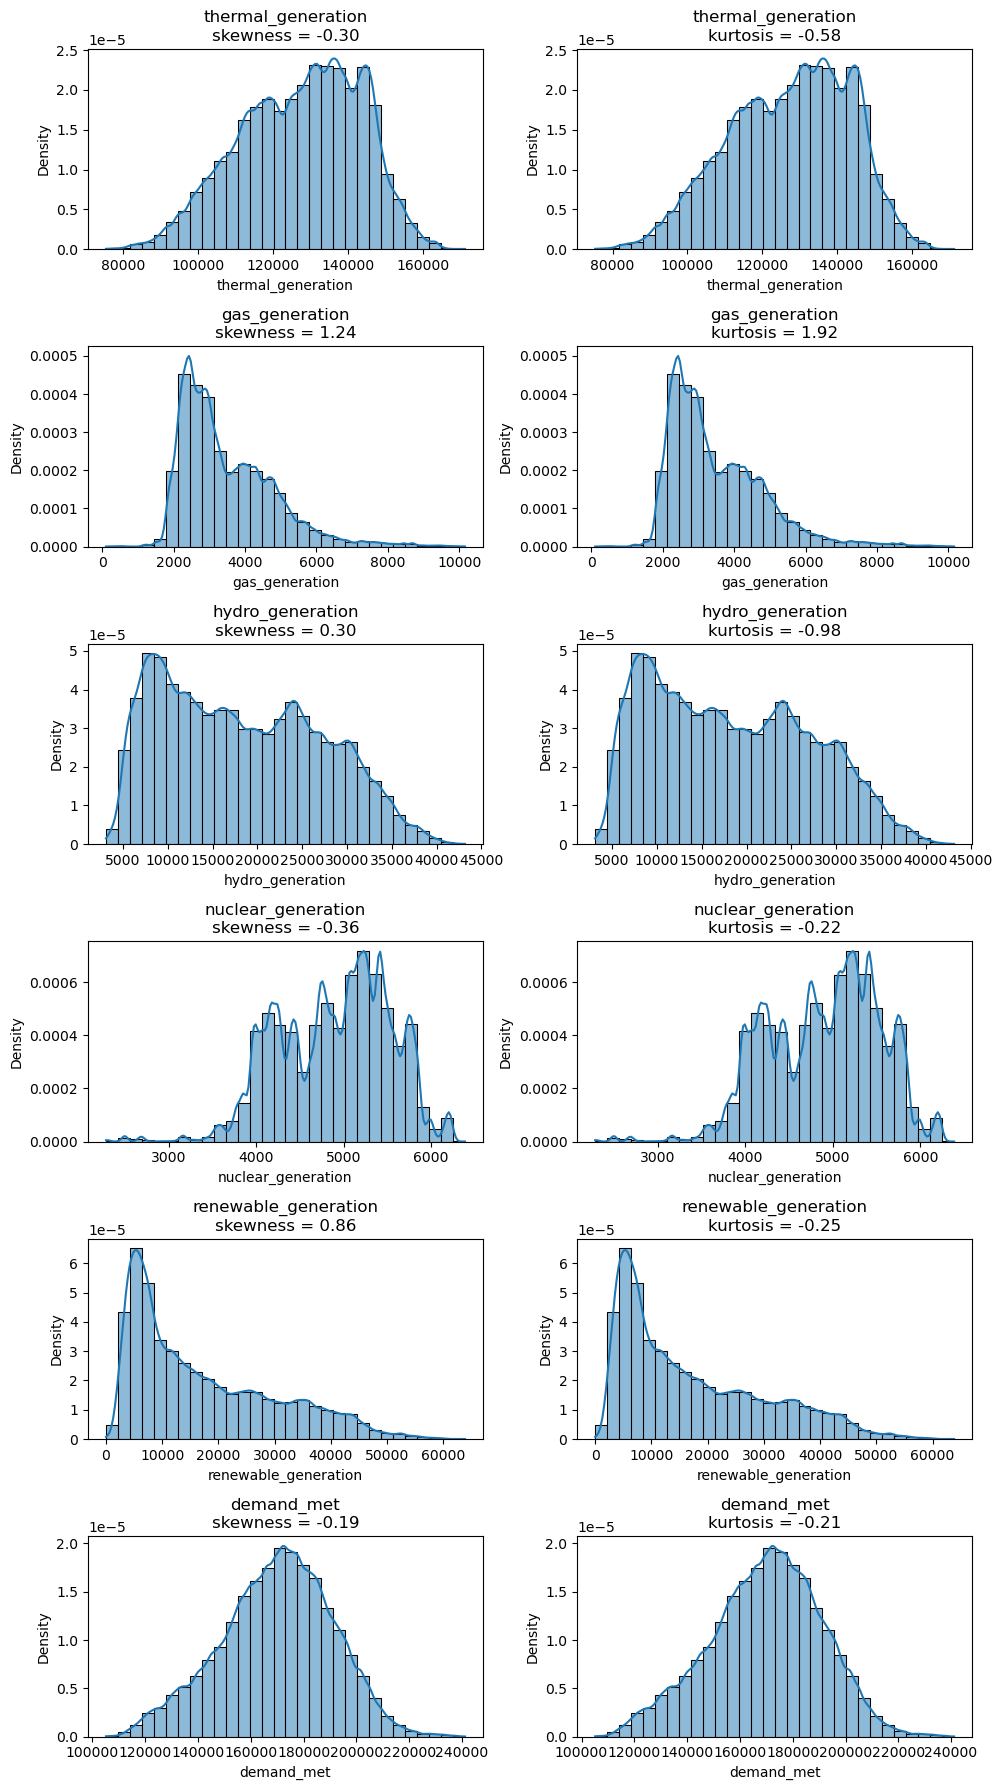

skewness  kurtosis
thermal_generation   -0.296275 -0.575274
gas_generation        1.242435  1.921334
hydro_generation      0.297002 -0.983902
nuclear_generation   -0.363766 -0.222895
renewable_generation  0.862602 -0.253575
demand_met           -0.188051 -0.205274

In [72]:
print("-"*120)
print("Skewness and Kurtosis\n" + "-"*120)

print("\tSkewness and kurtosis of [all_grid_predictor_vars]:")
skew_kurtosis_checker(
    train_df, all_grid_predictor_vars,
    display_table=False,
    plot_distributions=True
)


	Skewness and kurtosis of [all_weather_predictor_vars]:


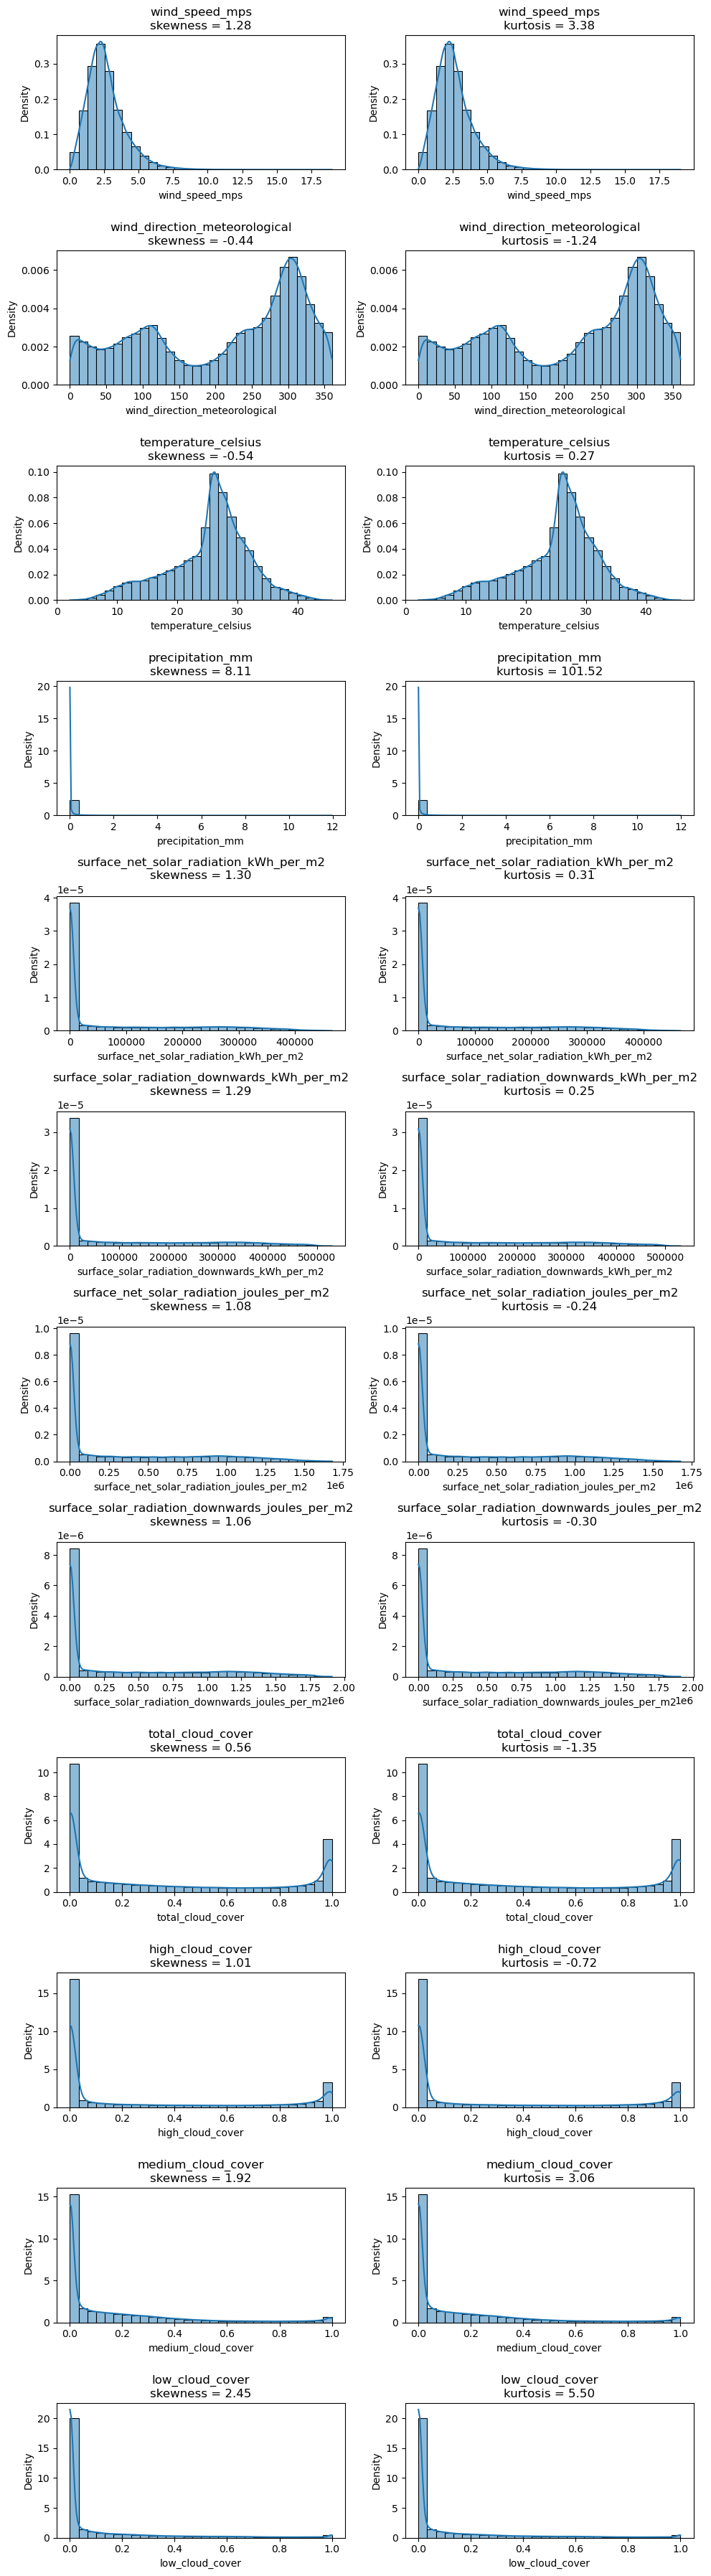

skewness    kurtosis
wind_speed_mps                                   1.283054    3.383781
wind_direction_meteorological                   -0.444597   -1.236914
temperature_celsius                             -0.542890    0.270307
precipitation_mm                                 8.107990  101.519232
surface_net_solar_radiation_kWh_per_m2           1.301256    0.314893
surface_solar_radiation_downwards_kWh_per_m2     1.286911    0.249515
surface_net_solar_radiation_joules_per_m2        1.079263   -0.239052
surface_solar_radiation_downwards_joules_per_m2  1.061932   -0.304588
total_cloud_cover                                0.559178   -1.347402
high_cloud_cover                                 1.013264   -0.716362
medium_cloud_cover                               1.919929    3.061811
low_cloud_cover                                  2.448713    5.500897

In [73]:
print("\tSkewness and kurtosis of [all_weather_predictor_vars]:")
skew_kurtosis_checker(
    train_df, all_weather_predictor_vars,
    display_table=False,
    plot_distributions=True
)

	Skewness and kurtosis of [target_var]:

------------------------------------------------------------------------------------------------------------------------
Skewness and Kurtosis:
------------------------------------------------------------------------------------------------------------------------


skewness  kurtosis
tons_co2 -0.274658 -0.555677

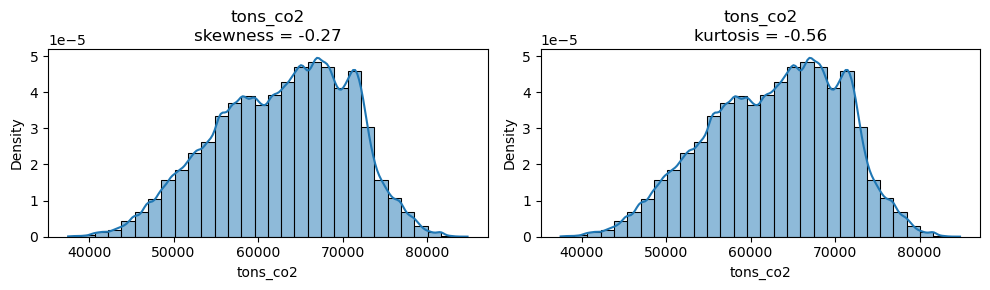

skewness  kurtosis
tons_co2 -0.274658 -0.555677

In [39]:
print("\tSkewness and kurtosis of [target_var]:")
skew_kurtosis_checker(
    train_df, target_var,
    display_table=True,
    plot_distributions=True
)

##### Summary

**Grid predictors**
* thermal_generation (skew −0.30, kurt −0.58)
    * Skew: mild left skew; confirms near-symmetric with slightly heavier lower side.
    * Kurtosis: platykurtic (lighter tails); supports “well-behaved base-load” view.
    * Recommendations: standardize; watch cold/holiday dips but no transform needed.

* gas_generation (1.24, 1.92)
    * Skew: strong right skew; confirms peaking/rare surges.
    * Kurtosis: leptokurtic; heavy tail from spike events.
    * Recommendations: log1p or winsorize top 0.5–1%; add event/peak indicators.

* hydro_generation (0.30, −0.98)
    * Skew: slight right skew; consistent with higher monsoon plateaus.
    * Kurtosis: strongly platykurtic; broad/flat mixture rather than spiky tails.
    * Recommendations: model season/monsoon explicitly; transformation optional.

* nuclear_generation (−0.36, −0.22)
    * Skew: mild left skew; outages/derates on the low side.
    * Kurtosis: slightly platykurtic; few extreme excursions.
    * Recommendations: add outage/maintenance flags if available; otherwise leave raw.

* renewable_generation (0.86, −0.25)
    * Skew: clear right skew; matches intermittent/high bursts.
    * Kurtosis: near-normal to slightly light-tailed.
    * Recommendations: log1p helps linear models; add day/night & cloud/solar interactions.

* demand_met (−0.19, −0.21)
    * Skew: near-symmetric, tiny left lean.
    * Kurtosis: near-normal, slightly light-tailed.
    * Recommendations: standardize; capture calendar×temperature interactions.


**Weather predictors**

* wind_speed_mps (1.28, 3.38)
    * Skew: strong right skew; gusts.
    * Kurtosis: very heavy tails; extreme gust events.
    * Recommendations: log1p/Yeo–Johnson for linear models; keep raw for trees; consider quantile loss.
* wind_direction_meteorological (−0.45, −1.24)
    * Skew: not meaningful (circular variable).
    * Kurtosis: not meaningful for degrees on a circle.
    * Recommendations: encode as sin/cos (or u/v with speed); optional sector dummies for interpretability.

* temperature_celsius (−0.54, 0.27)
    * Skew: modest left skew; cold excursions larger than hot.
    * Kurtosis: slight leptokurtosis; occasional cold extremes.
    * Recommendations: standardize; include season/hour features and interactions with demand/solar.

* precipitation_mm (8.11, 101.52)
    * Skew: extreme right; zero-inflated with rare heavy rain.
    * Kurtosis: enormous; intensity outliers dominate.
    * Recommendations: two-part model (occurrence + intensity) or log1p(>0)+indicator; evaluate with quantile/Huber losses.

* surface_net_solar_radiation_kWh_per_m2 (1.30, 0.31), surface_solar_radiation_downwards_kWh_per_m2 (1.29, 0.25), surface_net_solar_radiation_joules_per_m2 (1.08, −0.24), surface_solar_radiation_downwards_joules_per_m2 (1.06, −0.30)
    * Skew: consistent right skew; daytime dominance + night zeros.
    * Kurtosis: near-normal to slightly light-tailed overall (mixture smooths extremes).
    * Recommendations: add day/night mask; use log1p on daytime values if modeling linearly; keep raw for trees; include hour×month interactions.

* total_cloud_cover (0.56, −1.35)
    * Skew: mild right (more high-cloud cases).
    * Kurtosis: strongly platykurtic due to bounded/U-shape (piles near 0 and 1).
    * Recommendations: trees handle raw; for linear/NNS, consider logit transform after clamping to [ε,1−ε].
* high_cloud_cover (1.01, −0.72)
    * Skew: right; many zeros with some high events.
    * Kurtosis: slightly light-tailed overall (bounded).
    * Recommendations: leave raw for trees; logit-transform if used in linear models.
* medium_cloud_cover (1.92, 3.06)
    * Skew: strong right; lots of near-zero hours.
    * Kurtosis: heavy tails; sporadic thick mid-level decks.
    * Recommendations: zero-inflated/Beta-inflated style if model directly; else raw for trees + season interactions.
* low_cloud_cover (2.45, 5.50)
    * Skew: very right-skewed; near-zero most of the time.
    * Kurtosis: very heavy tails; occasional overcast bursts.
    * Recommendations: treat as zero-inflated bounded variable; for linear/NNS use logit(ε-clamped) or model occurrence + amount.

**tons_co2 (−0.27, −0.56)**
* Skew: slight left skew; mostly symmetric outcome distribution.
* Kurtosis: platykurtic; fewer extreme events than Normal.
* Recommendations: standardize; ordinary squared-error is fine; still check residuals by season/wind regime.

#### Correlation and Colinearities

In [79]:
all_grid_predictor_vars = [
    "thermal_generation",
    "gas_generation",
    "hydro_generation",
    "nuclear_generation",
    "renewable_generation",
    # "total_generation",
    "demand_met",
    # "non_renewable_generation",
    # "g_co2_per_kwh",
    # "tons_co2_per_mwh",
]

# Note we exclude 'g_co2_per_kwh', 'tons_co2_per_mwh'
# - Because they are used to calulate the target variable 'tons_co2'
# We also exclude non_renewable_generation because it is derived from the other variables

all_weather_predictor_vars = [
    'wind_speed_mps',
    'wind_direction_meteorological',
    'temperature_celsius',
    'precipitation_mm',
    'surface_net_solar_radiation_kWh_per_m2',
    'surface_solar_radiation_downwards_kWh_per_m2',
    'surface_net_solar_radiation_joules_per_m2',
    'surface_solar_radiation_downwards_joules_per_m2',
    'total_cloud_cover',
    'high_cloud_cover',
    'medium_cloud_cover',
    'low_cloud_cover',
]

all_weather_categorical_predictor_vars = [
    'wind_dir_cardinal_4',
    'wind_dir_cardinal_8',
    'wind_dir_cardinal_16',
]

target_var = ["tons_co2"]


------------------------------------------------------------------------------------------------------------------------
Correlation Matrix of Combined DataFrame:
------------------------------------------------------------------------------------------------------------------------


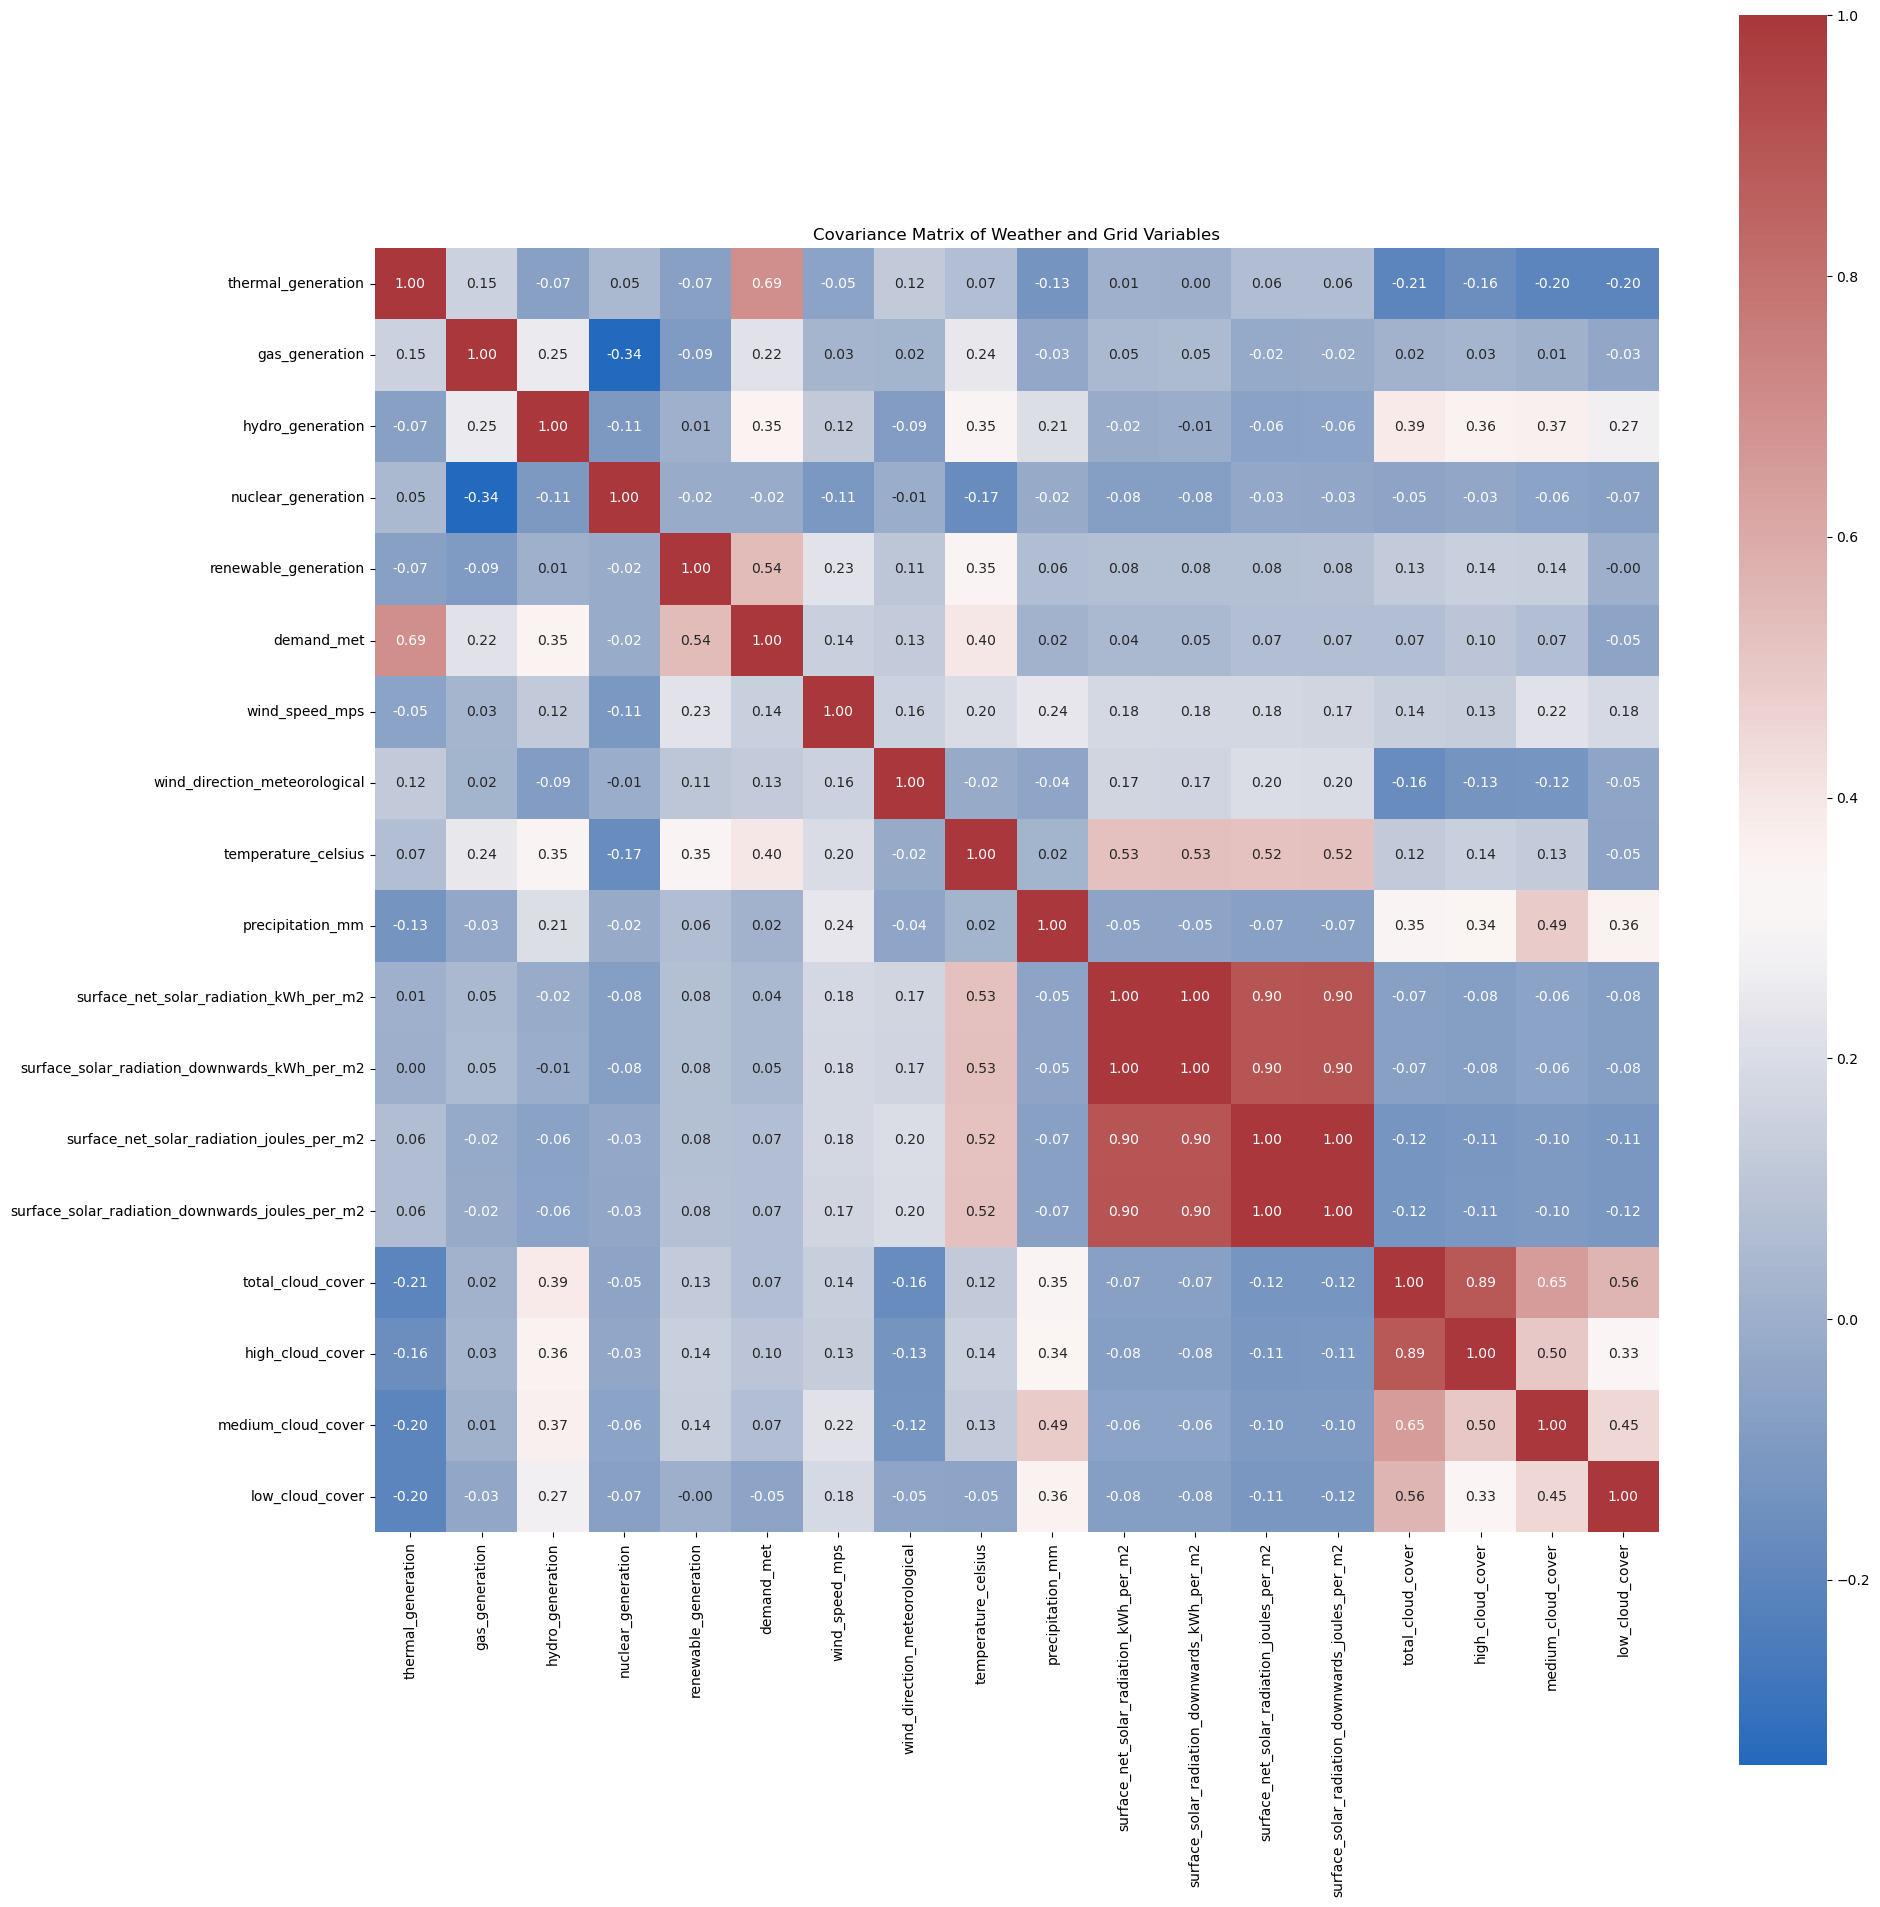

In [80]:
# Check the correlation matrix of the combined DataFrame
print("\n" + "-" * 120)
print("Correlation Matrix of Combined DataFrame:\n" + "-" * 120)
corr_df = (train_pldf.select(
    pl.col( all_grid_predictor_vars + all_weather_predictor_vars),
).to_pandas()
)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    square=True
)
plt.title("Covariance Matrix of Weather and Grid Variables")
plt.tight_layout()
plt.show()

In [81]:
# Add constant (intercept)
X = sm.add_constant(corr_df)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                                           Variable          VIF
0                                             const   173.892971
1                                thermal_generation   164.545906
2                                    gas_generation     2.784714
3                                  hydro_generation    47.128619
4                                nuclear_generation     1.320837
5                              renewable_generation   105.968904
6                                        demand_met   289.181095
7                                    wind_speed_mps     1.256475
8                     wind_direction_meteorological     1.166627
9                               temperature_celsius     2.499329
10                                 precipitation_mm     1.506777
11           surface_net_solar_radiation_kWh_per_m2  2465.606513
12     surface_solar_radiation_downwards_kWh_per_m2  2616.739648
13        surface_net_solar_radiation_joules_per_m2  2301.589851
14  surface_solar_radiati

**NOTES**

At this point we notice a few things:
- very high values for the solar fields
- high values for some of the generation fields
- a higher than normal value for total_cloud_cover.


For dealing with the solar colinearity:
- this is expected because the raw values are roughly the same, they are just different units and so may be subject to rounding issues
- I recommend keeping the 'surface_net_solar_radiation_kwh_m2' for interpretability

For dealing with the generation colinearity:
- We may want to experiment with either dropping all of the generation values, or creating generation 'shares' and potentially dropping one of the categories.

For dealing with the cloud cover colinearity:
- We could drop the high, med and low cloud cover variables or we could drop the total cloud cover.
- Dropping just the one will allow us to keep more variables, but may also be adding noise to the model instead of retaining a single, more impactful feature. As a first test I recommend dropping the total cloud cover variable and keeping the additional variables


##### Dropping Weather Predictor Variables

In [102]:
weather_predictor_colinear_columns_to_drop = [
    # Highly correlated with surface_net_solar_radiation_kwh_m2
    'surface_solar_radiation_downwards_kWh_per_m2',
    'surface_net_solar_radiation_joules_per_m2',
    'surface_solar_radiation_downwards_joules_per_m2',
    'total_cloud_cover', # highly correlated with the other cloud cover variables, but when we drop this one, the others all maintain low VIFs
    # 'high_cloud_cover',  # Highly correlated with total_cloud_cover
    # 'medium_cloud_cover',  # Highly correlated with total_cloud_cover
    # 'low_cloud_cover',  # Highly correlated with total_cloud_cover
]

reduced_weather_predictor_vars = [col for col in all_weather_predictor_vars if col not in weather_predictor_colinear_columns_to_drop]

In [103]:
print(f"Remaining_cols: {reduced_weather_predictor_vars}")

Remaining_cols: ['wind_speed_mps', 'wind_direction_meteorological', 'temperature_celsius', 'precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover']



------------------------------------------------------------------------------------------------------------------------
Correlation Matrix of Combined DataFrame:
------------------------------------------------------------------------------------------------------------------------


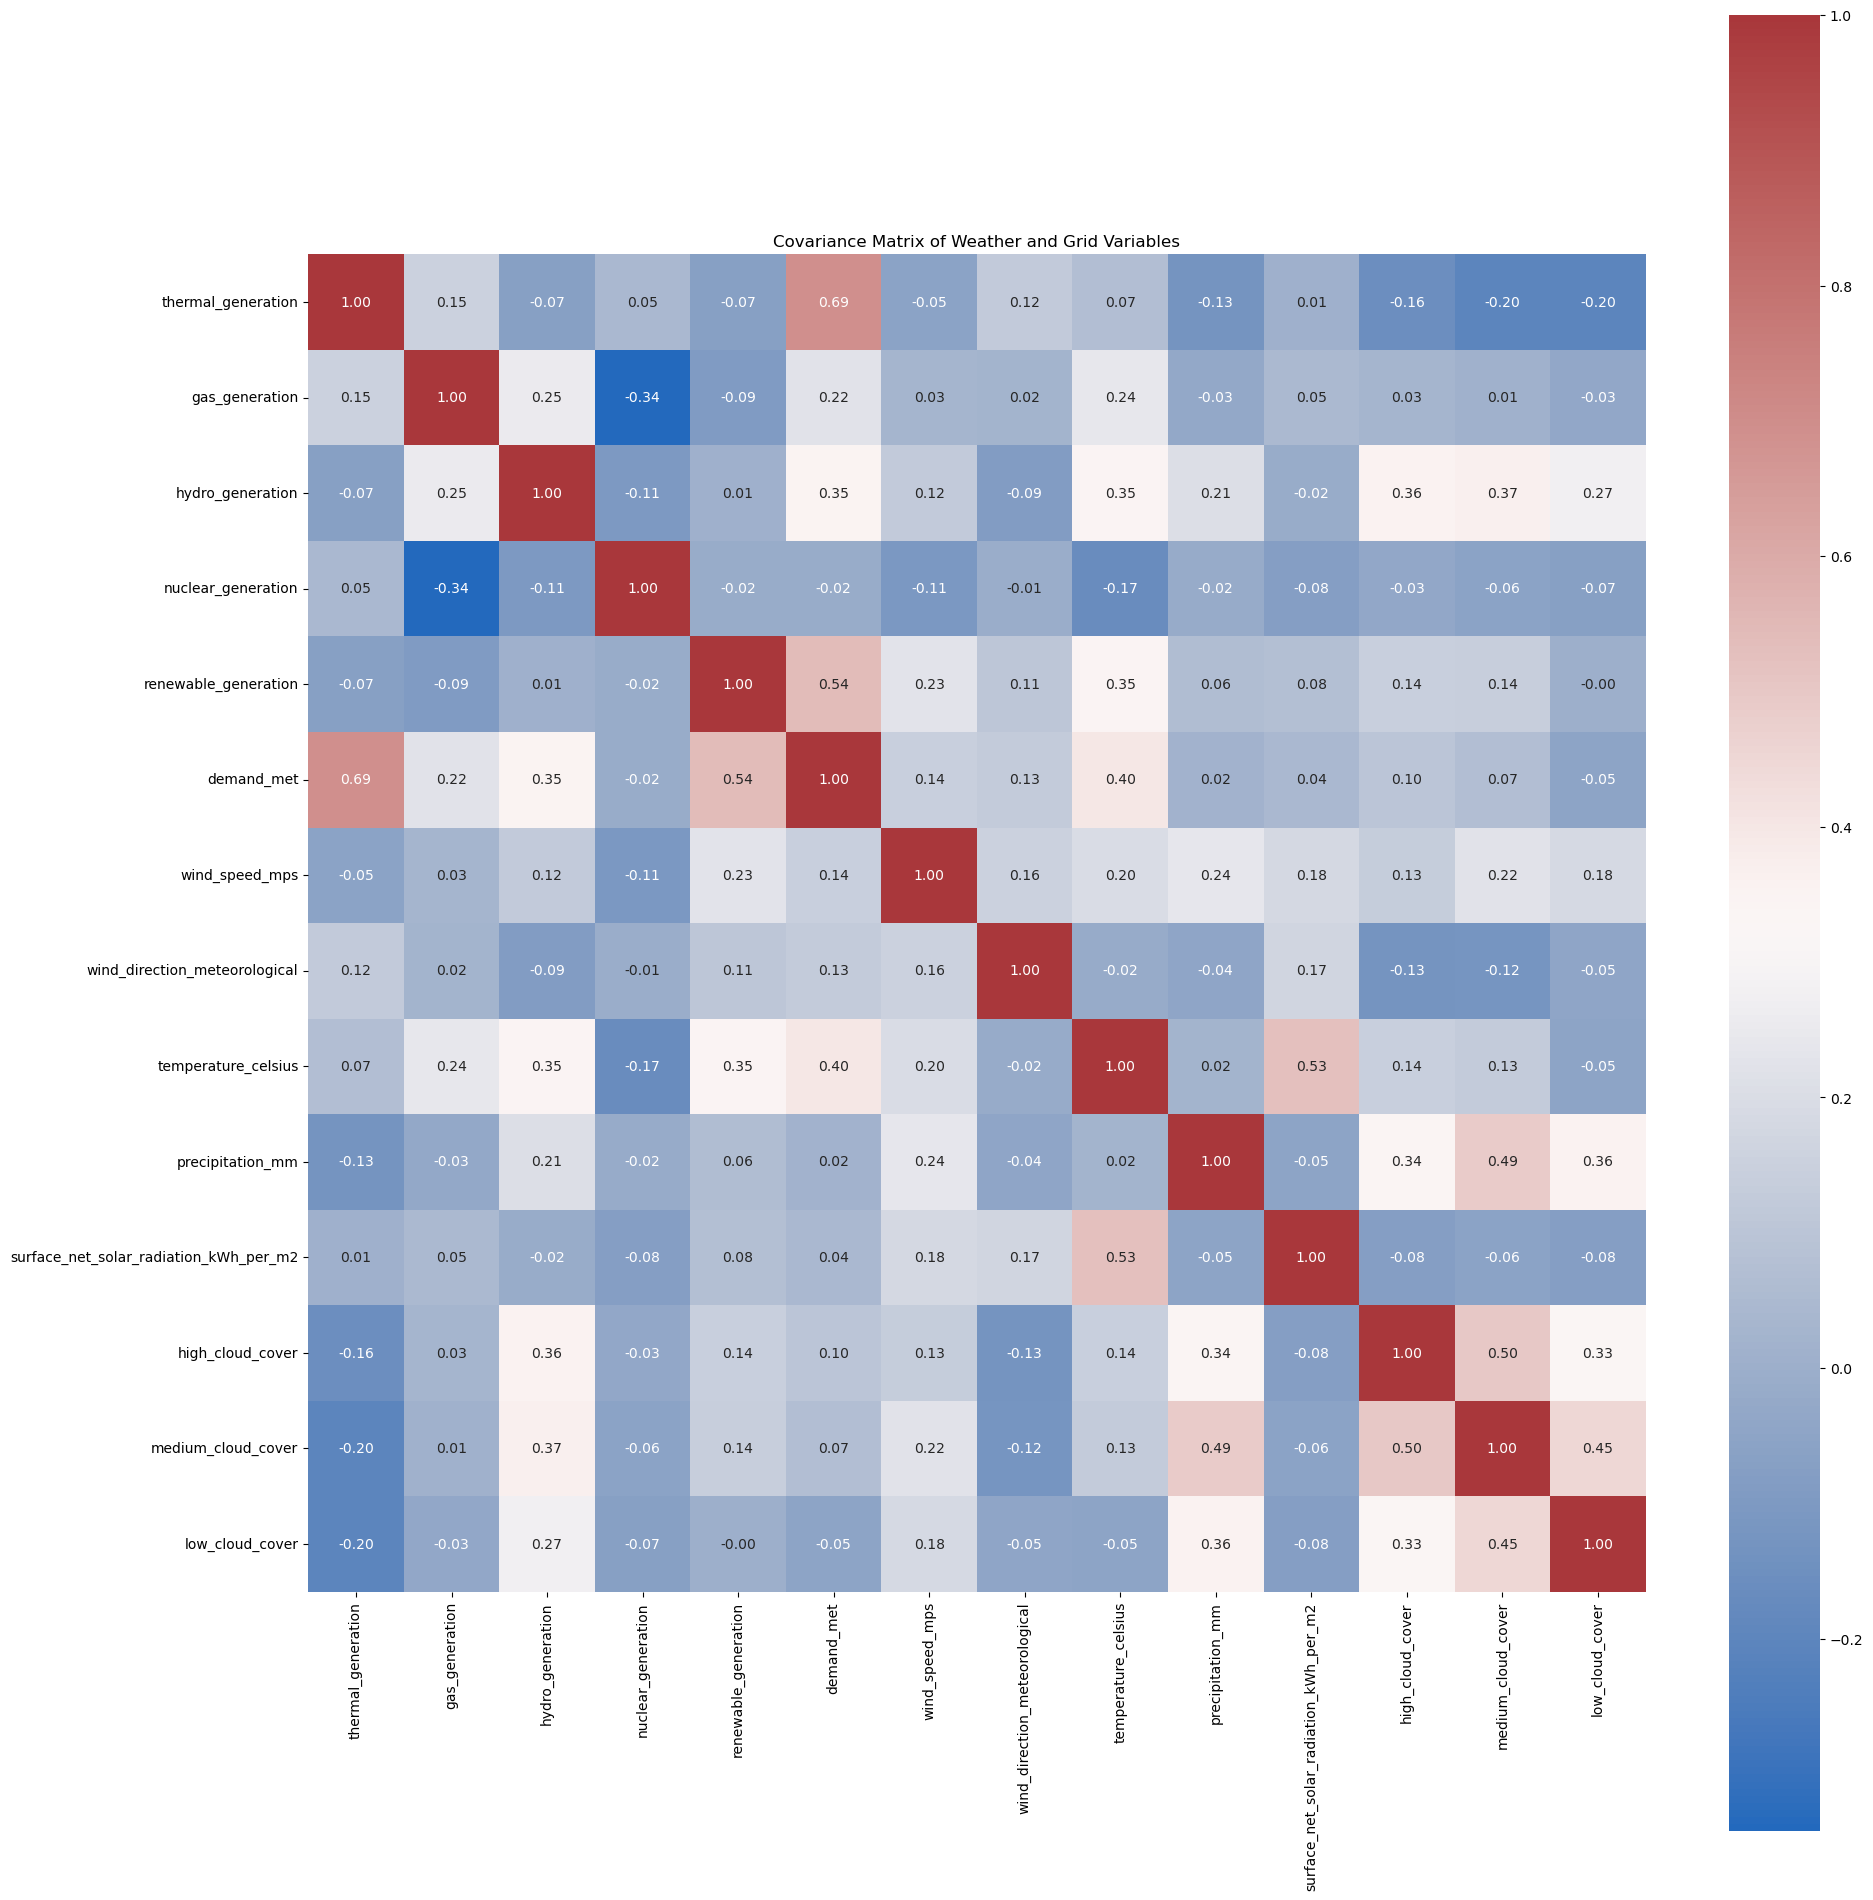

In [104]:
# Check the correlation matrix of the combined DataFrame
print("\n" + "-" * 120)
print("Correlation Matrix of Combined DataFrame:\n" + "-" * 120)
corr_df = (train_pldf.select(
    pl.col( all_grid_predictor_vars + reduced_weather_predictor_vars),
).to_pandas()
)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    square=True
)
plt.title("Covariance Matrix of Weather and Grid Variables")
plt.tight_layout()
plt.show()

In [85]:
# Add constant (intercept)
X = sm.add_constant(corr_df)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                                  Variable         VIF
0                                    const  170.922805
1                       thermal_generation  164.210947
2                           gas_generation    2.721230
3                         hydro_generation   46.903942
4                       nuclear_generation    1.319051
5                     renewable_generation  105.596921
6                               demand_met  288.458084
7                           wind_speed_mps    1.216556
8            wind_direction_meteorological    1.137916
9                      temperature_celsius    2.311318
10                        precipitation_mm    1.410122
11  surface_net_solar_radiation_kWh_per_m2    1.675002
12                        high_cloud_cover    1.475052
13                      medium_cloud_cover    1.821601
14                         low_cloud_cover    1.413030


Now lets compare to dropping the high, med and low cloud cover variables.

In [105]:
weather_predictor_colinear_columns_to_drop_test = [
    # Highly correlated with surface_net_solar_radiation_kwh_m2
    'surface_solar_radiation_downwards_kWh_per_m2',
    'surface_net_solar_radiation_joules_per_m2',
    'surface_solar_radiation_downwards_joules_per_m2',
    # 'total_cloud_cover', # highly correlated with the other cloud cover variables, but when we drop this one, the others all maintain low VIFs
    'high_cloud_cover',  # Highly correlated with total_cloud_cover
    'medium_cloud_cover',  # Highly correlated with total_cloud_cover
    'low_cloud_cover',  # Highly correlated with total_cloud_cover
]

reduced_weather_predictor_vars_test = [col for col in all_weather_predictor_vars if col not in weather_predictor_colinear_columns_to_drop_test]


------------------------------------------------------------------------------------------------------------------------
Correlation Matrix of Combined DataFrame:
------------------------------------------------------------------------------------------------------------------------


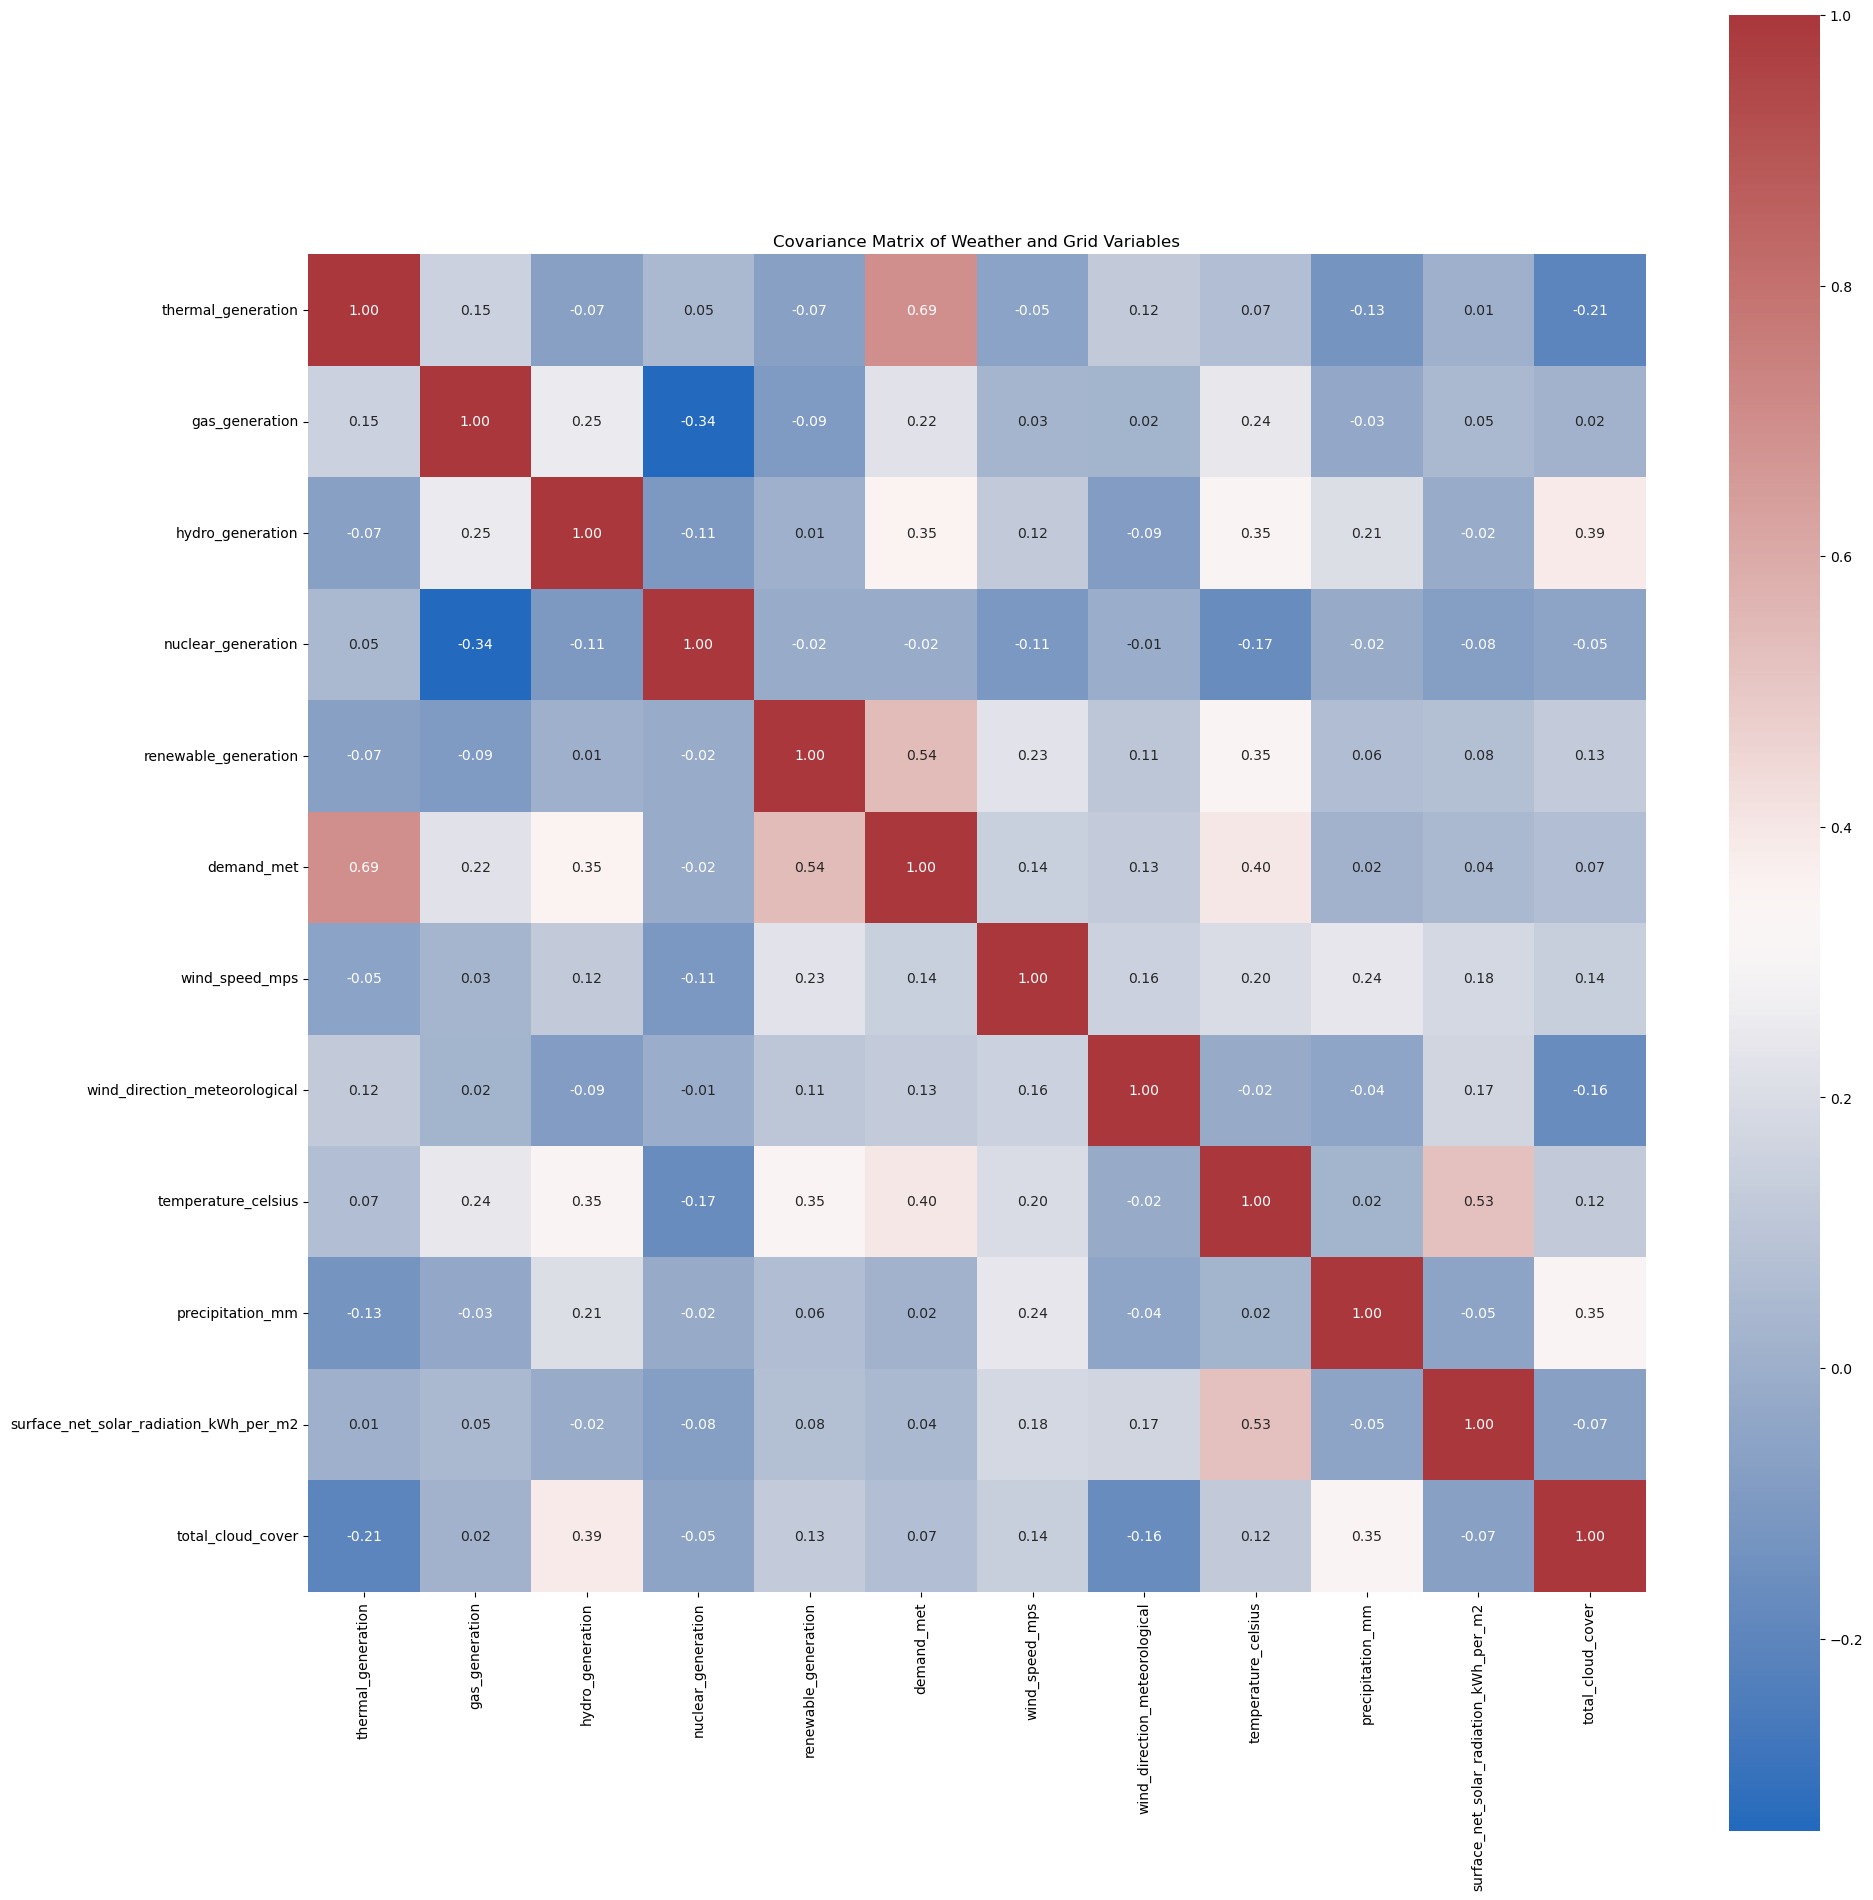

In [106]:
# Check the correlation matrix of the combined DataFrame
print("\n" + "-" * 120)
print("Correlation Matrix of Combined DataFrame:\n" + "-" * 120)
corr_df = (train_pldf.select(
    pl.col( all_grid_predictor_vars + reduced_weather_predictor_vars_test),
).to_pandas()
)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    square=True
)
plt.title("Covariance Matrix of Weather and Grid Variables")
plt.tight_layout()
plt.show()

In [107]:
# Add constant (intercept)
X = sm.add_constant(corr_df)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                                  Variable         VIF
0                                    const  168.523939
1                       thermal_generation  164.041480
2                           gas_generation    2.721179
3                         hydro_generation   46.663553
4                       nuclear_generation    1.314610
5                     renewable_generation  105.463026
6                               demand_met  287.986893
7                           wind_speed_mps    1.195429
8            wind_direction_meteorological    1.141854
9                      temperature_celsius    2.262093
10                        precipitation_mm    1.208635
11  surface_net_solar_radiation_kWh_per_m2    1.666831
12                       total_cloud_cover    1.386033


We see that this actually yields a lower single VIF score for total_cloud_cover than any of the other cloud cover variables, indicating that it is less collinear with the other predictors. We'll keep this approach for now.

##### Dropping Grid Predictor Variables

In [ ]:
# lets create some generation - share variables
train_pldf_enhanced = train_pldf.with_columns(
    (pl.col("thermal_generation") / pl.col("total_generation")).alias("thermal_generation_share"),
    (pl.col("gas_generation") / pl.col("total_generation")).alias("gas_generation_share"),
    (pl.col("hydro_generation") / pl.col("total_generation")).alias("hydro_generation_share"),
    (pl.col("nuclear_generation") / pl.col("total_generation")).alias("nuclear_generation_share"),
    (pl.col("renewable_generation") / pl.col("total_generation")).alias("renewable_generation_share")
)
train_pldf_enhanced

shape: (2_365_200, 35)
┌────────────┬────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ timestamp  ┆ city   ┆ land_latit ┆ land_long ┆ … ┆ gas_gener ┆ hydro_gen ┆ nuclear_g ┆ renewable │
│ ---        ┆ ---    ┆ ude        ┆ itude     ┆   ┆ ation_sha ┆ eration_s ┆ eneration ┆ _generati │
│ datetime[μ ┆ cat    ┆ ---        ┆ ---       ┆   ┆ re        ┆ hare      ┆ _share    ┆ on_share  │
│ s, Asia/Ko ┆        ┆ f64        ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ lkata]     ┆        ┆            ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2021-01-01 ┆ mumbai ┆ 18.5       ┆ 72.97     ┆ … ┆ 0.029308  ┆ 0.056997  ┆ 0.031031  ┆ 0.073093  │
│ 00:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2021-01-01 ┆ mumbai ┆ 18.6       ┆ 72.97     ┆ … ┆ 0.029308  ┆ 0.056997  ┆ 0.031031  ┆ 0.073093  │
│ 00:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2021-01-01 ┆ mumbai ┆ 19.3       ┆ 72.97     ┆ … ┆ 0.029308  ┆ 0.056997  ┆ 0.031031  ┆ 0.073093  │
│ 00:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2021-01-01 ┆ mumbai ┆ 19.1       ┆ 72.87     ┆ … ┆ 0.029308  ┆ 0.056997  ┆ 0.031031  ┆ 0.073093  │
│ 00:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2021-01-01 ┆ mumbai ┆ 18.8       ┆ 72.97     ┆ … ┆ 0.029308  ┆ 0.056997  ┆ 0.031031  ┆ 0.073093  │
│ 00:00:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ …          ┆ …      ┆ …          ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2023-12-31 ┆ delhi  ┆ 28.8       ┆ 76.94     ┆ … ┆ 0.012854  ┆ 0.027396  ┆ 0.038699  ┆ 0.068203  │
│ 23:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2023-12-31 ┆ delhi  ┆ 28.8       ┆ 77.04     ┆ … ┆ 0.012854  ┆ 0.027396  ┆ 0.038699  ┆ 0.068203  │
│ 23:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2023-12-31 ┆ delhi  ┆ 28.8       ┆ 77.14     ┆ … ┆ 0.012854  ┆ 0.027396  ┆ 0.038699  ┆ 0.068203  │
│ 23:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2023-12-31 ┆ delhi  ┆ 28.8       ┆ 77.24     ┆ … ┆ 0.012854  ┆ 0.027396  ┆ 0.038699  ┆ 0.068203  │
│ 23:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2023-12-31 ┆ delhi  ┆ 28.8       ┆ 77.34     ┆ … ┆ 0.012854  ┆ 0.027396  ┆ 0.038699  ┆ 0.068203  │
│ 23:30:00   ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
│ IST        ┆        ┆            ┆           ┆   ┆           ┆           ┆           ┆           │
└────────────┴────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [118]:
grid_share_columns_to_add = [
    "thermal_generation_share",
    "gas_generation_share",
    "hydro_generation_share",
    "nuclear_generation_share",
    "renewable_generation_share",
]

# Adding to grid predictor vars
grid_share_predictor_vars = all_grid_predictor_vars + grid_share_columns_to_add

# removing the original generation columns
to_drop = ["thermal_generation", "gas_generation", "hydro_generation",
           "nuclear_generation", "renewable_generation"]
grid_share_predictor_vars = [
    c for c in (all_grid_predictor_vars + grid_share_columns_to_add)
    if c not in to_drop
]

In [119]:
display(grid_share_predictor_vars)

['demand_met',
 'thermal_generation_share',
 'gas_generation_share',
 'hydro_generation_share',
 'nuclear_generation_share',
 'renewable_generation_share']


------------------------------------------------------------------------------------------------------------------------
Correlation Matrix of Combined DataFrame:
------------------------------------------------------------------------------------------------------------------------


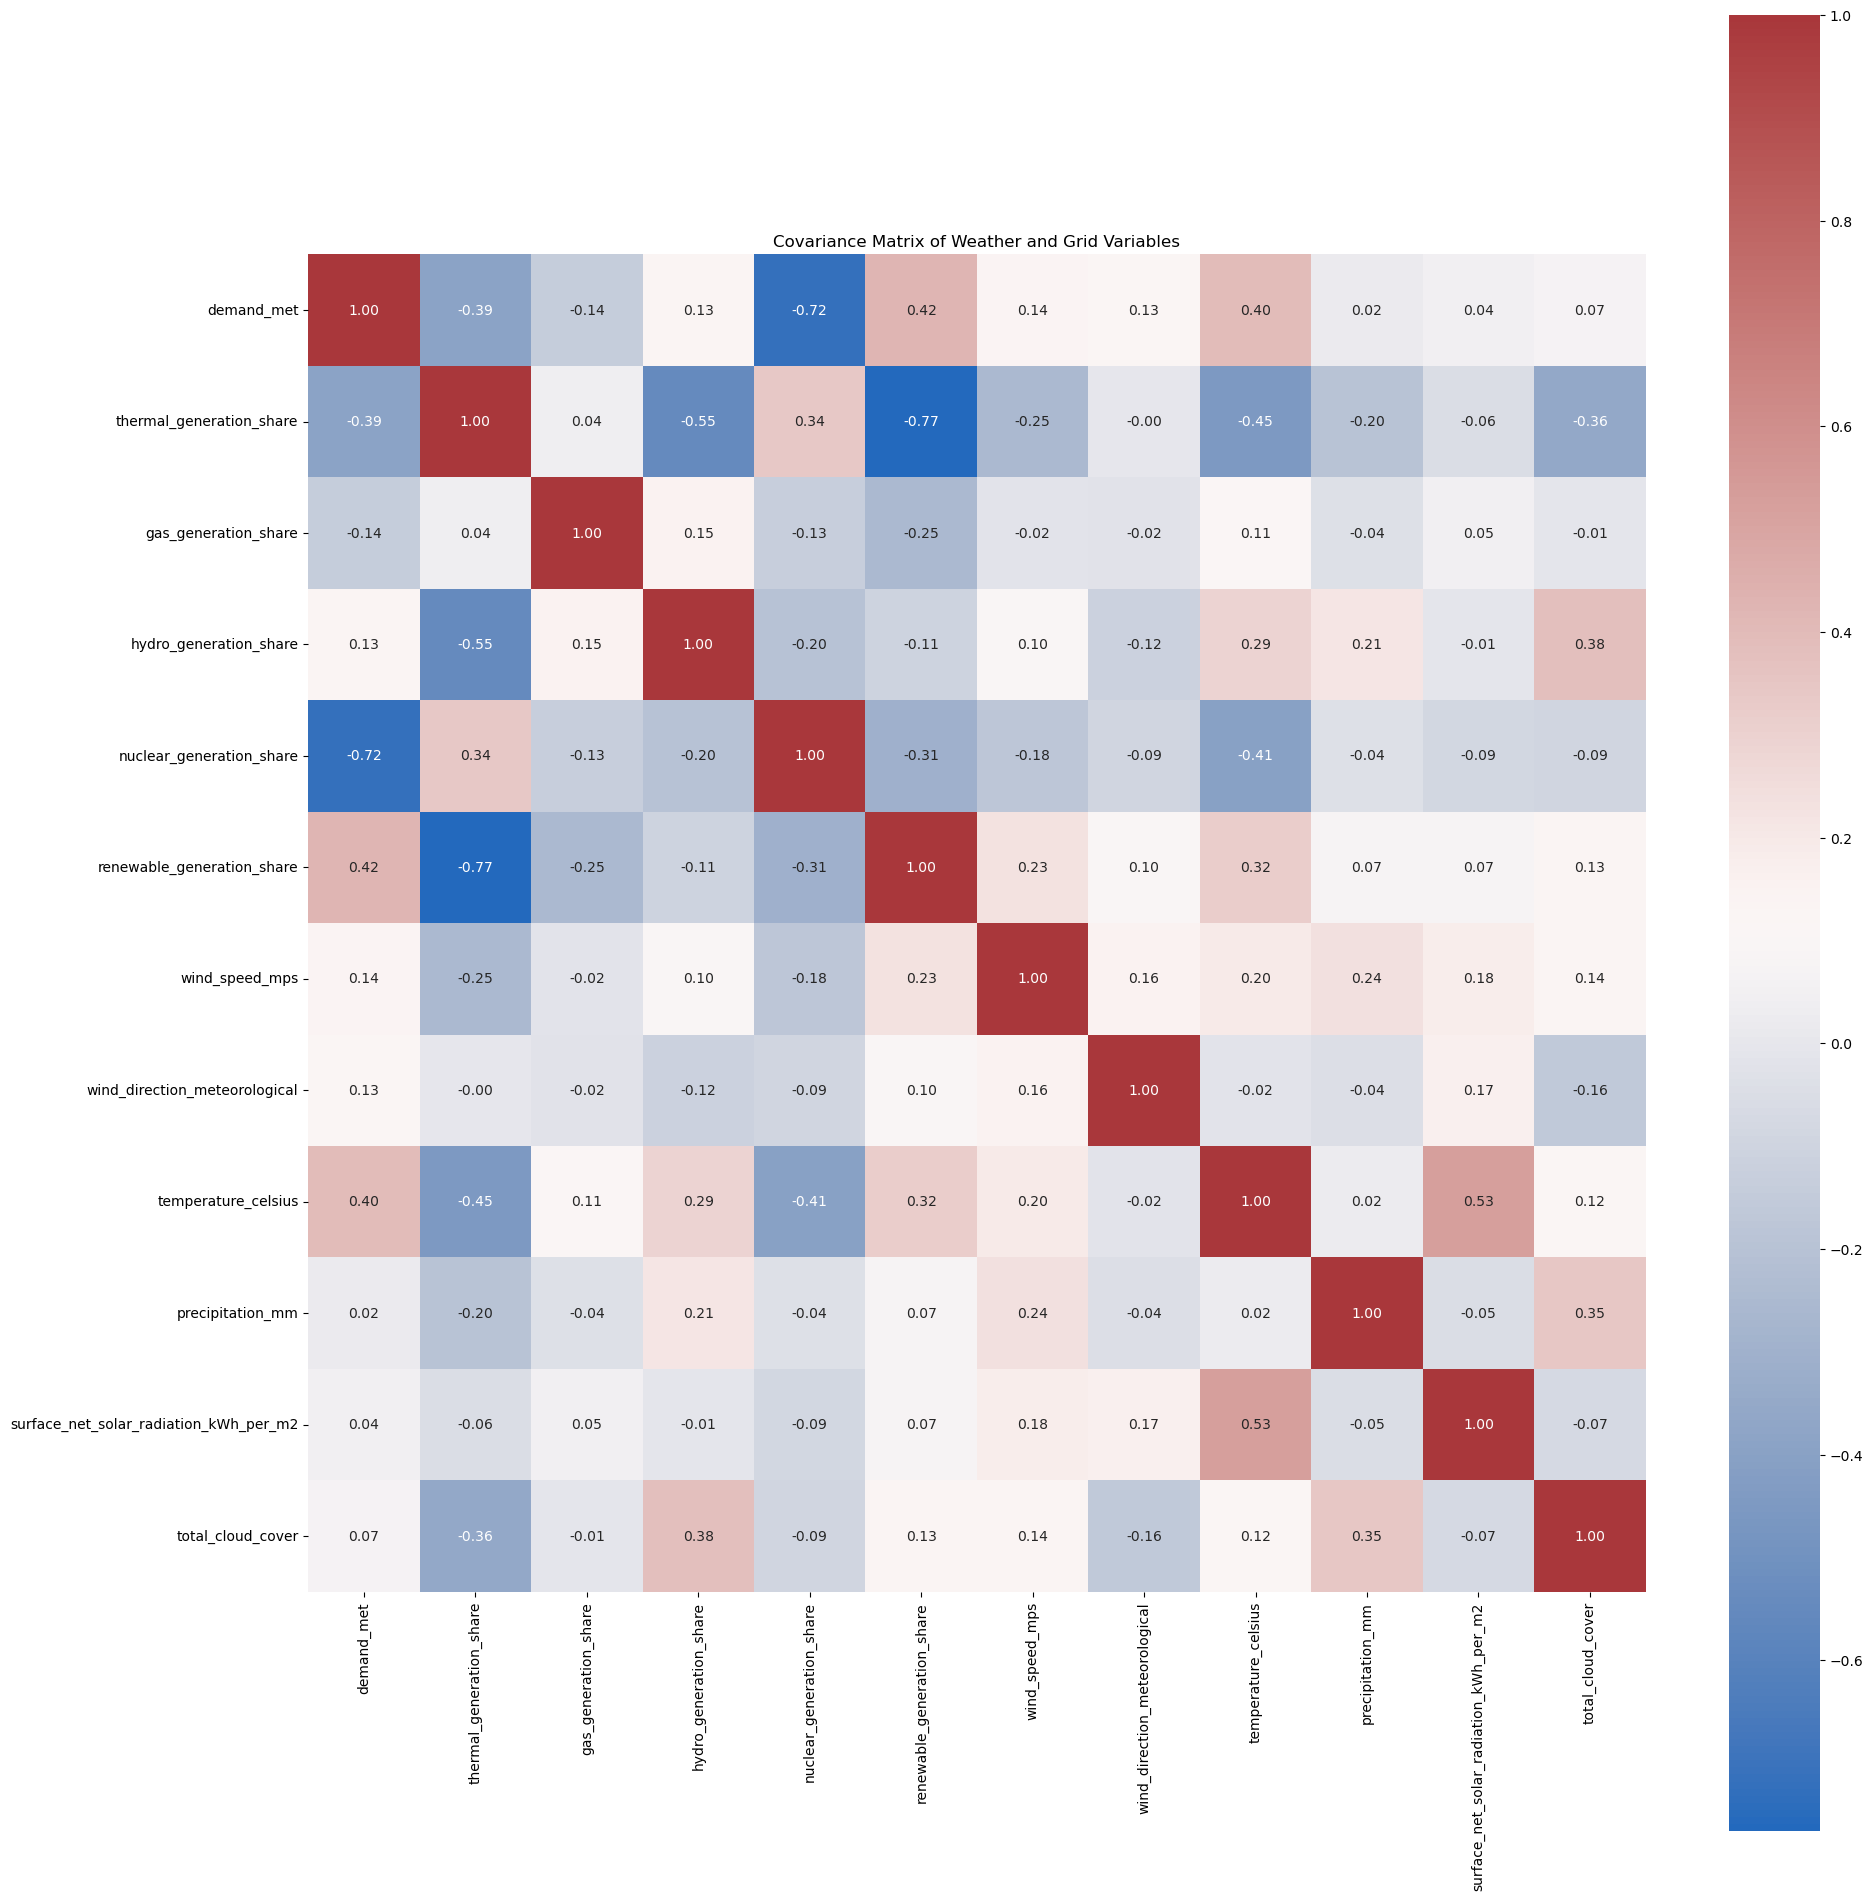

In [120]:
# Check the correlation matrix of the combined DataFrame
print("\n" + "-" * 120)
print("Correlation Matrix of Combined DataFrame:\n" + "-" * 120)
corr_df = (train_pldf_enhanced.select(
    pl.col( grid_share_predictor_vars + reduced_weather_predictor_vars_test),
).to_pandas()
)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    square=True
)
plt.title("Covariance Matrix of Weather and Grid Variables")
plt.tight_layout()
plt.show()

In [121]:
# Add constant (intercept)
X = sm.add_constant(corr_df)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                                  Variable           VIF
0                                    const  89735.003840
1                               demand_met      2.635380
2                 thermal_generation_share    504.051164
3                     gas_generation_share      6.140034
4                   hydro_generation_share    208.627401
5                 nuclear_generation_share      5.264722
6               renewable_generation_share    393.161316
7                           wind_speed_mps      1.196080
8            wind_direction_meteorological      1.142641
9                      temperature_celsius      2.234488
10                        precipitation_mm      1.209387
11  surface_net_solar_radiation_kWh_per_m2      1.653429
12                       total_cloud_cover      1.357789


Interestingly this increases the VIF for the individual grid share variables, but significantly reduces it for the demand met variable, which is certainly a good outcome as it suggests that the demand met variable is now more independent from the other predictors.

Lets next test by dropping the thermal_generation_share and thermal_generation variable from each and re-evaluating the VIF.


------------------------------------------------------------------------------------------------------------------------
Correlation Matrix of Combined DataFrame:
------------------------------------------------------------------------------------------------------------------------


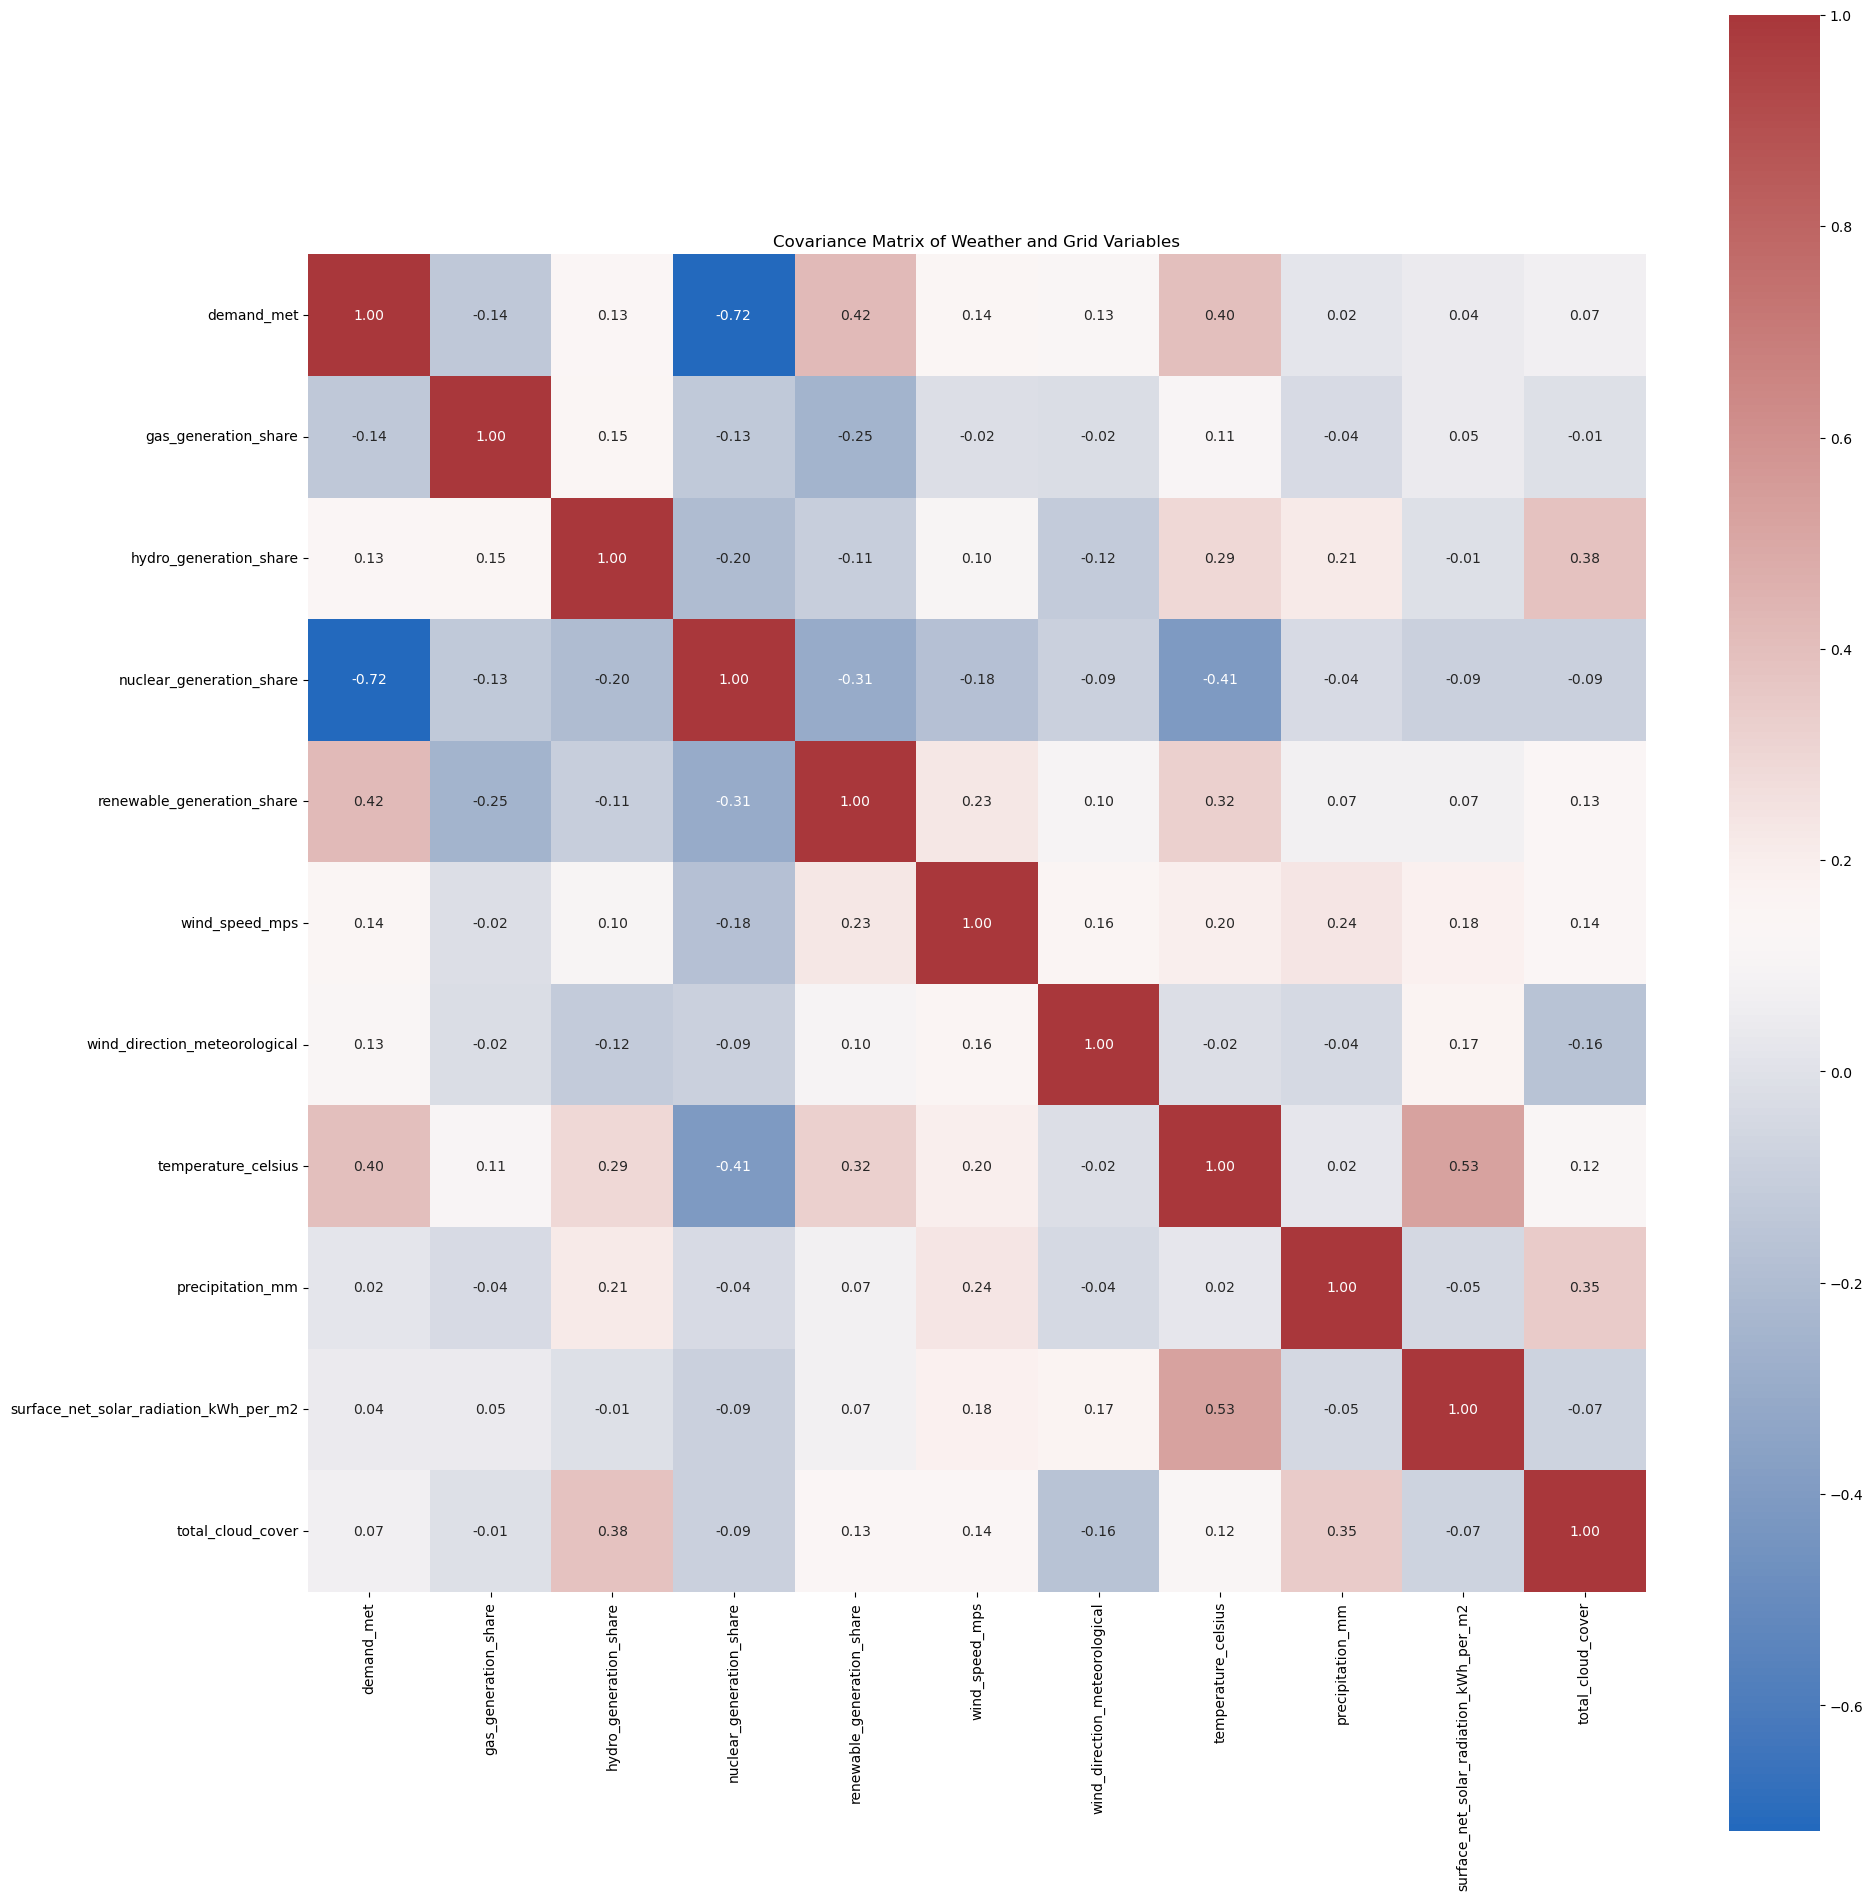

In [123]:
# drop the thermal_generation_share
grid_share_predictor_vars_reduced = ['demand_met', 'gas_generation_share', 'hydro_generation_share',  'nuclear_generation_share', 'renewable_generation_share']

# Check the correlation matrix of the combined DataFrame
print("\n" + "-" * 120)
print("Correlation Matrix of Combined DataFrame:\n" + "-" * 120)
corr_df = (train_pldf_enhanced.select(
    pl.col( grid_share_predictor_vars_reduced + reduced_weather_predictor_vars_test),
).to_pandas()
)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    square=True
)
plt.title("Covariance Matrix of Weather and Grid Variables")
plt.tight_layout()
plt.show()

In [124]:
# Add constant (intercept)
X = sm.add_constant(corr_df)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                                  Variable         VIF
0                                    const  434.498117
1                               demand_met    2.634714
2                     gas_generation_share    1.272634
3                   hydro_generation_share    1.473141
4                 nuclear_generation_share    2.433939
5               renewable_generation_share    1.548980
6                           wind_speed_mps    1.196071
7            wind_direction_meteorological    1.142489
8                      temperature_celsius    2.234459
9                         precipitation_mm    1.209362
10  surface_net_solar_radiation_kWh_per_m2    1.653393
11                       total_cloud_cover    1.357693



------------------------------------------------------------------------------------------------------------------------
Correlation Matrix of Combined DataFrame:
------------------------------------------------------------------------------------------------------------------------


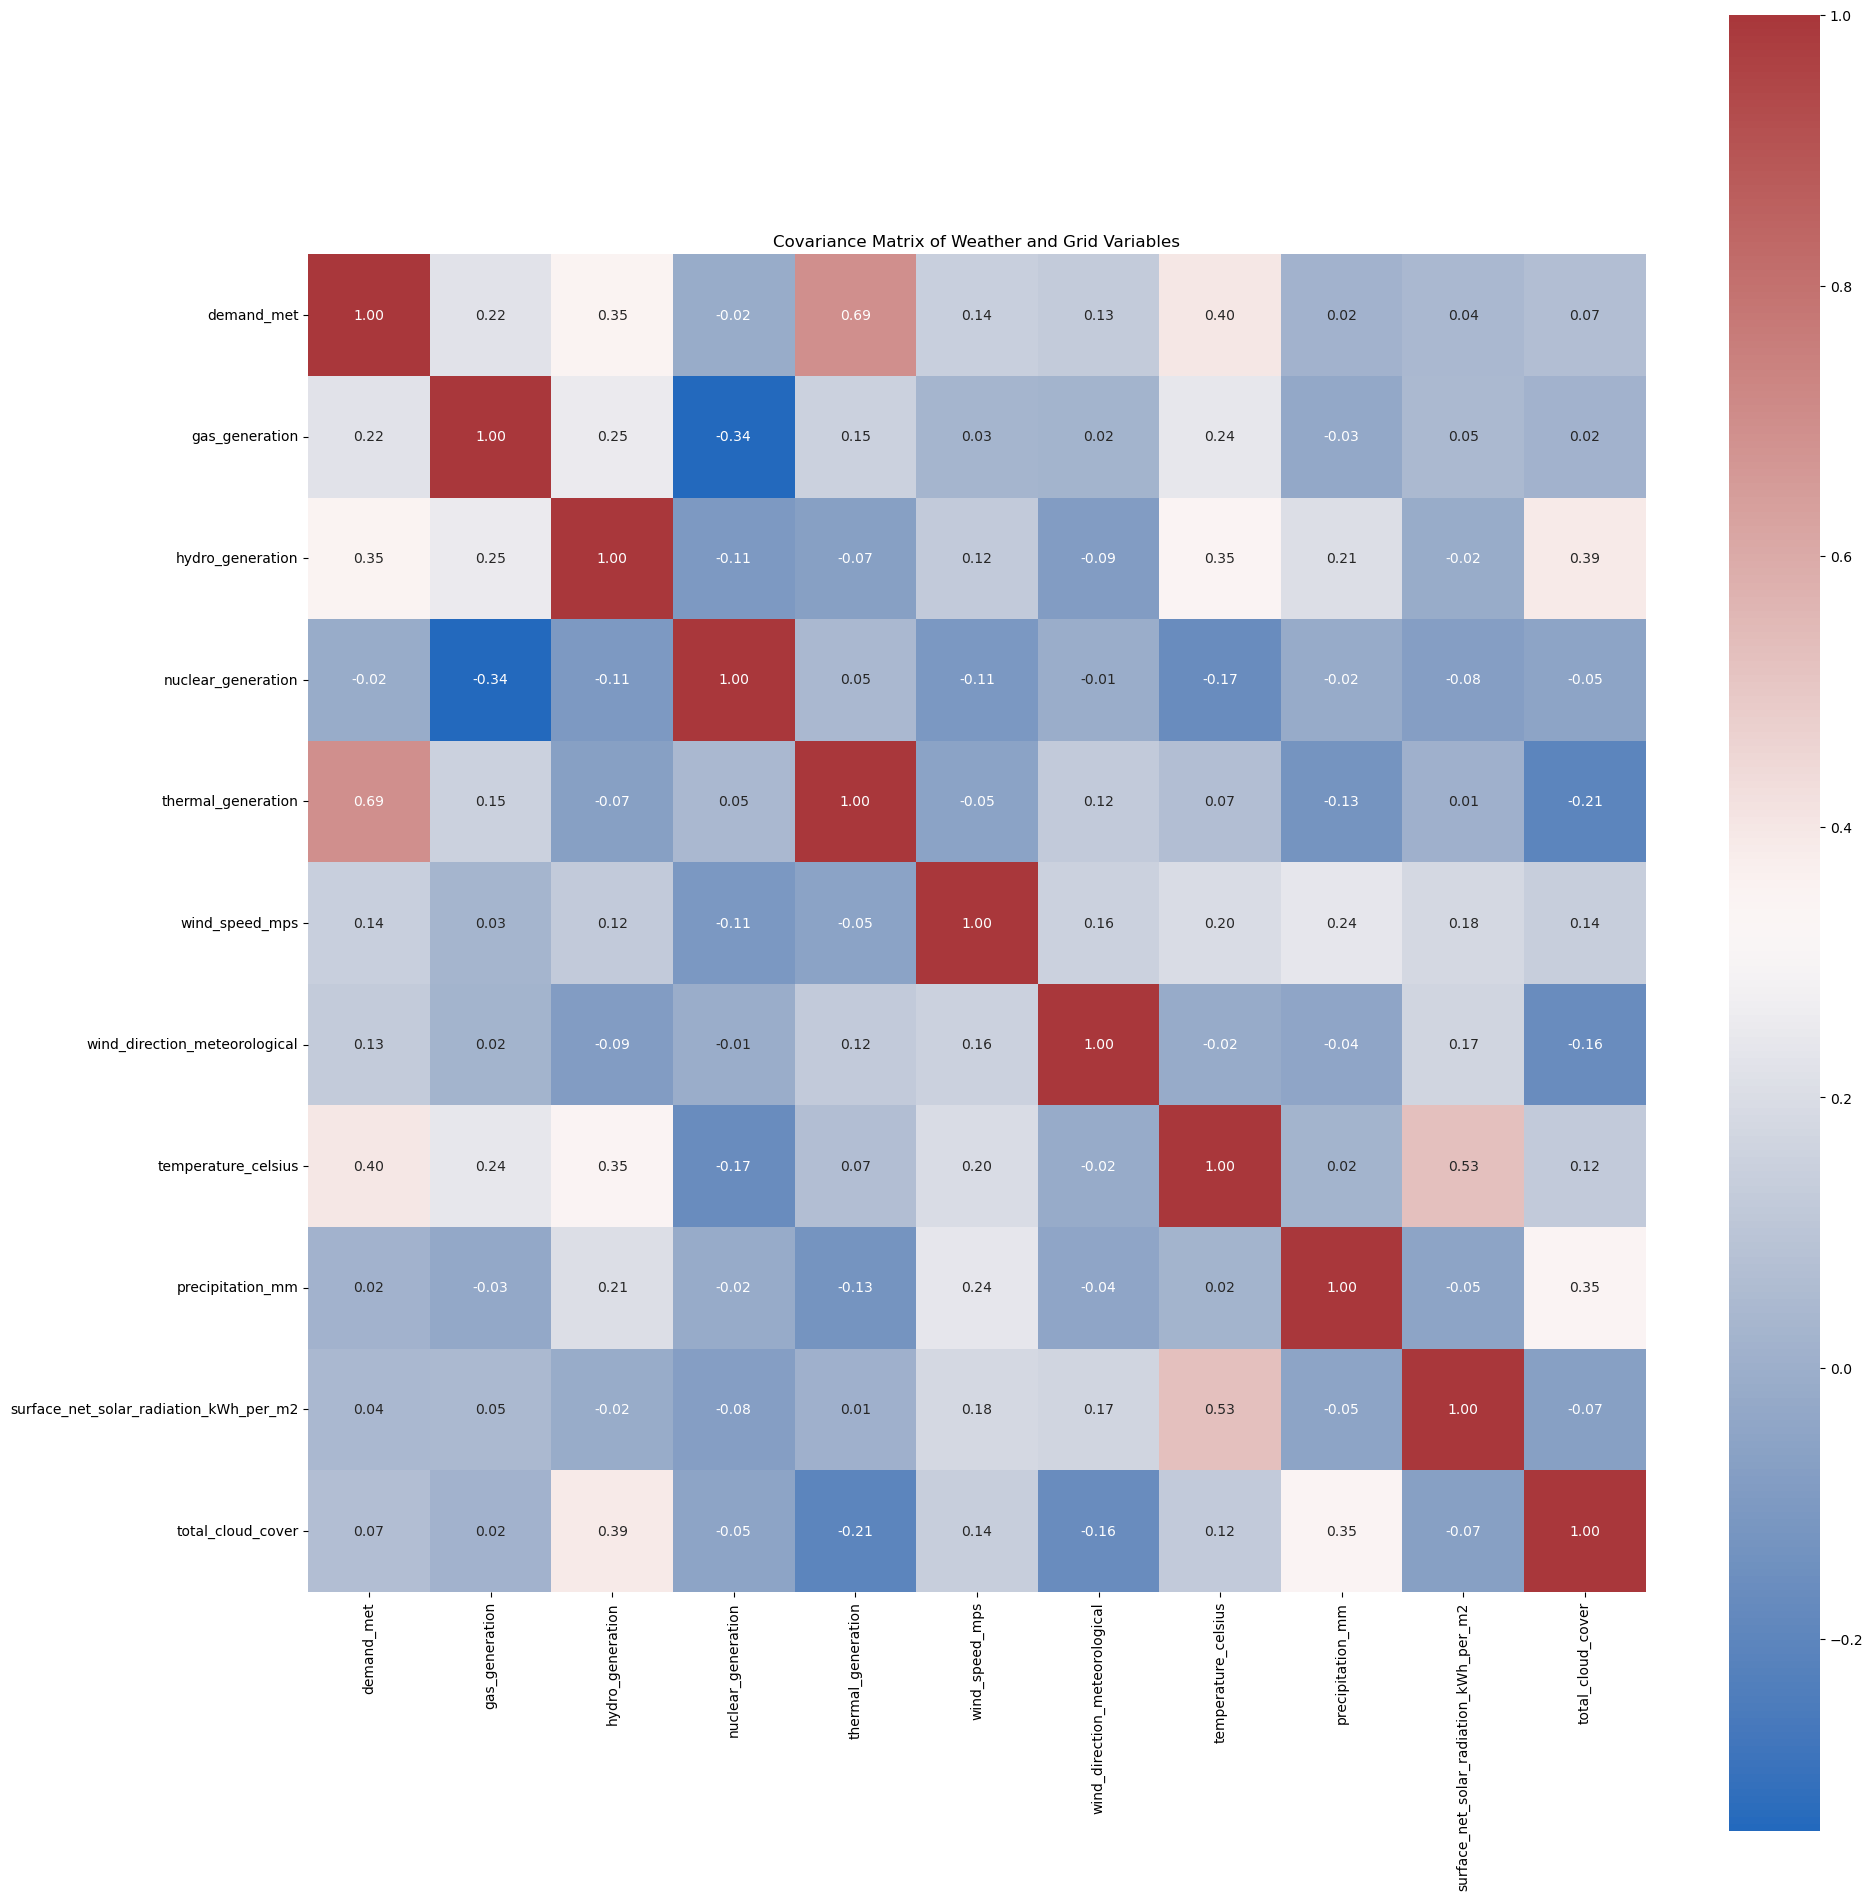

In [137]:
# drop the thermal_generation_share
reduced_grid_predictor_vars = ['demand_met', 'gas_generation', 'hydro_generation',  'nuclear_generation', 'thermal_generation']

# Check the correlation matrix of the combined DataFrame
print("\n" + "-" * 120)
print("Correlation Matrix of Combined DataFrame:\n" + "-" * 120)
corr_df = (train_pldf_enhanced.select(
    pl.col( reduced_grid_predictor_vars + reduced_weather_predictor_vars_test),
).to_pandas()
)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    square=True
)
plt.title("Covariance Matrix of Weather and Grid Variables")
plt.tight_layout()
plt.show()

In [138]:
# Add constant (intercept)
X = sm.add_constant(corr_df)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                                  Variable         VIF
0                                    const  167.283811
1                               demand_met    3.675279
2                           gas_generation    1.277623
3                         hydro_generation    1.730061
4                       nuclear_generation    1.169817
5                       thermal_generation    2.915525
6                           wind_speed_mps    1.194009
7            wind_direction_meteorological    1.141827
8                      temperature_celsius    2.180237
9                         precipitation_mm    1.208162
10  surface_net_solar_radiation_kWh_per_m2    1.648973
11                       total_cloud_cover    1.374702


Interestingly we see an uptick in the VIF values for the 'share' schema compared to the raw values, though both drop significantly after taking out the thermal generation.

Even though the VIF values for the 'share' schema are higher, I think it'd be best to use them as since their sum + thermal is equal to 1, and therefore still includes the context of the thermal generation without explicitly modeling it.

Though in oour case thermal is likely to be used as a marginal fuel because it is easy to ramp up and ramp down, so lets see if we can potentially remove a different generation source and get the same effect.


------------------------------------------------------------------------------------------------------------------------
Correlation Matrix of Combined DataFrame:
------------------------------------------------------------------------------------------------------------------------


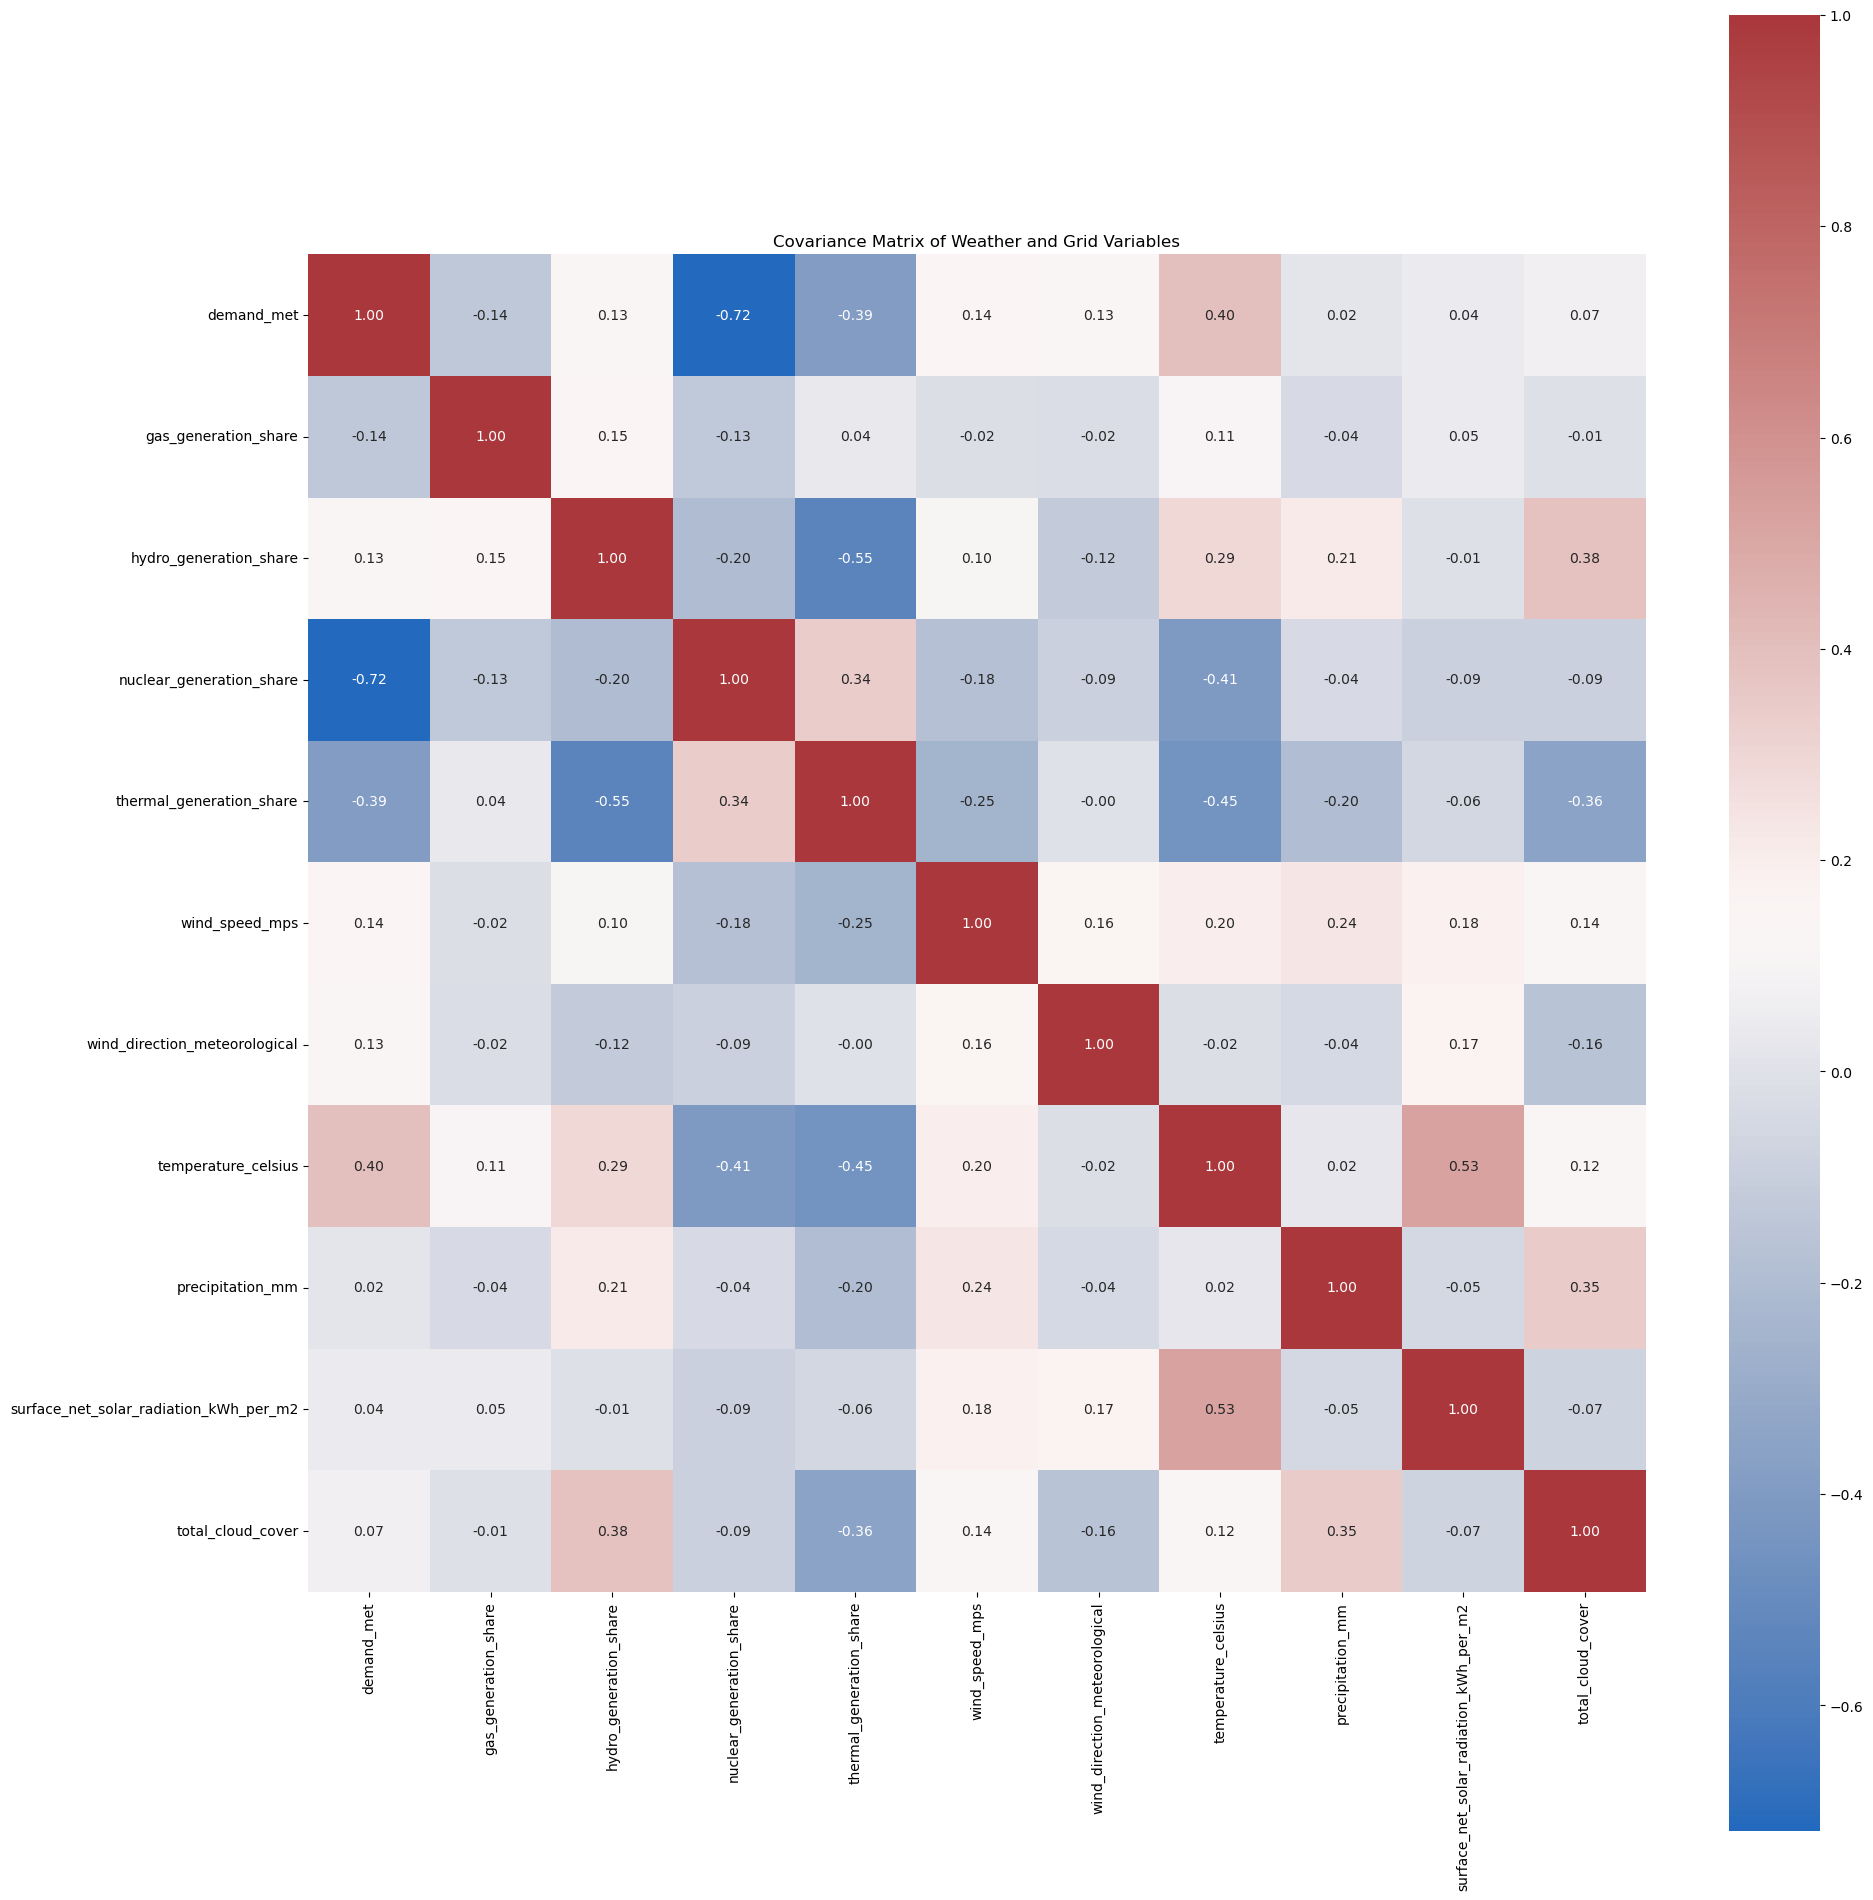

In [139]:
# drop the thermal_generation_share
grid_share_predictor_vars_reduced = ['demand_met', 'gas_generation_share', 'hydro_generation_share',  'nuclear_generation_share', 'thermal_generation_share']

# Check the correlation matrix of the combined DataFrame
print("\n" + "-" * 120)
print("Correlation Matrix of Combined DataFrame:\n" + "-" * 120)
corr_df = (train_pldf_enhanced.select(
    pl.col( grid_share_predictor_vars_reduced + reduced_weather_predictor_vars_test),
).to_pandas()
)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    square=True
)
plt.title("Covariance Matrix of Weather and Grid Variables")
plt.tight_layout()
plt.show()

In [140]:
# Add constant (intercept)
X = sm.add_constant(corr_df)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                                  Variable         VIF
0                                    const  805.136988
1                               demand_met    2.635300
2                     gas_generation_share    1.219104
3                   hydro_generation_share    1.639598
4                 nuclear_generation_share    2.427716
5                 thermal_generation_share    1.985864
6                           wind_speed_mps    1.195892
7            wind_direction_meteorological    1.142583
8                      temperature_celsius    2.234024
9                         precipitation_mm    1.209379
10  surface_net_solar_radiation_kWh_per_m2    1.653148
11                       total_cloud_cover    1.357785


Great - so  it looks like we can remove renewables and still keep the model performance intact. This is a promising direction for simplifying our feature set while maintaining predictive power.

In [141]:
final_recommended_grid_predictor_vars = ['demand_met', 'gas_generation_share', 'hydro_generation_share',  'nuclear_generation_share', 'thermal_generation_share']
final_recommended_weather_predictor_vars = ['total_cloud_cover', 'surface_net_solar_radiation_kWh_per_m2', 'precipitation_mm','temperature_celsius',  'wind_direction_meteorological', 'wind_speed_mps']



------------------------------------------------------------------------------------------------------------------------
Correlation Matrix of Combined DataFrame:
------------------------------------------------------------------------------------------------------------------------


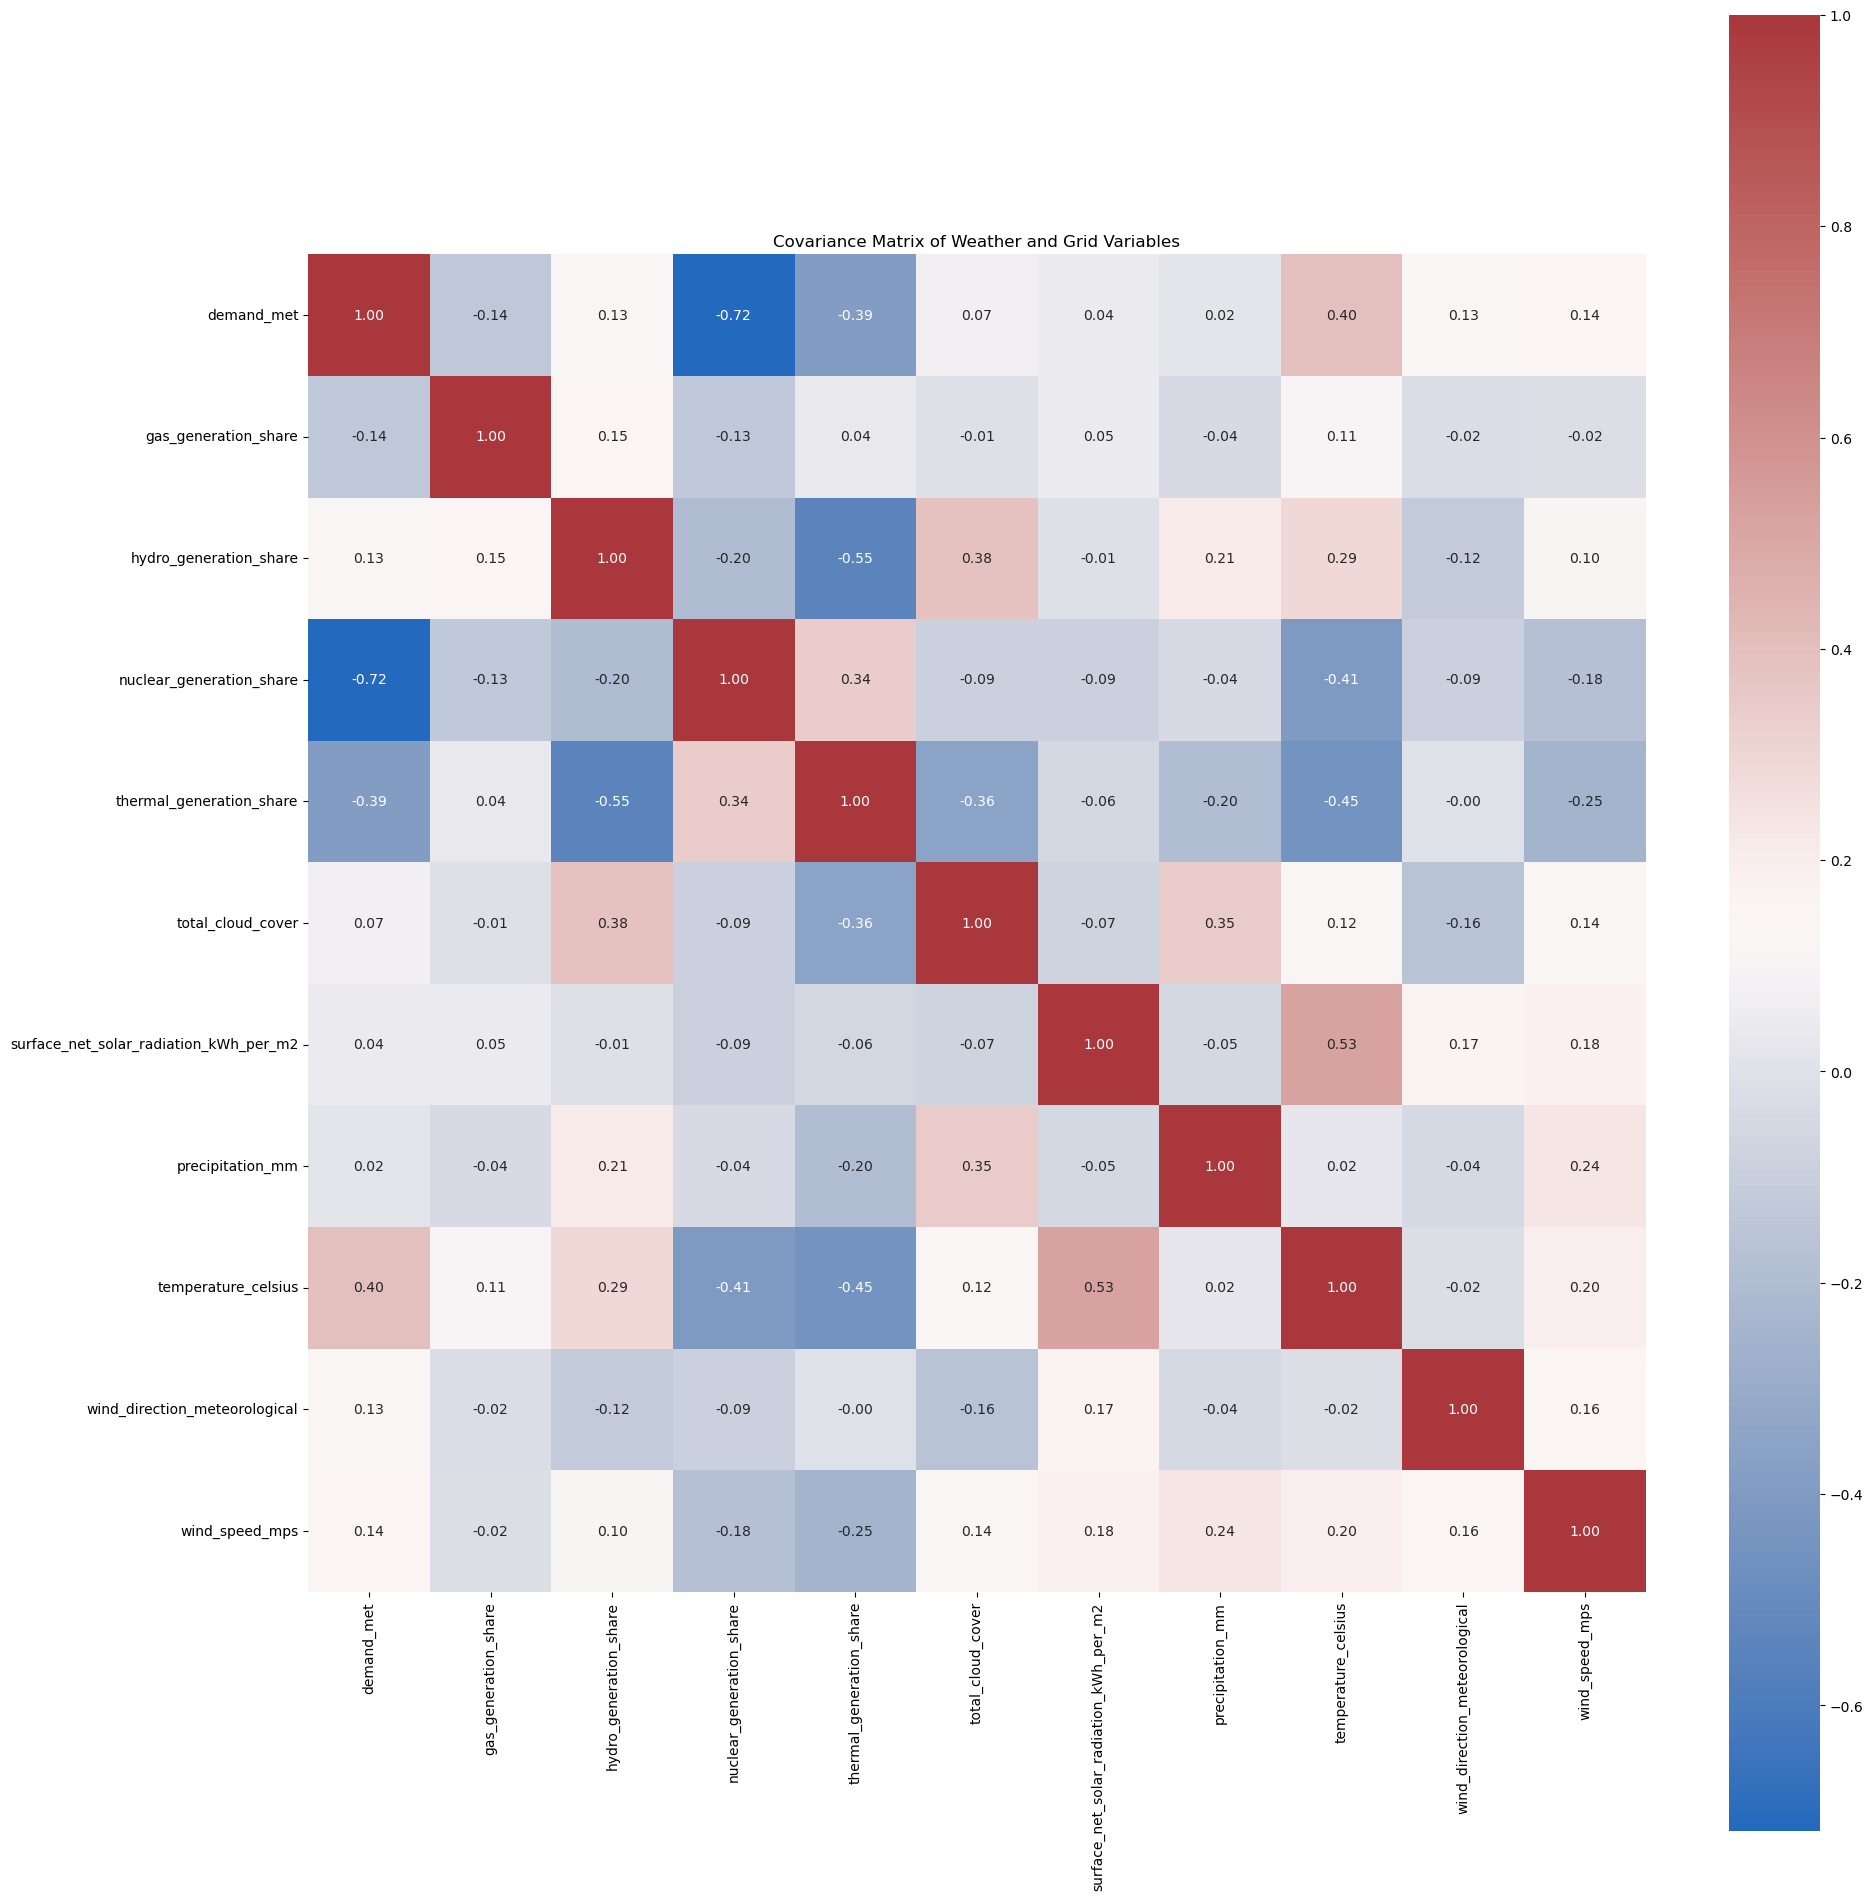

In [142]:
# drop the thermal_generation_share
# Check the correlation matrix of the combined DataFrame
print("\n" + "-" * 120)
print("Correlation Matrix of Combined DataFrame:\n" + "-" * 120)
corr_df = (train_pldf_enhanced.select(
    pl.col( final_recommended_grid_predictor_vars + final_recommended_weather_predictor_vars),
).to_pandas()
)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    square=True
)
plt.title("Covariance Matrix of Weather and Grid Variables")
plt.tight_layout()
plt.show()

In [143]:
# Add constant (intercept)
X = sm.add_constant(corr_df)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                                  Variable         VIF
0                                    const  805.136988
1                               demand_met    2.635300
2                     gas_generation_share    1.219104
3                   hydro_generation_share    1.639598
4                 nuclear_generation_share    2.427716
5                 thermal_generation_share    1.985864
6                        total_cloud_cover    1.357785
7   surface_net_solar_radiation_kWh_per_m2    1.653148
8                         precipitation_mm    1.209379
9                      temperature_celsius    2.234024
10           wind_direction_meteorological    1.142583
11                          wind_speed_mps    1.195892


#### Correlation and Colinearities - SUMMARY

**Overview (Predictor recommendations for marginal-emissions modeling)**

* Grid (levels + composition)
    * demand_met
    * Fuel shares (omit renewable ):
        * gas_generation_share
        * hydro_generation_share
        * nuclear_generation_share
        * thermal_generation_share

* Weather (reduced, low VIF)
    * total_cloud_cover
    * surface_net_solar_radiation_kWh_per_m2
    * precipitation_mm
    * temperature_celsius
    * wind_direction_meteorological
    * wind_speed_mps

* Rationale: Shares give composition signal with minimal redundancy; dropping renewable_generation_share treats renewables as an implicit baseline. Weather set retains 1 solar measure (kWh/m²) for interpretability and uses total cloud (lower single VIF than the layer trio in tests).


**Variables intentionally excluded**
* Grid:
    * thermal_generation, gas_generation, hydro_generation, nuclear_generation, renewable_generation (replaced by shares), total_generation, non_renewable_generation, g_co2_per_kwh, tons_co2_per_mwh.

* Weather (colinear):
    * surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2, surface_solar_radiation_downwards_joules_per_m2, (kept total cloud; dropped the high/medium/low trio).

* Collinearity findings & choices:
    * Solar: Extremely colinear across unit variants. Keep only surface_net_solar_radiation_kWh_per_m2 (human-readable; avoids unit/rounding duplication).
    * Clouds: Your VIF tests show total_cloud_cover has a lower single VIF than any one of {high, medium, low}. Keeping total and dropping layers reduces noise without losing the primary radiative signal.
    * Generation: Raw levels are highly correlated with each other and with demand. Using shares captures mix changes (what’s marginal) while slashing overlap.
        * Removing a single generation share (thermal, renewable) dropped overall VIFs markedly and still encodes the total via the simplex constraint (sum of shares = 1).
        * After this change, demand_met becomes more independent (nice outcome).


**Data notes:**
* Solar magnitudes: high absolute values (as expected from unit choices); not an issue once a single unit is selected.
* Some generation magnitudes high: expected for system-level totals; handled via share transformation.
* Cloud cover: elevated values appear in periods; keeping the single total_cloud_cover feature avoids multi-collinearity across layers.


**Why this feature set is good for marginal emissions**
* Shares + demand let the model respond when the marginal unit shifts (e.g., higher gas share at a given load implies different marginal rate).
* Renewables as baseline avoids redundancy and keeps coefficients stable.
* Weather (wind/solar/clouds/precip/temp) explain short-run availability of low-carbon supply and ramps that change the marginal plant.


**Transformations:** 
* will still want to log1p for wind_speed_mps and precipitation_mm, keep wind direction as circular (sin/cos).

#### Outlier Analysis

In [50]:
print("-"*120)
print("Outlier Analysis")
print("-"*120)

# Z-score method
print("Outliers identified using Z-score method (grid variables):")
outlier_zscore_checker(train_df, all_grid_predictor_vars, threshold=3.0, display_table=True)

print("\nOutliers identified using Z-score method (weather variables):")
outlier_zscore_checker(train_df, all_weather_predictor_vars, threshold=3.0, display_table=True)


------------------------------------------------------------------------------------------------------------------------
Outlier Analysis
------------------------------------------------------------------------------------------------------------------------
Outliers identified using Z-score method (grid variables):

------------------------------------------------------------------------------------------------------------------------
Z-score Outlier Summary:
------------------------------------------------------------------------------------------------------------------------


n_outliers  pct_outliers
thermal_generation           855          0.04
gas_generation             35685          1.51
hydro_generation               0          0.00
nuclear_generation         10170          0.43
renewable_generation        5445          0.23
demand_met                  1485          0.06


Outliers identified using Z-score method (weather variables):

------------------------------------------------------------------------------------------------------------------------
Z-score Outlier Summary:
------------------------------------------------------------------------------------------------------------------------


n_outliers  pct_outliers
wind_speed_mps                                        30383          1.28
wind_direction_meteorological                             0          0.00
temperature_celsius                                    2651          0.11
precipitation_mm                                      47834          2.02
surface_net_solar_radiation_kWh_per_m2                 4046          0.17
surface_solar_radiation_downwards_kWh_per_m2             23          0.00
surface_net_solar_radiation_joules_per_m2               111          0.00
surface_solar_radiation_downwards_joules_per_m2           0          0.00
total_cloud_cover                                         0          0.00
high_cloud_cover                                          0          0.00
medium_cloud_cover                                    84673          3.58
low_cloud_cover                                       80163          3.39

wind_speed_mps  wind_direction_meteorological  temperature_celsius  \
0                 False                          False                False   
1                 False                          False                False   
2                 False                          False                False   
3                 False                          False                False   
4                 False                          False                False   
...                 ...                            ...                  ...   
2365195           False                          False                False   
2365196           False                          False                False   
2365197           False                          False                False   
2365198           False                          False                False   
2365199           False                          False                False   

         precipitation_mm  surface_net_solar_radiation_kWh_per_m2  \
0                   False                                   False   
1                   False                                   False   
2                   False                                   False   
3                   False                                   False   
4                   False                                   False   
...                   ...                                     ...   
2365195             False                                   False   
2365196             False                                   False   
2365197             False                                   False   
2365198             False                                   False   
2365199             False                                   False   

         surface_solar_radiation_downwards_kWh_per_m2  \
0                                               False   
1                                               False   
2                                               False   
3                                               False   
4                                               False   
...                                               ...   
2365195                                         False   
2365196                                         False   
2365197                                         False   
2365198                                         False   
2365199                                         False   

         surface_net_solar_radiation_joules_per_m2  \
0                                            False   
1                                            False   
2                                            False   
3                                            False   
4                                            False   
...                                            ...   
2365195                                      False   
2365196                                      False   
2365197                                      False   
2365198                                      False   
2365199                                      False   

         surface_solar_radiation_downwards_joules_per_m2  total_cloud_cover  \
0                                                  False              False   
1                                                  False              False   
2                                                  False              False   
3                                                  False              False   
4                                                  False              False   
...                                                  ...                ...   
2365195                                            False              False   
2365196                                            False              False   
2365197                                            False              False   
2365198                                            False              False   
2365199                     

In [51]:

# IQR method
print("\nOutliers identified using IQR method (grid variables):")
outlier_iqr_checker(train_df, all_grid_predictor_vars, k=1.5, display_table=True)

print("\nOutliers identified using IQR method (weather variables):")
outlier_iqr_checker(train_df, all_weather_predictor_vars, k=1.5, display_table=True)



Outliers identified using IQR method (grid variables):

------------------------------------------------------------------------------------------------------------------------
IQR Outlier Summary:
------------------------------------------------------------------------------------------------------------------------


n_outliers  pct_outliers
thermal_generation           720          0.03
gas_generation             49410          2.09
hydro_generation               0          0.00
nuclear_generation          9765          0.41
renewable_generation        6255          0.26
demand_met                  8280          0.35


Outliers identified using IQR method (weather variables):

------------------------------------------------------------------------------------------------------------------------
IQR Outlier Summary:
------------------------------------------------------------------------------------------------------------------------


n_outliers  pct_outliers
wind_speed_mps                                        76544          3.24
wind_direction_meteorological                             0          0.00
temperature_celsius                                   82734          3.50
precipitation_mm                                     526788         22.27
surface_net_solar_radiation_kWh_per_m2                73893          3.12
surface_solar_radiation_downwards_kWh_per_m2          69759          2.95
surface_net_solar_radiation_joules_per_m2               830          0.04
surface_solar_radiation_downwards_joules_per_m2           0          0.00
total_cloud_cover                                         0          0.00
high_cloud_cover                                          0          0.00
medium_cloud_cover                                   196981          8.33
low_cloud_cover                                      365002         15.43

wind_speed_mps  wind_direction_meteorological  temperature_celsius  \
0                 False                          False                False   
1                 False                          False                False   
2                 False                          False                False   
3                 False                          False                False   
4                 False                          False                False   
...                 ...                            ...                  ...   
2365195           False                          False                 True   
2365196           False                          False                 True   
2365197           False                          False                 True   
2365198           False                          False                 True   
2365199           False                          False                 True   

         precipitation_mm  surface_net_solar_radiation_kWh_per_m2  \
0                   False                                   False   
1                   False                                   False   
2                   False                                   False   
3                   False                                   False   
4                   False                                   False   
...                   ...                                     ...   
2365195             False                                   False   
2365196             False                                   False   
2365197             False                                   False   
2365198             False                                   False   
2365199             False                                   False   

         surface_solar_radiation_downwards_kWh_per_m2  \
0                                               False   
1                                               False   
2                                               False   
3                                               False   
4                                               False   
...                                               ...   
2365195                                         False   
2365196                                         False   
2365197                                         False   
2365198                                         False   
2365199                                         False   

         surface_net_solar_radiation_joules_per_m2  \
0                                            False   
1                                            False   
2                                            False   
3                                            False   
4                                            False   
...                                            ...   
2365195                                      False   
2365196                                      False   
2365197                                      False   
2365198                                      False   
2365199                                      False   

         surface_solar_radiation_downwards_joules_per_m2  total_cloud_cover  \
0                                                  False              False   
1                                                  False              False   
2                                                  False              False   
3                                                  False              False   
4                                                  False              False   
...                                                  ...                ...   
2365195                                            False              False   
2365196                                            False              False   
2365197                                            False              False   
2365198                                            False              False   
2365199                     

##### Outlier Summary

**Weather**

* Precipitation
    * Z-score: 2.0% flagged -> z-score under-flags heavy-tailed, zero-inflated series
    * IQR: 22.3% flagged -> expected with many zeros + rare intense events (fat right tail).
    * Recommendation: Keep precipitation_mm, but model as two-part (occurrence = 1{precip>0} + log1p(intensity) for >0) or at least use log1p. May want to winsorise the very top tail (e.g., 99.9th) if using a linear model.

* Wind speed
    * Z-score: 1.28% | IQR: 3.24% -> moderate right tail, gusty episodes.
    * Recommendation: Optional log1p (or robust scaling) if use linear/GLM. Trees can handle as is.

* Temperature
    * Z-score: 0.11% | IQR: 3.50% -> mild tails, seasonal spread.
    * Recommendation: Usually fine without transform; standardise and/or include season/hour features.

* Solar (kWh/m²)
    * Z-score: 0.17% | IQR: 3.12% -> day/night and seasonal swing create apparent “outliers”.
    * Recommendation: Keeping one solar measure (surface_net_solar_radiation_kWh_per_m2) remains right approach. 

* Cloud cover
    * Total cloud: 0% outliers in both screens (bounded [0,1]).
    * Medium/Low cloud: Z-score ~3–3.6% and IQR 8–15% flagged -> heavy zero-inflation and edge peaking.
    * Recommendation: Data supports keeping only total_cloud_cover. The layer vars are noisier and more zero-inflated.

* Wind direction
    * 0% outliers by both -> expected (circular).
    * Recommendation: Keep as angle if use trees; for linear models, use sin/cos transform.



**Grid**

* Gas generation
    * IQR: 2.09% (peaking behavior) -> exactly what we expect for a marginal/peaking resource.
* Others (thermal, nuclear, renewable, demand)
    * Very low outlier rates -> stable fleets/baseload & demand patterns.
* Recommendation: Share approach still makes sense for marginal emissions: it captures composition shifts; removing thermal share lowered collinearity while still encoding thermal as the baseline (shares sum to 1).

#### Temporal Patterns

------------------------------------------------------------------------------------------------------------------------
Temporal Pattern Analysis
------------------------------------------------------------------------------------------------------------------------


2025-08-16 23:29:58,952 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-16 23:29:59,759 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


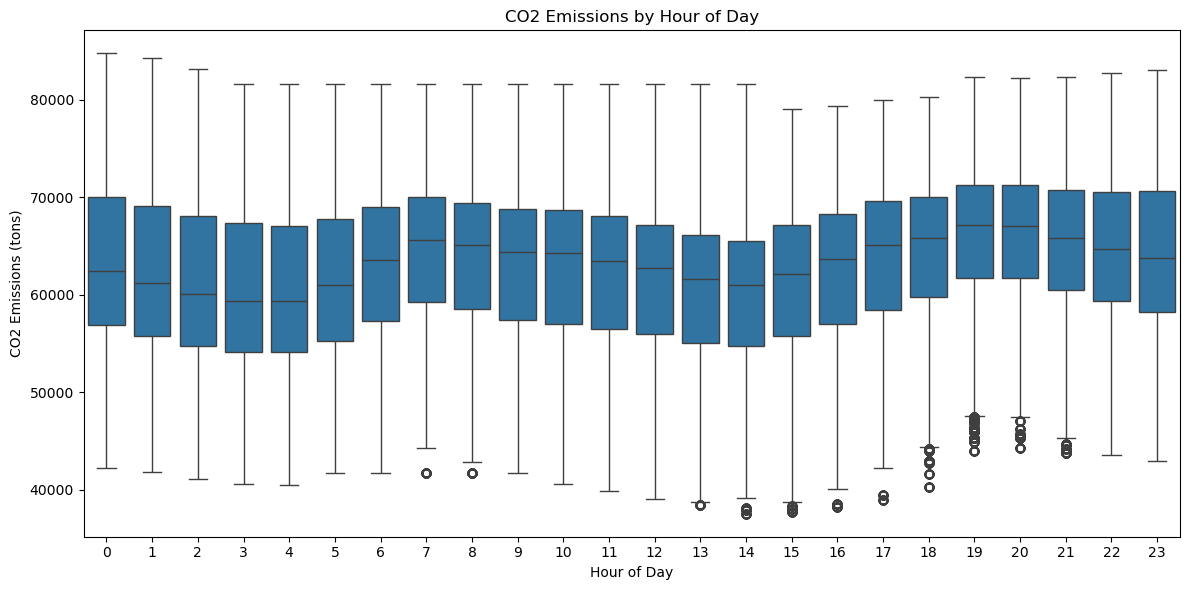

In [52]:
print("-"*120)
print("Temporal Pattern Analysis\n" + "-"*120)

dt_adder = DateTimeFeatureAdder(timestamp_col="timestamp")
temporal_df = dt_adder.fit_transform(train_df)

# Daily patterns for emissions
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='tons_co2', data=temporal_df)
plt.title('CO2 Emissions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('CO2 Emissions (tons)')
plt.tight_layout()
plt.show()

2025-08-16 23:30:00,672 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-16 23:30:01,351 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


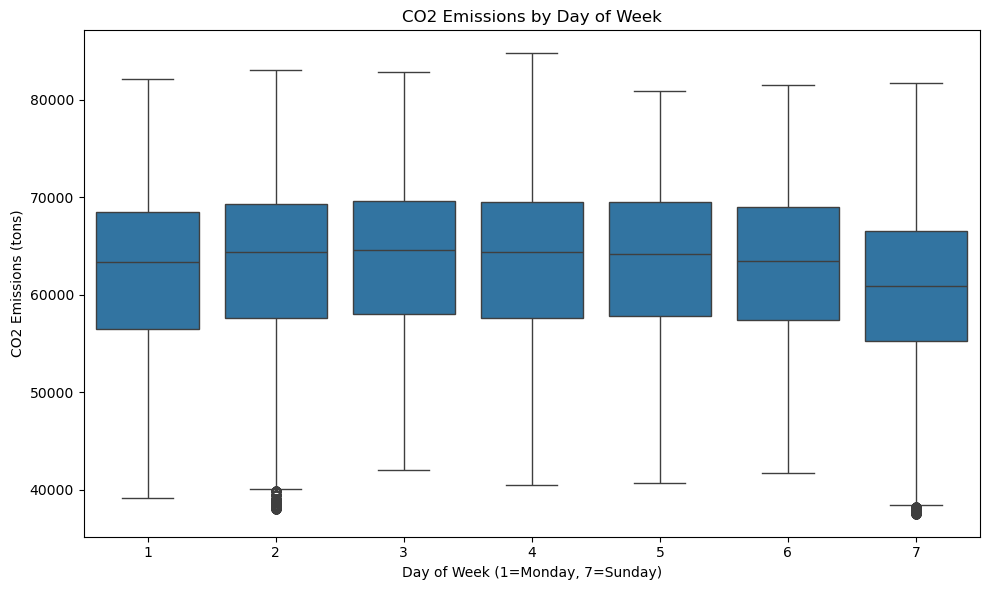

In [53]:
# Weekly patterns
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='tons_co2', data=temporal_df)
plt.title('CO2 Emissions by Day of Week')
plt.xlabel('Day of Week (1=Monday, 7=Sunday)')
plt.ylabel('CO2 Emissions (tons)')
plt.tight_layout()
plt.show()

2025-08-16 23:30:02,188 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-16 23:30:02,816 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


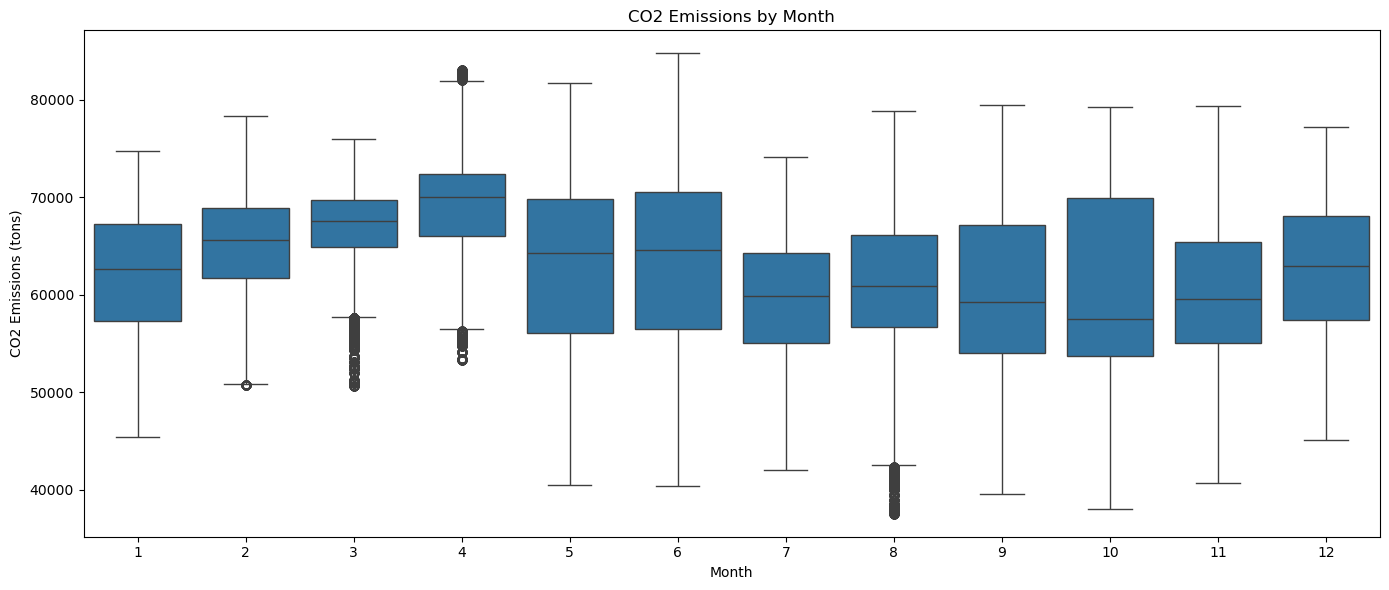

In [54]:
# Monthly patterns
if 'month' in temporal_df.columns:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='month', y='tons_co2', data=temporal_df)
    plt.title('CO2 Emissions by Month')
    plt.xlabel('Month')
    plt.ylabel('CO2 Emissions (tons)')
    plt.tight_layout()
    plt.show()

2025-08-16 23:30:03,684 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-16 23:30:04,306 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


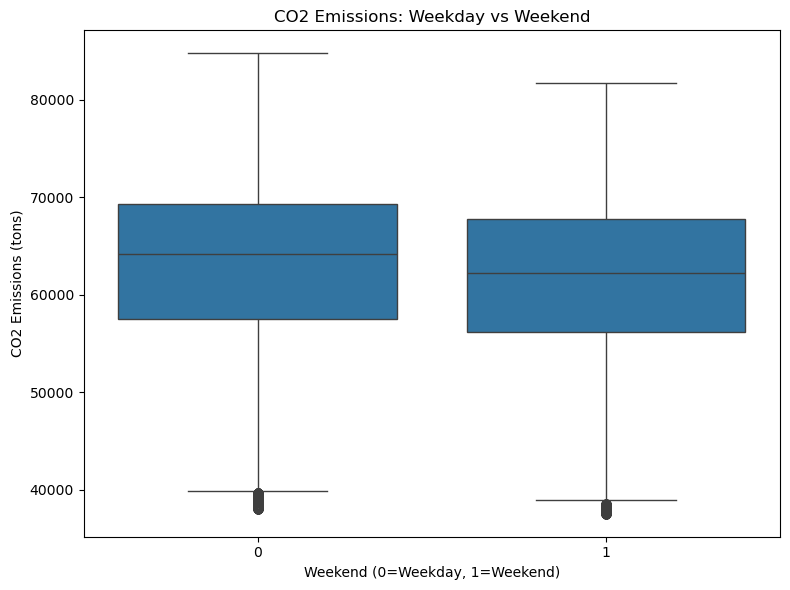

In [55]:
# Weekend vs weekday
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_weekend', y='tons_co2', data=temporal_df)
plt.title('CO2 Emissions: Weekday vs Weekend')
plt.xlabel('Weekend (0=Weekday, 1=Weekend)')
plt.ylabel('CO2 Emissions (tons)')
plt.tight_layout()
plt.show()

#### Temporal Patterns - SUMMARY

#### Relationship With Demand

------------------------------------------------------------------------------------------------------------------------
Relationship between Emissions and Demand
------------------------------------------------------------------------------------------------------------------------


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_35272/2181543514.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_35272/2181543514.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]


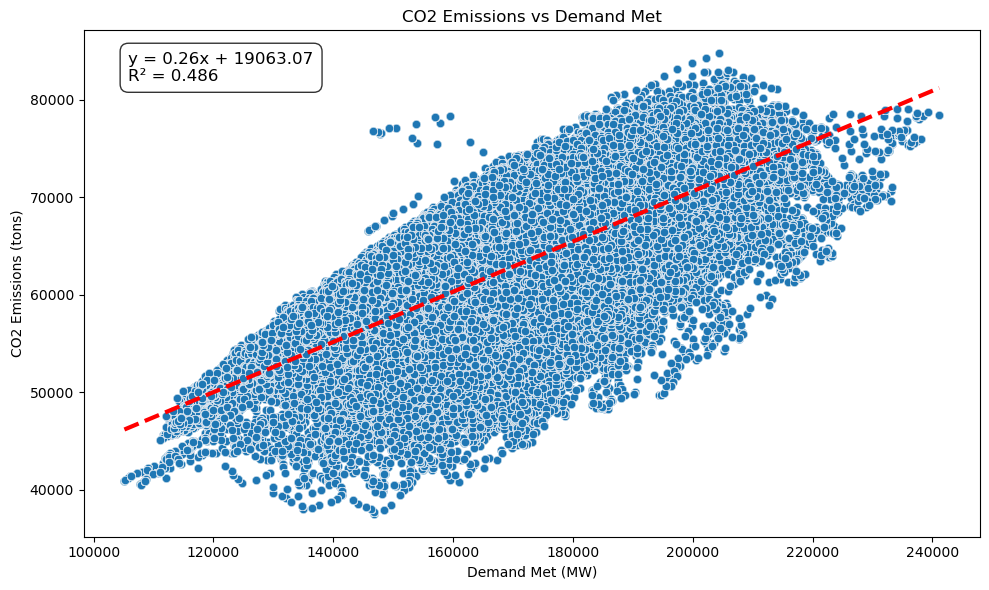


Regression Analysis: Emissions vs Demand
                            OLS Regression Results                            
Dep. Variable:               tons_co2   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                 2.236e+06
Date:                Sat, 16 Aug 2025   Prob (F-statistic):               0.00
Time:                        23:30:06   Log-Likelihood:            -2.3775e+07
No. Observations:             2365200   AIC:                         4.755e+07
Df Residuals:                 2365198   BIC:                         4.755e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

In [56]:
print("-"*120)
print("Relationship between Emissions and Demand\n" + "-"*120)

# Create figure
plt.figure(figsize=(10, 6))

# Plot scatter points
sns.scatterplot(x='demand_met', y='tons_co2', data=train_df, alpha=0.5)

# Fit a simple regression line
X = sm.add_constant(train_df['demand_met'])
model = sm.OLS(train_df['tons_co2'], X).fit()

# Generate points for the line
x_range = np.linspace(train_df['demand_met'].min(), train_df['demand_met'].max(), 100)
x_range_with_const = sm.add_constant(x_range)
y_pred = model.predict(x_range_with_const)

# Plot the regression line with enhanced visibility
plt.plot(x_range, y_pred, color='red', linestyle='--', linewidth=3, zorder=10)

# Add equation text
slope = model.params[1]
intercept = model.params[0]
r_squared = model.rsquared
equation = f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.3f}"
plt.annotate(equation, xy=(0.05, 0.90), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
             fontsize=12)

plt.title('CO2 Emissions vs Demand Met')
plt.xlabel('Demand Met (MW)')
plt.ylabel('CO2 Emissions (tons)')
plt.tight_layout()
plt.show()

# Print regression summary
print("\nRegression Analysis: Emissions vs Demand")
print(model.summary())

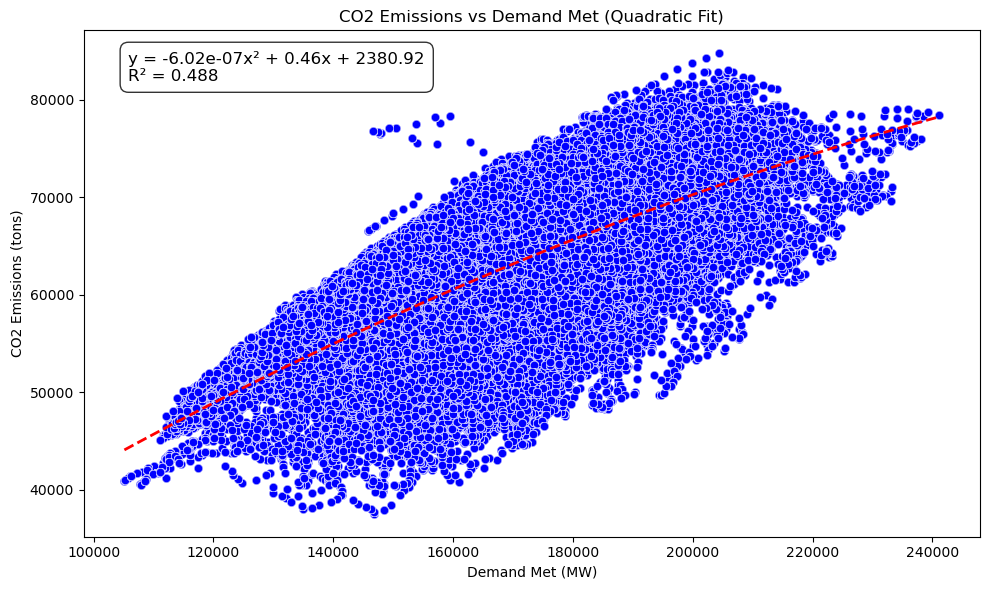

In [57]:
# Quadratic relationship with visible equation and R²
plt.figure(figsize=(10, 6))

# Plot scatter points with custom alpha
sns.scatterplot(x='demand_met', y='tons_co2', data=train_df, alpha=0.3, color='blue')

# Compute the polynomial coefficients manually
x = train_df['demand_met']
y = train_df['tons_co2']
coeffs = np.polyfit(x, y, 2)

# Calculate R² for the quadratic fit
y_quad_pred = coeffs[0] * x**2 + coeffs[1] * x + coeffs[2]
r_squared = r2_score(y, y_quad_pred)

# Generate points for the curve
x_range = np.linspace(x.min(), x.max(), 100)
y_pred = coeffs[0] * x_range**2 + coeffs[1] * x_range + coeffs[2]

# Plot the fit line with custom style
plt.plot(x_range, y_pred, 'r--', linewidth=2)

# Create equation text with formatted coefficients and R²
equation = f"y = {coeffs[0]:.2e}x² + {coeffs[1]:.2f}x + {coeffs[2]:.2f}\nR² = {r_squared:.3f}"
plt.annotate(equation, xy=(0.05, 0.90), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
             fontsize=12)

plt.title('CO2 Emissions vs Demand Met (Quadratic Fit)')
plt.xlabel('Demand Met (MW)')
plt.ylabel('CO2 Emissions (tons)')
plt.tight_layout()
plt.show()

Relationship With Demand

#### Weather Influence on Emissions


WEATHER INFLUENCE ON EMISSIONS


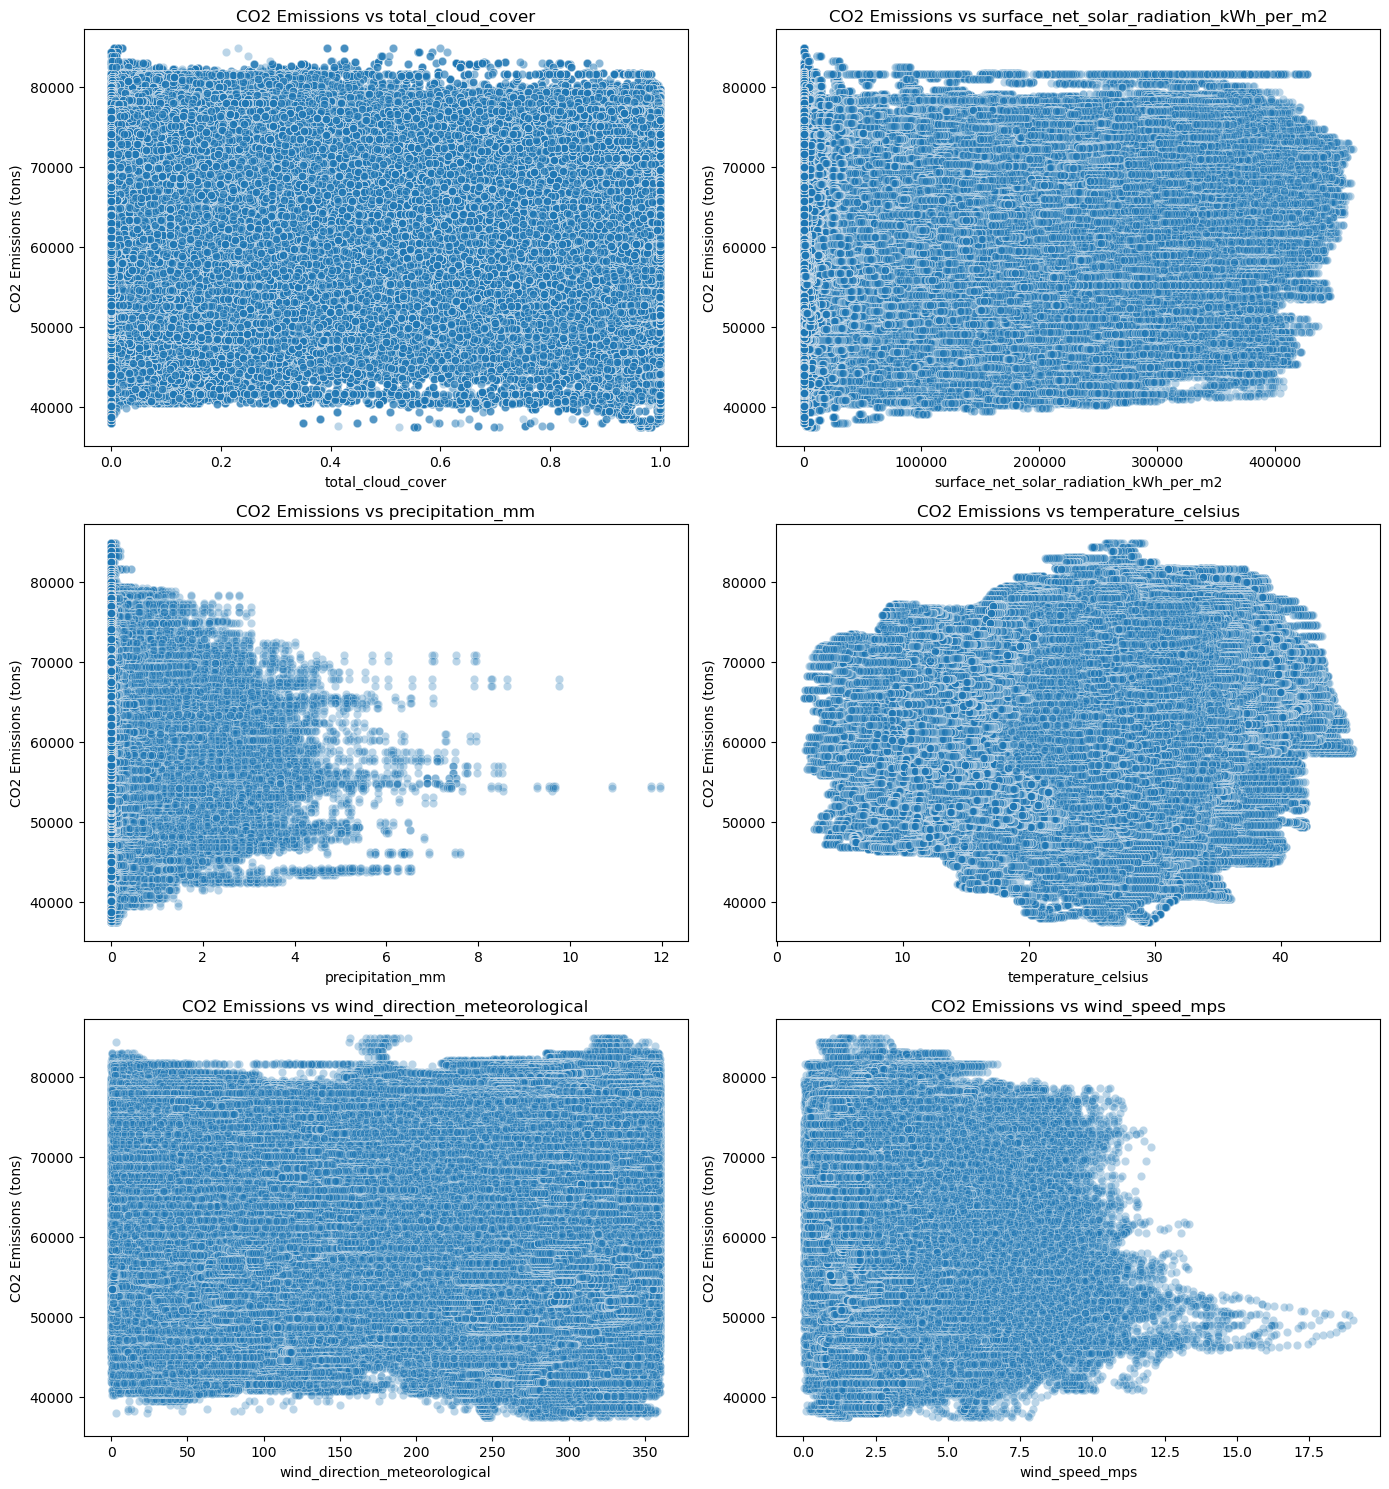

In [131]:
print("\n" + "="*80)
print("WEATHER INFLUENCE ON EMISSIONS")
print("="*80)

n_vars = len(final_recommended_weather_predictor_vars)
n_rows = (n_vars + 1) // 2  # Ensure enough rows for all variables

# Create properly sized subplot grid
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 5*n_rows))
axes = axes.flatten()

for i, var in enumerate(final_recommended_weather_predictor_vars):
    sns.scatterplot(x=var, y='tons_co2', data=train_df, alpha=0.3, ax=axes[i])
    axes[i].set_title(f'CO2 Emissions vs {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('CO2 Emissions (tons)')

# Hide any unused subplots
for j in range(n_vars, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



GRID PREDICTOR INFLUENCE ON EMISSIONS


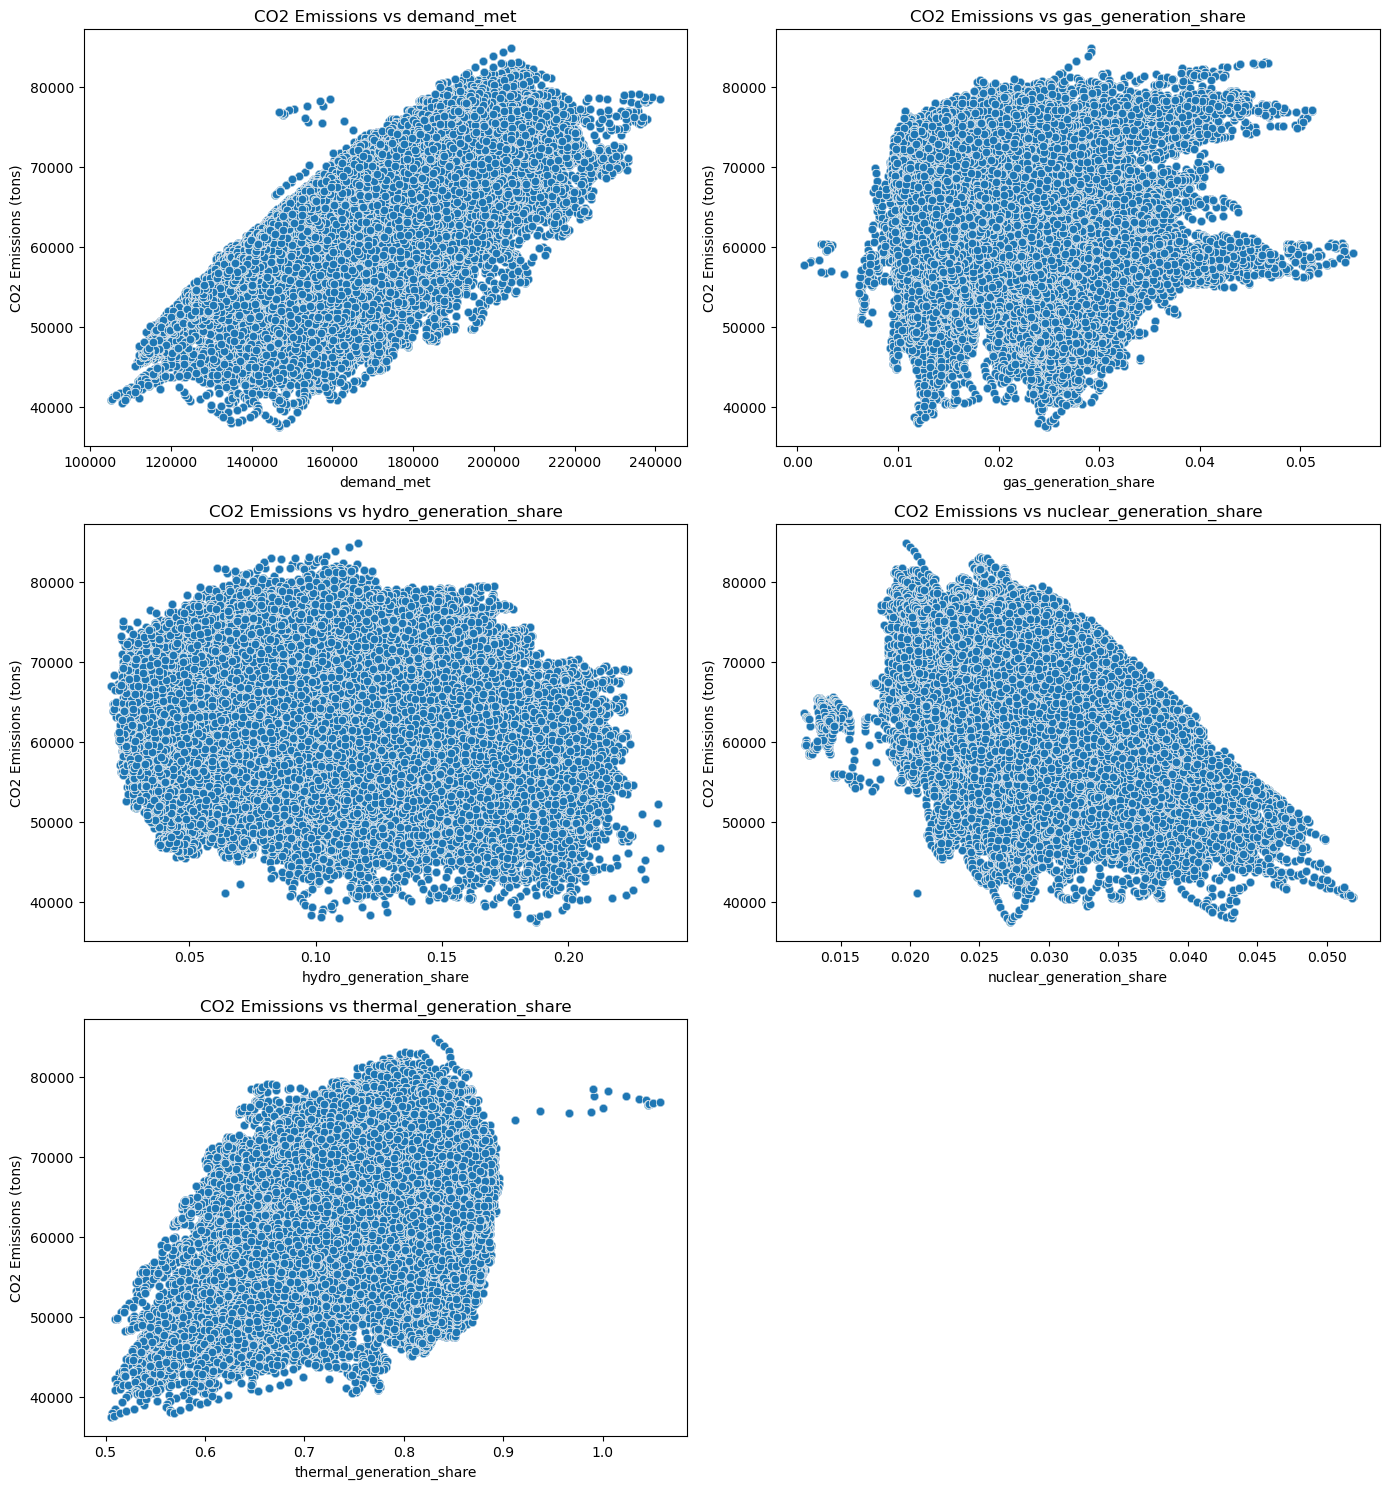

In [144]:
train_df_enhanced = train_pldf_enhanced.to_pandas()

print("\n" + "="*80)
print("GRID PREDICTOR INFLUENCE ON EMISSIONS")
print("="*80)

# Calculate required dimensions
n_vars = len(final_recommended_grid_predictor_vars)
n_rows = (n_vars + 1) // 2  # Ensure enough rows for all variables

# Create properly sized subplot grid
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 5*n_rows))
axes = axes.flatten()

for i, var in enumerate(final_recommended_grid_predictor_vars):
    sns.scatterplot(x=var, y='tons_co2', data=train_df_enhanced, alpha=0.3, ax=axes[i])
    axes[i].set_title(f'CO2 Emissions vs {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('CO2 Emissions (tons)')

# Hide any unused subplots
for j in range(n_vars, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


##### Summary from Correlation Plots

* Demand_met is the dominant driver: near-linear, tight positive relationship with tons_CO₂. Baseline slope of emissions.


* Generation mix moves emissions up/down around that baseline:
    * Nuclear_share: strong, monotonic negative association (clean baseload displacing fossil).
    * Renewable_share: clear negative association (solar/wind displacing fossil), a bit noisier at higher demand.
    * Gas_share: tends to increase emissions (positive slope), though triangular scatter suggests regime changes/constraints.
    * Hydro_share: weak/seasonal pattern; effect is there but muddied by monsoon seasonality.


* Weather -> weak direct correlation with tons_CO₂ on raw scatter:
    * Expected as weather mainly acts through the mix (solar/wind/hydro availability) and through demand (temp -> AC load). 
    * Raw bivariate plots hide interactions and the circular/diurnal structure.

**Weather vs CO₂**
* Total_cloud_cover: flat band (0–1) with CO₂ spanning wide -> weak direct effect; it proxies solar availability but demand & mix confound it.
* Surface_net_solar_radiation_kWh/m²: mild negative slope (more sun -> more PV -> lower CO₂), masked by day/night and demand spikes.
* Precipitation: most mass at 0; when rain > 0, CO₂ skews slightly lower (hydro/wind effects + reduced cooling load), but very noisy.
* Temperature: non-monotonic “blob”—high temps push demand up (also CO₂), but often coincide with clear skies (more solar, less CO₂).
* Wind direction: no linear pattern in degrees (circular!).
* Wind speed: weak negative trend at higher speeds (wind gen), but subtle.

**Grid vs CO₂**
* Demand_met: strong positive line - backbone of your model.
* Nuclear_share: most informative downward slope.
* Thermal_share: generally upward slope; hints at operating constraints or interaction with demand (thermal peakers).
* Gas_share: generally upward slope; triangular shape hints at operating constraints or interaction with demand (gas peakers).
* Hydro_share: weakly negative; dominated by seasonality.

#### Key Findings

In [136]:
numeric_train_df = train_df_enhanced[final_recommended_grid_predictor_vars + final_recommended_weather_predictor_vars + ['tons_co2']]
emissions_corr = numeric_train_df.corr()['tons_co2'].sort_values(ascending=False)
display(emissions_corr)

tons_co2                                  1.000000
demand_met                                0.697106
wind_direction_meteorological             0.121868
temperature_celsius                       0.075755
surface_net_solar_radiation_kWh_per_m2    0.007300
wind_speed_mps                           -0.052885
gas_generation_share                     -0.074790
precipitation_mm                         -0.131187
renewable_generation_share               -0.198895
total_cloud_cover                        -0.203984
hydro_generation_share                   -0.247020
nuclear_generation_share                 -0.471399
Name: tons_co2, dtype: float64

**Prepared data**: 
* Joined half-hourly grid readings (2021–2025, Delhi & Mumbai) with processed ERA5 weather, converted to IST, and split into train (2021–2023), val (2024-01 -> 05), test (2024-06 ->2025-05).

**Exploratory checks**: Looked at distributions, skew/kurtosis, outliers (z-score & IQR), bivariate scatter with `tons_co2`.

**Collinearity audit (VIF & heatmaps)**:
  * Solar variables are unit-duplicates -> kept only `surface_net_solar_radiation_kWh_per_m2`.
  * Cloud layers (high/med/low) are redundant with the total; tests showed lower single VIF for `total_cloud_cover`, so we kept total and dropped the layers in the compact set.
  * Generation levels are highly correlated with demand and with each other -> replaced with *shares* anddropped thermal share (treated as the implicit baseline since shares sum≈1). This made `demand_met` more independent and still encodes thermal via the simplex constraint.


**Key findings from EDA**
* **Target (`tons_co2`)**: Near-Gaussian, mild left skew -> standard regression loss is fine.
* **Demand is the backbone**: very tight, positive relation with emissions.
* **Generation mix moves emissions around the baseline**:
  * **Nuclear\_share, Renewable\_share -> lower CO₂** (monotonic negative).
  * **Gas\_share -> higher CO₂** (positive; triangular pattern suggests operating constraints).
  * **Hydro\_share**: weak, seasonal signal (monsoon).
* **Weather has weak *direct* correlation with CO₂** in raw scatter; it acts **through** demand and supply availability (solar/wind) -> interactions matter.
* **Outliers**: Heavy-tailed **precipitation** (zero-inflated) and modest right tail in **wind\_speed** as expected; bounded clouds show no statistical outliers.


**Recommended predictor set (for baseline)**

**Grid**
* `demand_met`
* `gas_generation_share`, `hydro_generation_share`, `nuclear_generation_share`, `renewable_generation_share`
  * *(Thermal share omitted; captured implicitly by the shares summing to 1.)*

**Weather**
* `total_cloud_cover`
* `surface_net_solar_radiation_kWh_per_m2`
* `precipitation_mm`
* `temperature_celsius`
* `wind_speed_mps`
* `wind_direction_meteorological`

**Excluded on purpose**
* Raw generation levels (replaced by shares), `total_generation`, `non_renewable_generation`, intensity/ratio targets (`g_co2_per_kwh`, `tons_co2_per_mwh`), duplicate solar measures, cloud layers.

**Potential Transformations to apply**
* **Precipitation**: two-part (`precip>0` flag + `log1p(precip)` for >0) *or* `log1p` + flag.
* **Wind speed**: `log1p` (for linear/GAM); raw is fine for trees.
* **Wind direction**: encode as **sin/cos** (optionally speed-weighted); avoid one-hot.
* **Temperature**: standardize; add **Cooling Degree Hours** and **season×hour** features.
* **Solar**: add **day/night mask**; consider `log1p` on daytime if using linear models.
* **Clamping**: keep clouds in **\[0,1]** (already done).